In [2]:
!pip install transformers


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers

2023-05-14 18:06:33.265498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 18:06:33.399340: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-14 18:06:34.945131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64:/root/.mujoco/mujoco210/bin:/usr/lib/nvidia:/users/Enseignants/piwowarski/.mujoco/mujoco210/bin:/usr/lib/nvidia
2023-05-14 18:06:34.945241: W tensorflow/stream_executor/platform/defaul

In [3]:
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 2

#targets in snli
labels = ["contradiction", "entailment", "neutral"]

In [4]:
!curl -LO https://raw.githubusercontent.com/MohamadMerchant/SNLI/master/data.tar.gz
!tar -xvzf data.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.1M  100 11.1M    0     0  12.5M      0 --:--:-- --:--:-- --:--:-- 12.5M --:--:--     0
SNLI_Corpus/
SNLI_Corpus/snli_1.0_dev.csv
SNLI_Corpus/snli_1.0_train.csv
SNLI_Corpus/snli_1.0_test.csv


In [5]:
# There are more than 550k samples in total
train_df = pd.read_csv("SNLI_Corpus/snli_1.0_train.csv", nrows=550000)
valid_df = pd.read_csv("SNLI_Corpus/snli_1.0_dev.csv")
test_df = pd.read_csv("SNLI_Corpus/snli_1.0_test.csv")

# Shape of the data
print(f"Total train samples : {train_df.shape[0]}")
print(f"Total validation samples: {valid_df.shape[0]}")
print(f"Total test samples: {valid_df.shape[0]}")

Total train samples : 550000
Total validation samples: 10000
Total test samples: 10000


In [6]:
print(f"Sentence1: {train_df.loc[1, 'sentence1']}")
print(f"Sentence2: {train_df.loc[1, 'sentence2']}")
print(f"Similarity: {train_df.loc[1, 'similarity']}")

Sentence1: A person on a horse jumps over a broken down airplane.
Sentence2: A person is at a diner, ordering an omelette.
Similarity: contradiction


In [7]:
# We have some NaN entries so i drop themm.
print("Number of missing values")
print(train_df.isnull().sum())
train_df.dropna(axis=0, inplace=True)

Number of missing values
similarity    0
sentence1     0
sentence2     6
dtype: int64


In [8]:
print("Train Target Distribution")
print(train_df.similarity.value_counts())

Train Target Distribution
entailment       183364
contradiction    183134
neutral          182711
-                   785
Name: similarity, dtype: int64


In [9]:
print("Validation Target Distribution")
print(valid_df.similarity.value_counts())

Validation Target Distribution
entailment       3329
contradiction    3278
neutral          3235
-                 158
Name: similarity, dtype: int64


In [10]:
#The value "-" appears as part of our training and validation targets. We will skip these samples.
train_df = (
    train_df[train_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)
valid_df = (
    valid_df[valid_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

In [11]:
#One-hot encode training, validation, and test labels.

train_df["label"] = train_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=3)

valid_df["label"] = valid_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_val = tf.keras.utils.to_categorical(valid_df.label, num_classes=3)

test_df["label"] = test_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=3)

In [12]:

class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)


In [14]:
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    bert_output = bert_model.bert(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(3, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2023-05-14 11:49:18.792838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-14 11:49:18.825716: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-14 11:49:18.825893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-14 11:49:18.826492: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7fb258a65580>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                           

In [13]:
train_data = BertSemanticDataGenerator(
    train_df[["sentence1", "sentence2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    valid_df[["sentence1", "sentence2"]].values.astype("str"),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

In [16]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
    shuffle=True
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/users/nfs/Enseignants/piwowarski/venv/deepdac/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
2023-05-14 11:49:31.421789: W tensorflow/core/grappler/optimizer

Epoch 1/2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-05-14 11:49:42.249293: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


   13/17162 [..............................] - ETA: 32:52 - loss: 1.1843 - acc: 0.3293

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


   31/17162 [..............................] - ETA: 33:10 - loss: 1.1301 - acc: 0.3790

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


   40/17162 [..............................] - ETA: 32:51 - loss: 1.1211 - acc: 0.3891

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  111/17162 [..............................] - ETA: 33:15 - loss: 1.0642 - acc: 0.4457

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  131/17162 [..............................] - ETA: 33:14 - loss: 1.0492 - acc: 0.4592

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  198/17162 [..............................] - ETA: 33:13 - loss: 1.0066 - acc: 0.4981

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  271/17162 [..............................] - ETA: 33:12 - loss: 0.9707 - acc: 0.5268

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  292/17162 [..............................] - ETA: 33:13 - loss: 0.9634 - acc: 0.5333

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  304/17162 [..............................] - ETA: 33:11 - loss: 0.9570 - acc: 0.5369

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  385/17162 [..............................] - ETA: 33:02 - loss: 0.9280 - acc: 0.5580

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  391/17162 [..............................] - ETA: 33:01 - loss: 0.9248 - acc: 0.5599

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  405/17162 [..............................] - ETA: 32:59 - loss: 0.9181 - acc: 0.5638

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  486/17162 [..............................] - ETA: 32:53 - loss: 0.8934 - acc: 0.5814

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  537/17162 [..............................] - ETA: 32:48 - loss: 0.8812 - acc: 0.5899

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  541/17162 [..............................] - ETA: 32:48 - loss: 0.8801 - acc: 0.5903

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  664/17162 [>.............................] - ETA: 32:33 - loss: 0.8536 - acc: 0.6097

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  685/17162 [>.............................] - ETA: 32:30 - loss: 0.8494 - acc: 0.6117

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  744/17162 [>.............................] - ETA: 32:23 - loss: 0.8401 - acc: 0.6176

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  779/17162 [>.............................] - ETA: 32:20 - loss: 0.8347 - acc: 0.6213

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  786/17162 [>.............................] - ETA: 32:19 - loss: 0.8333 - acc: 0.6224

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  841/17162 [>.............................] - ETA: 32:13 - loss: 0.8266 - acc: 0.6263

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  859/17162 [>.............................] - ETA: 32:11 - loss: 0.8234 - acc: 0.6282

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  867/17162 [>.............................] - ETA: 32:10 - loss: 0.8222 - acc: 0.6290

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  882/17162 [>.............................] - ETA: 32:08 - loss: 0.8204 - acc: 0.6300

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  901/17162 [>.............................] - ETA: 32:05 - loss: 0.8165 - acc: 0.6323

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  953/17162 [>.............................] - ETA: 31:59 - loss: 0.8106 - acc: 0.6355

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1185/17162 [=>............................] - ETA: 31:31 - loss: 0.7858 - acc: 0.6507

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1211/17162 [=>............................] - ETA: 31:29 - loss: 0.7838 - acc: 0.6516

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1267/17162 [=>............................] - ETA: 31:24 - loss: 0.7782 - acc: 0.6546

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1285/17162 [=>............................] - ETA: 31:21 - loss: 0.7766 - acc: 0.6556

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1299/17162 [=>............................] - ETA: 31:20 - loss: 0.7752 - acc: 0.6564

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1340/17162 [=>............................] - ETA: 31:15 - loss: 0.7727 - acc: 0.6583

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1349/17162 [=>............................] - ETA: 31:14 - loss: 0.7722 - acc: 0.6588

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1394/17162 [=>............................] - ETA: 31:09 - loss: 0.7689 - acc: 0.6608

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1412/17162 [=>............................] - ETA: 31:07 - loss: 0.7674 - acc: 0.6616

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1475/17162 [=>............................] - ETA: 31:00 - loss: 0.7620 - acc: 0.6649

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1595/17162 [=>............................] - ETA: 30:46 - loss: 0.7518 - acc: 0.6706

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1603/17162 [=>............................] - ETA: 30:45 - loss: 0.7516 - acc: 0.6708

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1604/17162 [=>............................] - ETA: 30:45 - loss: 0.7514 - acc: 0.6709

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1640/17162 [=>............................] - ETA: 30:41 - loss: 0.7491 - acc: 0.6722

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1677/17162 [=>............................] - ETA: 30:37 - loss: 0.7474 - acc: 0.6732

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1730/17162 [==>...........................] - ETA: 30:31 - loss: 0.7451 - acc: 0.6743

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1741/17162 [==>...........................] - ETA: 30:30 - loss: 0.7446 - acc: 0.6745

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1790/17162 [==>...........................] - ETA: 30:24 - loss: 0.7430 - acc: 0.6757

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1797/17162 [==>...........................] - ETA: 30:24 - loss: 0.7426 - acc: 0.6758

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1826/17162 [==>...........................] - ETA: 30:21 - loss: 0.7411 - acc: 0.6768

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1828/17162 [==>...........................] - ETA: 30:20 - loss: 0.7412 - acc: 0.6767

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1835/17162 [==>...........................] - ETA: 30:20 - loss: 0.7410 - acc: 0.6769

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1924/17162 [==>...........................] - ETA: 30:09 - loss: 0.7367 - acc: 0.6791

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1956/17162 [==>...........................] - ETA: 30:06 - loss: 0.7350 - acc: 0.6802

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1982/17162 [==>...........................] - ETA: 30:02 - loss: 0.7334 - acc: 0.6810

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2001/17162 [==>...........................] - ETA: 29:59 - loss: 0.7326 - acc: 0.6815

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2042/17162 [==>...........................] - ETA: 29:54 - loss: 0.7309 - acc: 0.6824

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2200/17162 [==>...........................] - ETA: 29:34 - loss: 0.7249 - acc: 0.6862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2299/17162 [===>..........................] - ETA: 29:22 - loss: 0.7200 - acc: 0.6886

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2363/17162 [===>..........................] - ETA: 29:14 - loss: 0.7177 - acc: 0.6903

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2369/17162 [===>..........................] - ETA: 29:13 - loss: 0.7174 - acc: 0.6905

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2373/17162 [===>..........................] - ETA: 29:13 - loss: 0.7173 - acc: 0.6906

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2379/17162 [===>..........................] - ETA: 29:12 - loss: 0.7172 - acc: 0.6906

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2436/17162 [===>..........................] - ETA: 29:06 - loss: 0.7152 - acc: 0.6918

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2537/17162 [===>..........................] - ETA: 28:55 - loss: 0.7109 - acc: 0.6940

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2578/17162 [===>..........................] - ETA: 28:49 - loss: 0.7089 - acc: 0.6952

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2585/17162 [===>..........................] - ETA: 28:48 - loss: 0.7088 - acc: 0.6954

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2599/17162 [===>..........................] - ETA: 28:47 - loss: 0.7083 - acc: 0.6955

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2636/17162 [===>..........................] - ETA: 28:42 - loss: 0.7075 - acc: 0.6960

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2759/17162 [===>..........................] - ETA: 28:28 - loss: 0.7038 - acc: 0.6981

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2792/17162 [===>..........................] - ETA: 28:24 - loss: 0.7030 - acc: 0.6985

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2797/17162 [===>..........................] - ETA: 28:23 - loss: 0.7028 - acc: 0.6987

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2906/17162 [====>.........................] - ETA: 28:11 - loss: 0.7001 - acc: 0.7003

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2956/17162 [====>.........................] - ETA: 28:06 - loss: 0.6988 - acc: 0.7009

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2965/17162 [====>.........................] - ETA: 28:05 - loss: 0.6985 - acc: 0.7010

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2995/17162 [====>.........................] - ETA: 28:01 - loss: 0.6973 - acc: 0.7017

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3194/17162 [====>.........................] - ETA: 27:37 - loss: 0.6917 - acc: 0.7045

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3270/17162 [====>.........................] - ETA: 27:28 - loss: 0.6896 - acc: 0.7057

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3302/17162 [====>.........................] - ETA: 27:25 - loss: 0.6889 - acc: 0.7061

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3336/17162 [====>.........................] - ETA: 27:21 - loss: 0.6882 - acc: 0.7064

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3349/17162 [====>.........................] - ETA: 27:19 - loss: 0.6882 - acc: 0.7064

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3383/17162 [====>.........................] - ETA: 27:15 - loss: 0.6875 - acc: 0.7068

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3415/17162 [====>.........................] - ETA: 27:11 - loss: 0.6864 - acc: 0.7075

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3502/17162 [=====>........................] - ETA: 27:01 - loss: 0.6850 - acc: 0.7084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3551/17162 [=====>........................] - ETA: 26:55 - loss: 0.6839 - acc: 0.7091

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3619/17162 [=====>........................] - ETA: 26:47 - loss: 0.6825 - acc: 0.7099

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3626/17162 [=====>........................] - ETA: 26:46 - loss: 0.6825 - acc: 0.7099

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3690/17162 [=====>........................] - ETA: 26:38 - loss: 0.6817 - acc: 0.7103

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3696/17162 [=====>........................] - ETA: 26:38 - loss: 0.6816 - acc: 0.7104

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3741/17162 [=====>........................] - ETA: 26:32 - loss: 0.6809 - acc: 0.7108

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3775/17162 [=====>........................] - ETA: 26:28 - loss: 0.6804 - acc: 0.7111

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3917/17162 [=====>........................] - ETA: 26:11 - loss: 0.6784 - acc: 0.7123

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4002/17162 [=====>........................] - ETA: 26:01 - loss: 0.6767 - acc: 0.7133

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4014/17162 [======>.......................] - ETA: 26:00 - loss: 0.6767 - acc: 0.7132

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4032/17162 [======>.......................] - ETA: 25:58 - loss: 0.6764 - acc: 0.7134

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4059/17162 [======>.......................] - ETA: 25:54 - loss: 0.6762 - acc: 0.7136

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4074/17162 [======>.......................] - ETA: 25:53 - loss: 0.6761 - acc: 0.7137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4103/17162 [======>.......................] - ETA: 25:49 - loss: 0.6756 - acc: 0.7140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4155/17162 [======>.......................] - ETA: 25:43 - loss: 0.6742 - acc: 0.7148

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4186/17162 [======>.......................] - ETA: 25:39 - loss: 0.6736 - acc: 0.7151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4426/17162 [======>.......................] - ETA: 25:11 - loss: 0.6694 - acc: 0.7174

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4460/17162 [======>.......................] - ETA: 25:07 - loss: 0.6689 - acc: 0.7177

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4525/17162 [======>.......................] - ETA: 24:59 - loss: 0.6679 - acc: 0.7182

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4528/17162 [======>.......................] - ETA: 24:59 - loss: 0.6679 - acc: 0.7182

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4573/17162 [======>.......................] - ETA: 24:53 - loss: 0.6673 - acc: 0.7185

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4593/17162 [=======>......................] - ETA: 24:51 - loss: 0.6670 - acc: 0.7187

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4640/17162 [=======>......................] - ETA: 24:45 - loss: 0.6660 - acc: 0.7191

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4674/17162 [=======>......................] - ETA: 24:41 - loss: 0.6655 - acc: 0.7194

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4746/17162 [=======>......................] - ETA: 24:33 - loss: 0.6645 - acc: 0.7200

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4837/17162 [=======>......................] - ETA: 24:22 - loss: 0.6635 - acc: 0.7207

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4843/17162 [=======>......................] - ETA: 24:21 - loss: 0.6634 - acc: 0.7208

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4861/17162 [=======>......................] - ETA: 24:19 - loss: 0.6631 - acc: 0.7209

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4873/17162 [=======>......................] - ETA: 24:17 - loss: 0.6630 - acc: 0.7209

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4913/17162 [=======>......................] - ETA: 24:12 - loss: 0.6625 - acc: 0.7212

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4926/17162 [=======>......................] - ETA: 24:11 - loss: 0.6622 - acc: 0.7214

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4938/17162 [=======>......................] - ETA: 24:09 - loss: 0.6619 - acc: 0.7215

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5020/17162 [=======>......................] - ETA: 24:00 - loss: 0.6608 - acc: 0.7220

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5038/17162 [=======>......................] - ETA: 23:57 - loss: 0.6605 - acc: 0.7222

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5067/17162 [=======>......................] - ETA: 23:54 - loss: 0.6602 - acc: 0.7224

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5258/17162 [========>.....................] - ETA: 23:31 - loss: 0.6577 - acc: 0.7237

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5299/17162 [========>.....................] - ETA: 23:26 - loss: 0.6572 - acc: 0.7240

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5336/17162 [========>.....................] - ETA: 23:22 - loss: 0.6568 - acc: 0.7242

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5364/17162 [========>.....................] - ETA: 23:19 - loss: 0.6566 - acc: 0.7242

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5377/17162 [========>.....................] - ETA: 23:17 - loss: 0.6566 - acc: 0.7242

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5379/17162 [========>.....................] - ETA: 23:17 - loss: 0.6565 - acc: 0.7243

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5389/17162 [========>.....................] - ETA: 23:16 - loss: 0.6565 - acc: 0.7243

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5427/17162 [========>.....................] - ETA: 23:11 - loss: 0.6560 - acc: 0.7247

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5461/17162 [========>.....................] - ETA: 23:07 - loss: 0.6555 - acc: 0.7250

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5475/17162 [========>.....................] - ETA: 23:06 - loss: 0.6554 - acc: 0.7250

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5522/17162 [========>.....................] - ETA: 23:00 - loss: 0.6547 - acc: 0.7254

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5582/17162 [========>.....................] - ETA: 22:53 - loss: 0.6544 - acc: 0.7255

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5642/17162 [========>.....................] - ETA: 22:46 - loss: 0.6540 - acc: 0.7257

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5651/17162 [========>.....................] - ETA: 22:44 - loss: 0.6539 - acc: 0.7257

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5666/17162 [========>.....................] - ETA: 22:43 - loss: 0.6538 - acc: 0.7257

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5667/17162 [========>.....................] - ETA: 22:43 - loss: 0.6538 - acc: 0.7257

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5737/17162 [=========>....................] - ETA: 22:34 - loss: 0.6530 - acc: 0.7262

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5832/17162 [=========>....................] - ETA: 22:22 - loss: 0.6520 - acc: 0.7267

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5836/17162 [=========>....................] - ETA: 22:22 - loss: 0.6519 - acc: 0.7267

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5888/17162 [=========>....................] - ETA: 22:16 - loss: 0.6515 - acc: 0.7269

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5928/17162 [=========>....................] - ETA: 22:11 - loss: 0.6511 - acc: 0.7271

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5932/17162 [=========>....................] - ETA: 22:11 - loss: 0.6510 - acc: 0.7272

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5934/17162 [=========>....................] - ETA: 22:10 - loss: 0.6510 - acc: 0.7272

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5944/17162 [=========>....................] - ETA: 22:09 - loss: 0.6509 - acc: 0.7272

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5958/17162 [=========>....................] - ETA: 22:08 - loss: 0.6508 - acc: 0.7273

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5959/17162 [=========>....................] - ETA: 22:07 - loss: 0.6508 - acc: 0.7273

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6147/17162 [=========>....................] - ETA: 21:45 - loss: 0.6489 - acc: 0.7284

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6165/17162 [=========>....................] - ETA: 21:43 - loss: 0.6489 - acc: 0.7284

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6199/17162 [=========>....................] - ETA: 21:39 - loss: 0.6484 - acc: 0.7287

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6257/17162 [=========>....................] - ETA: 21:32 - loss: 0.6479 - acc: 0.7290

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6271/17162 [=========>....................] - ETA: 21:30 - loss: 0.6479 - acc: 0.7290

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6286/17162 [=========>....................] - ETA: 21:28 - loss: 0.6477 - acc: 0.7290

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6306/17162 [==========>...................] - ETA: 21:26 - loss: 0.6476 - acc: 0.7291

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6382/17162 [==========>...................] - ETA: 21:17 - loss: 0.6471 - acc: 0.7295

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6499/17162 [==========>...................] - ETA: 21:03 - loss: 0.6459 - acc: 0.7301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6551/17162 [==========>...................] - ETA: 20:57 - loss: 0.6453 - acc: 0.7304

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6570/17162 [==========>...................] - ETA: 20:55 - loss: 0.6452 - acc: 0.7304

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6571/17162 [==========>...................] - ETA: 20:55 - loss: 0.6452 - acc: 0.7304

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6612/17162 [==========>...................] - ETA: 20:50 - loss: 0.6446 - acc: 0.7307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6643/17162 [==========>...................] - ETA: 20:46 - loss: 0.6444 - acc: 0.7308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6720/17162 [==========>...................] - ETA: 20:37 - loss: 0.6435 - acc: 0.7313

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6721/17162 [==========>...................] - ETA: 20:37 - loss: 0.6435 - acc: 0.7313

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6781/17162 [==========>...................] - ETA: 20:30 - loss: 0.6430 - acc: 0.7315

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6796/17162 [==========>...................] - ETA: 20:28 - loss: 0.6428 - acc: 0.7316

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6805/17162 [==========>...................] - ETA: 20:27 - loss: 0.6427 - acc: 0.7316

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6814/17162 [==========>...................] - ETA: 20:26 - loss: 0.6426 - acc: 0.7317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6878/17162 [===========>..................] - ETA: 20:18 - loss: 0.6419 - acc: 0.7321

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6936/17162 [===========>..................] - ETA: 20:11 - loss: 0.6414 - acc: 0.7324

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6955/17162 [===========>..................] - ETA: 20:09 - loss: 0.6413 - acc: 0.7324

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6991/17162 [===========>..................] - ETA: 20:05 - loss: 0.6412 - acc: 0.7324

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7023/17162 [===========>..................] - ETA: 20:01 - loss: 0.6411 - acc: 0.7326

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7052/17162 [===========>..................] - ETA: 19:57 - loss: 0.6407 - acc: 0.7328

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7133/17162 [===========>..................] - ETA: 19:48 - loss: 0.6400 - acc: 0.7330

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7142/17162 [===========>..................] - ETA: 19:47 - loss: 0.6399 - acc: 0.7331

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7166/17162 [===========>..................] - ETA: 19:44 - loss: 0.6396 - acc: 0.7333

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7188/17162 [===========>..................] - ETA: 19:41 - loss: 0.6394 - acc: 0.7334

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7196/17162 [===========>..................] - ETA: 19:40 - loss: 0.6393 - acc: 0.7334

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7207/17162 [===========>..................] - ETA: 19:39 - loss: 0.6392 - acc: 0.7335

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7237/17162 [===========>..................] - ETA: 19:35 - loss: 0.6390 - acc: 0.7336

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7240/17162 [===========>..................] - ETA: 19:35 - loss: 0.6391 - acc: 0.7336

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7242/17162 [===========>..................] - ETA: 19:35 - loss: 0.6390 - acc: 0.7336

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7277/17162 [===========>..................] - ETA: 19:31 - loss: 0.6388 - acc: 0.7337

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7291/17162 [===========>..................] - ETA: 19:29 - loss: 0.6387 - acc: 0.7338

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7316/17162 [===========>..................] - ETA: 19:26 - loss: 0.6385 - acc: 0.7339

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7326/17162 [===========>..................] - ETA: 19:25 - loss: 0.6385 - acc: 0.7339

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7341/17162 [===========>..................] - ETA: 19:23 - loss: 0.6383 - acc: 0.7340

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7374/17162 [===========>..................] - ETA: 19:19 - loss: 0.6381 - acc: 0.7341

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7388/17162 [===========>..................] - ETA: 19:17 - loss: 0.6380 - acc: 0.7341

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7391/17162 [===========>..................] - ETA: 19:17 - loss: 0.6380 - acc: 0.7341

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7428/17162 [===========>..................] - ETA: 19:13 - loss: 0.6376 - acc: 0.7343

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7473/17162 [============>.................] - ETA: 19:07 - loss: 0.6371 - acc: 0.7346

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7500/17162 [============>.................] - ETA: 19:04 - loss: 0.6369 - acc: 0.7348

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7515/17162 [============>.................] - ETA: 19:02 - loss: 0.6367 - acc: 0.7348

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7528/17162 [============>.................] - ETA: 19:01 - loss: 0.6366 - acc: 0.7349

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7545/17162 [============>.................] - ETA: 18:59 - loss: 0.6363 - acc: 0.7350

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7550/17162 [============>.................] - ETA: 18:58 - loss: 0.6363 - acc: 0.7351

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7574/17162 [============>.................] - ETA: 18:55 - loss: 0.6360 - acc: 0.7352

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7587/17162 [============>.................] - ETA: 18:54 - loss: 0.6359 - acc: 0.7353

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7608/17162 [============>.................] - ETA: 18:51 - loss: 0.6358 - acc: 0.7353

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7619/17162 [============>.................] - ETA: 18:50 - loss: 0.6357 - acc: 0.7353

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7672/17162 [============>.................] - ETA: 18:44 - loss: 0.6352 - acc: 0.7357

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7679/17162 [============>.................] - ETA: 18:43 - loss: 0.6351 - acc: 0.7357

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7725/17162 [============>.................] - ETA: 18:38 - loss: 0.6346 - acc: 0.7359

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7729/17162 [============>.................] - ETA: 18:37 - loss: 0.6346 - acc: 0.7359

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7818/17162 [============>.................] - ETA: 18:26 - loss: 0.6339 - acc: 0.7363

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7845/17162 [============>.................] - ETA: 18:23 - loss: 0.6336 - acc: 0.7364

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7855/17162 [============>.................] - ETA: 18:22 - loss: 0.6336 - acc: 0.7364

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7974/17162 [============>.................] - ETA: 18:08 - loss: 0.6328 - acc: 0.7368

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7993/17162 [============>.................] - ETA: 18:06 - loss: 0.6327 - acc: 0.7369

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8034/17162 [=============>................] - ETA: 18:01 - loss: 0.6325 - acc: 0.7371

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8103/17162 [=============>................] - ETA: 17:52 - loss: 0.6320 - acc: 0.7374

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8160/17162 [=============>................] - ETA: 17:46 - loss: 0.6316 - acc: 0.7376

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8200/17162 [=============>................] - ETA: 17:41 - loss: 0.6313 - acc: 0.7378

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8220/17162 [=============>................] - ETA: 17:39 - loss: 0.6312 - acc: 0.7378

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8269/17162 [=============>................] - ETA: 17:33 - loss: 0.6307 - acc: 0.7380

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8276/17162 [=============>................] - ETA: 17:32 - loss: 0.6306 - acc: 0.7381

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8420/17162 [=============>................] - ETA: 17:15 - loss: 0.6295 - acc: 0.7387

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8460/17162 [=============>................] - ETA: 17:10 - loss: 0.6294 - acc: 0.7388

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8534/17162 [=============>................] - ETA: 17:01 - loss: 0.6288 - acc: 0.7391

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8570/17162 [=============>................] - ETA: 16:57 - loss: 0.6285 - acc: 0.7392

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8585/17162 [==============>...............] - ETA: 16:55 - loss: 0.6283 - acc: 0.7393

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8603/17162 [==============>...............] - ETA: 16:53 - loss: 0.6282 - acc: 0.7394

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8616/17162 [==============>...............] - ETA: 16:51 - loss: 0.6281 - acc: 0.7394

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8623/17162 [==============>...............] - ETA: 16:51 - loss: 0.6281 - acc: 0.7394

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8636/17162 [==============>...............] - ETA: 16:49 - loss: 0.6281 - acc: 0.7394

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8678/17162 [==============>...............] - ETA: 16:44 - loss: 0.6277 - acc: 0.7397

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8704/17162 [==============>...............] - ETA: 16:41 - loss: 0.6276 - acc: 0.7398

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8737/17162 [==============>...............] - ETA: 16:37 - loss: 0.6272 - acc: 0.7400

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8798/17162 [==============>...............] - ETA: 16:30 - loss: 0.6267 - acc: 0.7402

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8806/17162 [==============>...............] - ETA: 16:29 - loss: 0.6268 - acc: 0.7402

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8818/17162 [==============>...............] - ETA: 16:27 - loss: 0.6267 - acc: 0.7402

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8831/17162 [==============>...............] - ETA: 16:26 - loss: 0.6267 - acc: 0.7402

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8842/17162 [==============>...............] - ETA: 16:25 - loss: 0.6265 - acc: 0.7403

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8902/17162 [==============>...............] - ETA: 16:18 - loss: 0.6261 - acc: 0.7405

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8919/17162 [==============>...............] - ETA: 16:15 - loss: 0.6261 - acc: 0.7406

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8943/17162 [==============>...............] - ETA: 16:13 - loss: 0.6260 - acc: 0.7406

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8956/17162 [==============>...............] - ETA: 16:11 - loss: 0.6258 - acc: 0.7407

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9000/17162 [==============>...............] - ETA: 16:06 - loss: 0.6255 - acc: 0.7408

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9020/17162 [==============>...............] - ETA: 16:03 - loss: 0.6252 - acc: 0.7409

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9026/17162 [==============>...............] - ETA: 16:03 - loss: 0.6252 - acc: 0.7410

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9064/17162 [==============>...............] - ETA: 15:58 - loss: 0.6249 - acc: 0.7411

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9089/17162 [==============>...............] - ETA: 15:55 - loss: 0.6248 - acc: 0.7412

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9246/17162 [===============>..............] - ETA: 15:37 - loss: 0.6239 - acc: 0.7416

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9255/17162 [===============>..............] - ETA: 15:36 - loss: 0.6239 - acc: 0.7416

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9414/17162 [===============>..............] - ETA: 15:17 - loss: 0.6232 - acc: 0.7419

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9464/17162 [===============>..............] - ETA: 15:11 - loss: 0.6230 - acc: 0.7421

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9465/17162 [===============>..............] - ETA: 15:10 - loss: 0.6230 - acc: 0.7421

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9475/17162 [===============>..............] - ETA: 15:09 - loss: 0.6229 - acc: 0.7421

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9606/17162 [===============>..............] - ETA: 14:54 - loss: 0.6223 - acc: 0.7424

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9617/17162 [===============>..............] - ETA: 14:53 - loss: 0.6222 - acc: 0.7425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9627/17162 [===============>..............] - ETA: 14:51 - loss: 0.6222 - acc: 0.7425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9647/17162 [===============>..............] - ETA: 14:49 - loss: 0.6222 - acc: 0.7425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9873/17162 [================>.............] - ETA: 14:22 - loss: 0.6209 - acc: 0.7431

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9875/17162 [================>.............] - ETA: 14:22 - loss: 0.6208 - acc: 0.7431

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9962/17162 [================>.............] - ETA: 14:12 - loss: 0.6204 - acc: 0.7433

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9994/17162 [================>.............] - ETA: 14:08 - loss: 0.6203 - acc: 0.7434

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9996/17162 [================>.............] - ETA: 14:08 - loss: 0.6203 - acc: 0.7434

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10032/17162 [================>.............] - ETA: 14:03 - loss: 0.6201 - acc: 0.7435

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10206/17162 [================>.............] - ETA: 13:43 - loss: 0.6191 - acc: 0.7440

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10210/17162 [================>.............] - ETA: 13:42 - loss: 0.6191 - acc: 0.7440

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10211/17162 [================>.............] - ETA: 13:42 - loss: 0.6191 - acc: 0.7440

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10219/17162 [================>.............] - ETA: 13:41 - loss: 0.6191 - acc: 0.7440

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10263/17162 [================>.............] - ETA: 13:36 - loss: 0.6189 - acc: 0.7442

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10313/17162 [=================>............] - ETA: 13:30 - loss: 0.6187 - acc: 0.7443

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10375/17162 [=================>............] - ETA: 13:23 - loss: 0.6185 - acc: 0.7445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10410/17162 [=================>............] - ETA: 13:19 - loss: 0.6183 - acc: 0.7445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10432/17162 [=================>............] - ETA: 13:16 - loss: 0.6182 - acc: 0.7446

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10494/17162 [=================>............] - ETA: 13:09 - loss: 0.6179 - acc: 0.7448

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10496/17162 [=================>............] - ETA: 13:08 - loss: 0.6179 - acc: 0.7448

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10500/17162 [=================>............] - ETA: 13:08 - loss: 0.6179 - acc: 0.7448

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10517/17162 [=================>............] - ETA: 13:06 - loss: 0.6177 - acc: 0.7449

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10619/17162 [=================>............] - ETA: 12:54 - loss: 0.6172 - acc: 0.7451

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10626/17162 [=================>............] - ETA: 12:53 - loss: 0.6172 - acc: 0.7451

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10677/17162 [=================>............] - ETA: 12:47 - loss: 0.6169 - acc: 0.7453

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10704/17162 [=================>............] - ETA: 12:44 - loss: 0.6167 - acc: 0.7454

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10749/17162 [=================>............] - ETA: 12:39 - loss: 0.6165 - acc: 0.7455

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10762/17162 [=================>............] - ETA: 12:37 - loss: 0.6165 - acc: 0.7455

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10799/17162 [=================>............] - ETA: 12:33 - loss: 0.6164 - acc: 0.7455

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10818/17162 [=================>............] - ETA: 12:30 - loss: 0.6163 - acc: 0.7456

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10846/17162 [=================>............] - ETA: 12:27 - loss: 0.6162 - acc: 0.7457

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10854/17162 [=================>............] - ETA: 12:26 - loss: 0.6162 - acc: 0.7457

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10855/17162 [=================>............] - ETA: 12:26 - loss: 0.6162 - acc: 0.7457

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10867/17162 [=================>............] - ETA: 12:25 - loss: 0.6161 - acc: 0.7457

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10903/17162 [==================>...........] - ETA: 12:20 - loss: 0.6159 - acc: 0.7458

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10923/17162 [==================>...........] - ETA: 12:18 - loss: 0.6158 - acc: 0.7459

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10930/17162 [==================>...........] - ETA: 12:17 - loss: 0.6158 - acc: 0.7459

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11020/17162 [==================>...........] - ETA: 12:06 - loss: 0.6153 - acc: 0.7461

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11102/17162 [==================>...........] - ETA: 11:57 - loss: 0.6149 - acc: 0.7463

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11150/17162 [==================>...........] - ETA: 11:51 - loss: 0.6147 - acc: 0.7464

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11173/17162 [==================>...........] - ETA: 11:48 - loss: 0.6147 - acc: 0.7464

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11259/17162 [==================>...........] - ETA: 11:38 - loss: 0.6142 - acc: 0.7467

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11279/17162 [==================>...........] - ETA: 11:36 - loss: 0.6141 - acc: 0.7467

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11287/17162 [==================>...........] - ETA: 11:35 - loss: 0.6141 - acc: 0.7467

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11391/17162 [==================>...........] - ETA: 11:22 - loss: 0.6138 - acc: 0.7468

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11426/17162 [==================>...........] - ETA: 11:18 - loss: 0.6137 - acc: 0.7468

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11442/17162 [===================>..........] - ETA: 11:16 - loss: 0.6136 - acc: 0.7469

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11563/17162 [===================>..........] - ETA: 11:02 - loss: 0.6132 - acc: 0.7471

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11647/17162 [===================>..........] - ETA: 10:52 - loss: 0.6129 - acc: 0.7472

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11661/17162 [===================>..........] - ETA: 10:50 - loss: 0.6129 - acc: 0.7473

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11673/17162 [===================>..........] - ETA: 10:49 - loss: 0.6128 - acc: 0.7473

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11717/17162 [===================>..........] - ETA: 10:44 - loss: 0.6124 - acc: 0.7475

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11722/17162 [===================>..........] - ETA: 10:43 - loss: 0.6124 - acc: 0.7475

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11724/17162 [===================>..........] - ETA: 10:43 - loss: 0.6124 - acc: 0.7475

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11745/17162 [===================>..........] - ETA: 10:40 - loss: 0.6123 - acc: 0.7475

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11802/17162 [===================>..........] - ETA: 10:34 - loss: 0.6121 - acc: 0.7475

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11814/17162 [===================>..........] - ETA: 10:32 - loss: 0.6121 - acc: 0.7475

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11823/17162 [===================>..........] - ETA: 10:31 - loss: 0.6121 - acc: 0.7476

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11835/17162 [===================>..........] - ETA: 10:30 - loss: 0.6120 - acc: 0.7476

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11915/17162 [===================>..........] - ETA: 10:20 - loss: 0.6118 - acc: 0.7477

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11960/17162 [===================>..........] - ETA: 10:15 - loss: 0.6117 - acc: 0.7477

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12029/17162 [====================>.........] - ETA: 10:07 - loss: 0.6113 - acc: 0.7479

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12045/17162 [====================>.........] - ETA: 10:05 - loss: 0.6113 - acc: 0.7479

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12106/17162 [====================>.........] - ETA: 9:58 - loss: 0.6109 - acc: 0.7481

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12123/17162 [====================>.........] - ETA: 9:56 - loss: 0.6108 - acc: 0.7481

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12204/17162 [====================>.........] - ETA: 9:46 - loss: 0.6103 - acc: 0.7484

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12270/17162 [====================>.........] - ETA: 9:38 - loss: 0.6100 - acc: 0.7485

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12301/17162 [====================>.........] - ETA: 9:35 - loss: 0.6098 - acc: 0.7486

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12359/17162 [====================>.........] - ETA: 9:28 - loss: 0.6095 - acc: 0.7487

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12449/17162 [====================>.........] - ETA: 9:17 - loss: 0.6091 - acc: 0.7489

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12584/17162 [====================>.........] - ETA: 9:01 - loss: 0.6086 - acc: 0.7491

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12605/17162 [=====================>........] - ETA: 8:59 - loss: 0.6086 - acc: 0.7492

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12678/17162 [=====================>........] - ETA: 8:50 - loss: 0.6083 - acc: 0.7493

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12731/17162 [=====================>........] - ETA: 8:44 - loss: 0.6082 - acc: 0.7494

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12732/17162 [=====================>........] - ETA: 8:44 - loss: 0.6082 - acc: 0.7494

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12746/17162 [=====================>........] - ETA: 8:42 - loss: 0.6081 - acc: 0.7494

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12749/17162 [=====================>........] - ETA: 8:42 - loss: 0.6081 - acc: 0.7494

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12842/17162 [=====================>........] - ETA: 8:31 - loss: 0.6077 - acc: 0.7497

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12917/17162 [=====================>........] - ETA: 8:22 - loss: 0.6076 - acc: 0.7497

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12958/17162 [=====================>........] - ETA: 8:17 - loss: 0.6074 - acc: 0.7498

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13137/17162 [=====================>........] - ETA: 7:56 - loss: 0.6065 - acc: 0.7503

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13173/17162 [======================>.......] - ETA: 7:52 - loss: 0.6063 - acc: 0.7504

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13179/17162 [======================>.......] - ETA: 7:51 - loss: 0.6062 - acc: 0.7505

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13192/17162 [======================>.......] - ETA: 7:49 - loss: 0.6062 - acc: 0.7505

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13201/17162 [======================>.......] - ETA: 7:48 - loss: 0.6062 - acc: 0.7505

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13209/17162 [======================>.......] - ETA: 7:47 - loss: 0.6062 - acc: 0.7505

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13215/17162 [======================>.......] - ETA: 7:47 - loss: 0.6061 - acc: 0.7505

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13216/17162 [======================>.......] - ETA: 7:46 - loss: 0.6061 - acc: 0.7505

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13225/17162 [======================>.......] - ETA: 7:45 - loss: 0.6061 - acc: 0.7505

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13232/17162 [======================>.......] - ETA: 7:45 - loss: 0.6062 - acc: 0.7505

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13253/17162 [======================>.......] - ETA: 7:42 - loss: 0.6060 - acc: 0.7506

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13293/17162 [======================>.......] - ETA: 7:37 - loss: 0.6059 - acc: 0.7506

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13348/17162 [======================>.......] - ETA: 7:31 - loss: 0.6058 - acc: 0.7507

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13381/17162 [======================>.......] - ETA: 7:27 - loss: 0.6058 - acc: 0.7507

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13387/17162 [======================>.......] - ETA: 7:26 - loss: 0.6058 - acc: 0.7507

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13537/17162 [======================>.......] - ETA: 7:08 - loss: 0.6050 - acc: 0.7511

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13569/17162 [======================>.......] - ETA: 7:05 - loss: 0.6049 - acc: 0.7511

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13584/17162 [======================>.......] - ETA: 7:03 - loss: 0.6048 - acc: 0.7511

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13591/17162 [======================>.......] - ETA: 7:02 - loss: 0.6048 - acc: 0.7512

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13616/17162 [======================>.......] - ETA: 6:59 - loss: 0.6047 - acc: 0.7512

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13745/17162 [=======================>......] - ETA: 6:44 - loss: 0.6041 - acc: 0.7515

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13774/17162 [=======================>......] - ETA: 6:40 - loss: 0.6040 - acc: 0.7516

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13880/17162 [=======================>......] - ETA: 6:28 - loss: 0.6036 - acc: 0.7518

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13885/17162 [=======================>......] - ETA: 6:27 - loss: 0.6036 - acc: 0.7518

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13908/17162 [=======================>......] - ETA: 6:25 - loss: 0.6034 - acc: 0.7519

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13911/17162 [=======================>......] - ETA: 6:24 - loss: 0.6034 - acc: 0.7519

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13930/17162 [=======================>......] - ETA: 6:22 - loss: 0.6034 - acc: 0.7519

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14050/17162 [=======================>......] - ETA: 6:08 - loss: 0.6031 - acc: 0.7521

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14055/17162 [=======================>......] - ETA: 6:07 - loss: 0.6031 - acc: 0.7520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14141/17162 [=======================>......] - ETA: 5:57 - loss: 0.6028 - acc: 0.7522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14170/17162 [=======================>......] - ETA: 5:54 - loss: 0.6026 - acc: 0.7523

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14284/17162 [=======================>......] - ETA: 5:40 - loss: 0.6024 - acc: 0.7524

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14404/17162 [========================>.....] - ETA: 5:26 - loss: 0.6020 - acc: 0.7526

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14544/17162 [========================>.....] - ETA: 5:09 - loss: 0.6015 - acc: 0.7528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14748/17162 [========================>.....] - ETA: 4:45 - loss: 0.6010 - acc: 0.7531

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14785/17162 [========================>.....] - ETA: 4:41 - loss: 0.6008 - acc: 0.7532

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14803/17162 [========================>.....] - ETA: 4:39 - loss: 0.6008 - acc: 0.7532

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14843/17162 [========================>.....] - ETA: 4:34 - loss: 0.6006 - acc: 0.7532

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14869/17162 [========================>.....] - ETA: 4:31 - loss: 0.6004 - acc: 0.7533

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14911/17162 [=========================>....] - ETA: 4:26 - loss: 0.6003 - acc: 0.7534

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14920/17162 [=========================>....] - ETA: 4:25 - loss: 0.6003 - acc: 0.7533

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14946/17162 [=========================>....] - ETA: 4:22 - loss: 0.6002 - acc: 0.7534

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14949/17162 [=========================>....] - ETA: 4:21 - loss: 0.6003 - acc: 0.7534

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14951/17162 [=========================>....] - ETA: 4:21 - loss: 0.6002 - acc: 0.7534

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15056/17162 [=========================>....] - ETA: 4:09 - loss: 0.5999 - acc: 0.7535

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15074/17162 [=========================>....] - ETA: 4:07 - loss: 0.5998 - acc: 0.7535

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15106/17162 [=========================>....] - ETA: 4:03 - loss: 0.5999 - acc: 0.7535

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15204/17162 [=========================>....] - ETA: 3:51 - loss: 0.5994 - acc: 0.7537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15234/17162 [=========================>....] - ETA: 3:48 - loss: 0.5993 - acc: 0.7538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15323/17162 [=========================>....] - ETA: 3:37 - loss: 0.5989 - acc: 0.7540

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15341/17162 [=========================>....] - ETA: 3:35 - loss: 0.5988 - acc: 0.7541

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15362/17162 [=========================>....] - ETA: 3:32 - loss: 0.5987 - acc: 0.7541

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15388/17162 [=========================>....] - ETA: 3:29 - loss: 0.5986 - acc: 0.7542

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15406/17162 [=========================>....] - ETA: 3:27 - loss: 0.5985 - acc: 0.7542

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15421/17162 [=========================>....] - ETA: 3:25 - loss: 0.5984 - acc: 0.7542

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15430/17162 [=========================>....] - ETA: 3:24 - loss: 0.5984 - acc: 0.7542

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15519/17162 [==========================>...] - ETA: 3:14 - loss: 0.5980 - acc: 0.7545

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15540/17162 [==========================>...] - ETA: 3:11 - loss: 0.5979 - acc: 0.7546

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15542/17162 [==========================>...] - ETA: 3:11 - loss: 0.5979 - acc: 0.7546

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15549/17162 [==========================>...] - ETA: 3:10 - loss: 0.5980 - acc: 0.7546

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15588/17162 [==========================>...] - ETA: 3:06 - loss: 0.5978 - acc: 0.7546

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15590/17162 [==========================>...] - ETA: 3:05 - loss: 0.5978 - acc: 0.7546

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15608/17162 [==========================>...] - ETA: 3:03 - loss: 0.5978 - acc: 0.7546

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15612/17162 [==========================>...] - ETA: 3:03 - loss: 0.5978 - acc: 0.7546

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15636/17162 [==========================>...] - ETA: 3:00 - loss: 0.5977 - acc: 0.7546

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15684/17162 [==========================>...] - ETA: 2:54 - loss: 0.5976 - acc: 0.7547

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15698/17162 [==========================>...] - ETA: 2:53 - loss: 0.5976 - acc: 0.7547

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15717/17162 [==========================>...] - ETA: 2:50 - loss: 0.5975 - acc: 0.7547

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15729/17162 [==========================>...] - ETA: 2:49 - loss: 0.5975 - acc: 0.7547

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15741/17162 [==========================>...] - ETA: 2:48 - loss: 0.5975 - acc: 0.7548

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15767/17162 [==========================>...] - ETA: 2:45 - loss: 0.5974 - acc: 0.7548

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15788/17162 [==========================>...] - ETA: 2:42 - loss: 0.5973 - acc: 0.7548

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15818/17162 [==========================>...] - ETA: 2:39 - loss: 0.5972 - acc: 0.7549

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15830/17162 [==========================>...] - ETA: 2:37 - loss: 0.5972 - acc: 0.7549

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15848/17162 [==========================>...] - ETA: 2:35 - loss: 0.5971 - acc: 0.7550

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15931/17162 [==========================>...] - ETA: 2:25 - loss: 0.5969 - acc: 0.7550

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16097/17162 [===========================>..] - ETA: 2:06 - loss: 0.5965 - acc: 0.7552

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16135/17162 [===========================>..] - ETA: 2:01 - loss: 0.5963 - acc: 0.7553

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16185/17162 [===========================>..] - ETA: 1:55 - loss: 0.5962 - acc: 0.7554

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16254/17162 [===========================>..] - ETA: 1:47 - loss: 0.5960 - acc: 0.7555

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16256/17162 [===========================>..] - ETA: 1:47 - loss: 0.5960 - acc: 0.7555

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16261/17162 [===========================>..] - ETA: 1:46 - loss: 0.5960 - acc: 0.7555

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16285/17162 [===========================>..] - ETA: 1:43 - loss: 0.5959 - acc: 0.7555

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16287/17162 [===========================>..] - ETA: 1:43 - loss: 0.5960 - acc: 0.7555

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16301/17162 [===========================>..] - ETA: 1:41 - loss: 0.5959 - acc: 0.7555

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16306/17162 [===========================>..] - ETA: 1:41 - loss: 0.5958 - acc: 0.7556

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16352/17162 [===========================>..] - ETA: 1:35 - loss: 0.5956 - acc: 0.7557

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16368/17162 [===========================>..] - ETA: 1:33 - loss: 0.5956 - acc: 0.7557

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16373/17162 [===========================>..] - ETA: 1:33 - loss: 0.5956 - acc: 0.7557

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16422/17162 [===========================>..] - ETA: 1:27 - loss: 0.5955 - acc: 0.7558

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16520/17162 [===========================>..] - ETA: 1:15 - loss: 0.5952 - acc: 0.7559

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16535/17162 [===========================>..] - ETA: 1:14 - loss: 0.5951 - acc: 0.7560

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16638/17162 [============================>.] - ETA: 1:02 - loss: 0.5946 - acc: 0.7561

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16653/17162 [============================>.] - ETA: 1:00 - loss: 0.5946 - acc: 0.7562

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16713/17162 [============================>.] - ETA: 53s - loss: 0.5944 - acc: 0.7562

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16749/17162 [============================>.] - ETA: 48s - loss: 0.5944 - acc: 0.7563

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16777/17162 [============================>.] - ETA: 45s - loss: 0.5943 - acc: 0.7564

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16784/17162 [============================>.] - ETA: 44s - loss: 0.5942 - acc: 0.7564

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16789/17162 [============================>.] - ETA: 44s - loss: 0.5942 - acc: 0.7564

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16809/17162 [============================>.] - ETA: 41s - loss: 0.5942 - acc: 0.7564

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16816/17162 [============================>.] - ETA: 40s - loss: 0.5942 - acc: 0.7564

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16824/17162 [============================>.] - ETA: 39s - loss: 0.5942 - acc: 0.7564

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16827/17162 [============================>.] - ETA: 39s - loss: 0.5942 - acc: 0.7564

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16854/17162 [============================>.] - ETA: 36s - loss: 0.5941 - acc: 0.7564

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16929/17162 [============================>.] - ETA: 27s - loss: 0.5938 - acc: 0.7566

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16962/17162 [============================>.] - ETA: 23s - loss: 0.5939 - acc: 0.7566

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17036/17162 [============================>.] - ETA: 14s - loss: 0.5938 - acc: 0.7567

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17049/17162 [============================>.] - ETA: 13s - loss: 0.5937 - acc: 0.7567

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17078/17162 [============================>.] - ETA: 9s - loss: 0.5936 - acc: 0.7568 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17094/17162 [============================>.] - ETA: 8s - loss: 0.5936 - acc: 0.7568

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17105/17162 [============================>.] - ETA: 6s - loss: 0.5936 - acc: 0.7568

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17149/17162 [============================>.] - ETA: 1s - loss: 0.5935 - acc: 0.7569

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17162/17162 [==============================] - ETA: 0s - loss: 0.5934 - acc: 0.7569

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2023-05-14 12:23:33.167395: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_168623"
    }
  }
}
attr {
  key: "metadata"
  value 

17162/17162 [==============================] - 2074s 120ms/step - loss: 0.5934 - acc: 0.7569 - val_loss: 0.4556 - val_acc: 0.8244
Epoch 2/2
   23/17162 [..............................] - ETA: 34:07 - loss: 0.5344 - acc: 0.7948

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


   66/17162 [..............................] - ETA: 34:00 - loss: 0.5384 - acc: 0.7907

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


   71/17162 [..............................] - ETA: 33:57 - loss: 0.5349 - acc: 0.7901

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


   89/17162 [..............................] - ETA: 33:45 - loss: 0.5366 - acc: 0.7879

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  110/17162 [..............................] - ETA: 33:49 - loss: 0.5380 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  200/17162 [..............................] - ETA: 33:42 - loss: 0.5298 - acc: 0.7908

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  218/17162 [..............................] - ETA: 33:37 - loss: 0.5318 - acc: 0.7897

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  224/17162 [..............................] - ETA: 33:35 - loss: 0.5323 - acc: 0.7889

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  241/17162 [..............................] - ETA: 33:32 - loss: 0.5354 - acc: 0.7886

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  288/17162 [..............................] - ETA: 33:25 - loss: 0.5353 - acc: 0.7893

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  304/17162 [..............................] - ETA: 33:21 - loss: 0.5340 - acc: 0.7890

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  325/17162 [..............................] - ETA: 33:17 - loss: 0.5363 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  380/17162 [..............................] - ETA: 33:12 - loss: 0.5386 - acc: 0.7876

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  474/17162 [..............................] - ETA: 33:02 - loss: 0.5396 - acc: 0.7870

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  630/17162 [>.............................] - ETA: 32:37 - loss: 0.5412 - acc: 0.7860

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  676/17162 [>.............................] - ETA: 32:29 - loss: 0.5404 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  716/17162 [>.............................] - ETA: 32:23 - loss: 0.5361 - acc: 0.7878

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  783/17162 [>.............................] - ETA: 32:16 - loss: 0.5387 - acc: 0.7856

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  788/17162 [>.............................] - ETA: 32:15 - loss: 0.5386 - acc: 0.7857

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  851/17162 [>.............................] - ETA: 32:08 - loss: 0.5373 - acc: 0.7858

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  905/17162 [>.............................] - ETA: 32:01 - loss: 0.5363 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1058/17162 [>.............................] - ETA: 31:42 - loss: 0.5345 - acc: 0.7866

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1076/17162 [>.............................] - ETA: 31:40 - loss: 0.5345 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1082/17162 [>.............................] - ETA: 31:39 - loss: 0.5341 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1083/17162 [>.............................] - ETA: 31:39 - loss: 0.5343 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1152/17162 [=>............................] - ETA: 31:32 - loss: 0.5349 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1155/17162 [=>............................] - ETA: 31:32 - loss: 0.5348 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1240/17162 [=>............................] - ETA: 31:23 - loss: 0.5338 - acc: 0.7870

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1273/17162 [=>............................] - ETA: 31:19 - loss: 0.5335 - acc: 0.7870

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1308/17162 [=>............................] - ETA: 31:15 - loss: 0.5348 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1366/17162 [=>............................] - ETA: 31:09 - loss: 0.5350 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1390/17162 [=>............................] - ETA: 31:06 - loss: 0.5349 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1454/17162 [=>............................] - ETA: 30:58 - loss: 0.5352 - acc: 0.7854

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1456/17162 [=>............................] - ETA: 30:58 - loss: 0.5352 - acc: 0.7854

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1458/17162 [=>............................] - ETA: 30:58 - loss: 0.5351 - acc: 0.7854

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1473/17162 [=>............................] - ETA: 30:56 - loss: 0.5348 - acc: 0.7856

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1476/17162 [=>............................] - ETA: 30:56 - loss: 0.5350 - acc: 0.7855

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1555/17162 [=>............................] - ETA: 30:47 - loss: 0.5341 - acc: 0.7858

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1599/17162 [=>............................] - ETA: 30:43 - loss: 0.5348 - acc: 0.7854

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1640/17162 [=>............................] - ETA: 30:38 - loss: 0.5349 - acc: 0.7853

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1680/17162 [=>............................] - ETA: 30:33 - loss: 0.5341 - acc: 0.7855

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1700/17162 [=>............................] - ETA: 30:30 - loss: 0.5343 - acc: 0.7855

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1708/17162 [=>............................] - ETA: 30:29 - loss: 0.5340 - acc: 0.7856

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1777/17162 [==>...........................] - ETA: 30:20 - loss: 0.5341 - acc: 0.7856

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1781/17162 [==>...........................] - ETA: 30:20 - loss: 0.5343 - acc: 0.7855

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1820/17162 [==>...........................] - ETA: 30:15 - loss: 0.5344 - acc: 0.7856

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1860/17162 [==>...........................] - ETA: 30:10 - loss: 0.5341 - acc: 0.7857

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1910/17162 [==>...........................] - ETA: 30:05 - loss: 0.5345 - acc: 0.7857

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1957/17162 [==>...........................] - ETA: 29:59 - loss: 0.5354 - acc: 0.7855

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1959/17162 [==>...........................] - ETA: 29:58 - loss: 0.5355 - acc: 0.7855

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2018/17162 [==>...........................] - ETA: 29:51 - loss: 0.5356 - acc: 0.7858

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2064/17162 [==>...........................] - ETA: 29:46 - loss: 0.5364 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2071/17162 [==>...........................] - ETA: 29:45 - loss: 0.5363 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2095/17162 [==>...........................] - ETA: 29:42 - loss: 0.5366 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2103/17162 [==>...........................] - ETA: 29:41 - loss: 0.5365 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2136/17162 [==>...........................] - ETA: 29:37 - loss: 0.5361 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2153/17162 [==>...........................] - ETA: 29:35 - loss: 0.5360 - acc: 0.7854

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2221/17162 [==>...........................] - ETA: 29:27 - loss: 0.5367 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2241/17162 [==>...........................] - ETA: 29:25 - loss: 0.5372 - acc: 0.7849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2248/17162 [==>...........................] - ETA: 29:24 - loss: 0.5371 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2335/17162 [===>..........................] - ETA: 29:14 - loss: 0.5375 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2343/17162 [===>..........................] - ETA: 29:13 - loss: 0.5374 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2359/17162 [===>..........................] - ETA: 29:12 - loss: 0.5375 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2360/17162 [===>..........................] - ETA: 29:12 - loss: 0.5375 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2421/17162 [===>..........................] - ETA: 29:04 - loss: 0.5377 - acc: 0.7849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2522/17162 [===>..........................] - ETA: 28:52 - loss: 0.5381 - acc: 0.7847

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2587/17162 [===>..........................] - ETA: 28:43 - loss: 0.5378 - acc: 0.7848

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2621/17162 [===>..........................] - ETA: 28:39 - loss: 0.5380 - acc: 0.7849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2663/17162 [===>..........................] - ETA: 28:34 - loss: 0.5380 - acc: 0.7848

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2681/17162 [===>..........................] - ETA: 28:32 - loss: 0.5378 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2724/17162 [===>..........................] - ETA: 28:26 - loss: 0.5381 - acc: 0.7849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2725/17162 [===>..........................] - ETA: 28:26 - loss: 0.5381 - acc: 0.7848

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2742/17162 [===>..........................] - ETA: 28:24 - loss: 0.5382 - acc: 0.7849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2812/17162 [===>..........................] - ETA: 28:16 - loss: 0.5386 - acc: 0.7848

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2842/17162 [===>..........................] - ETA: 28:13 - loss: 0.5386 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2885/17162 [====>.........................] - ETA: 28:08 - loss: 0.5389 - acc: 0.7848

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2942/17162 [====>.........................] - ETA: 28:01 - loss: 0.5386 - acc: 0.7848

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2973/17162 [====>.........................] - ETA: 27:58 - loss: 0.5388 - acc: 0.7846

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3018/17162 [====>.........................] - ETA: 27:52 - loss: 0.5388 - acc: 0.7844

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3037/17162 [====>.........................] - ETA: 27:50 - loss: 0.5388 - acc: 0.7845

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3055/17162 [====>.........................] - ETA: 27:48 - loss: 0.5387 - acc: 0.7844

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3060/17162 [====>.........................] - ETA: 27:47 - loss: 0.5387 - acc: 0.7844

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3065/17162 [====>.........................] - ETA: 27:47 - loss: 0.5387 - acc: 0.7844

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3109/17162 [====>.........................] - ETA: 27:41 - loss: 0.5392 - acc: 0.7842

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3147/17162 [====>.........................] - ETA: 27:37 - loss: 0.5394 - acc: 0.7842

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3152/17162 [====>.........................] - ETA: 27:36 - loss: 0.5394 - acc: 0.7843

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3165/17162 [====>.........................] - ETA: 27:35 - loss: 0.5394 - acc: 0.7843

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3269/17162 [====>.........................] - ETA: 27:23 - loss: 0.5384 - acc: 0.7845

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3288/17162 [====>.........................] - ETA: 27:21 - loss: 0.5387 - acc: 0.7844

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3329/17162 [====>.........................] - ETA: 27:16 - loss: 0.5387 - acc: 0.7844

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3393/17162 [====>.........................] - ETA: 27:09 - loss: 0.5389 - acc: 0.7845

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3411/17162 [====>.........................] - ETA: 27:07 - loss: 0.5388 - acc: 0.7845

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3495/17162 [=====>........................] - ETA: 26:57 - loss: 0.5387 - acc: 0.7847

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3500/17162 [=====>........................] - ETA: 26:56 - loss: 0.5388 - acc: 0.7846

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3553/17162 [=====>........................] - ETA: 26:50 - loss: 0.5389 - acc: 0.7846

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3568/17162 [=====>........................] - ETA: 26:48 - loss: 0.5388 - acc: 0.7847

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3596/17162 [=====>........................] - ETA: 26:45 - loss: 0.5387 - acc: 0.7848

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3644/17162 [=====>........................] - ETA: 26:40 - loss: 0.5392 - acc: 0.7846

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3657/17162 [=====>........................] - ETA: 26:38 - loss: 0.5394 - acc: 0.7846

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3668/17162 [=====>........................] - ETA: 26:37 - loss: 0.5395 - acc: 0.7845

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3672/17162 [=====>........................] - ETA: 26:36 - loss: 0.5394 - acc: 0.7845

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3674/17162 [=====>........................] - ETA: 26:36 - loss: 0.5393 - acc: 0.7846

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3686/17162 [=====>........................] - ETA: 26:35 - loss: 0.5393 - acc: 0.7846

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3742/17162 [=====>........................] - ETA: 26:28 - loss: 0.5395 - acc: 0.7844

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3787/17162 [=====>........................] - ETA: 26:23 - loss: 0.5398 - acc: 0.7842

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3805/17162 [=====>........................] - ETA: 26:21 - loss: 0.5397 - acc: 0.7842

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3808/17162 [=====>........................] - ETA: 26:20 - loss: 0.5397 - acc: 0.7842

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3893/17162 [=====>........................] - ETA: 26:10 - loss: 0.5397 - acc: 0.7842

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3899/17162 [=====>........................] - ETA: 26:09 - loss: 0.5397 - acc: 0.7841

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3908/17162 [=====>........................] - ETA: 26:08 - loss: 0.5396 - acc: 0.7841

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3918/17162 [=====>........................] - ETA: 26:07 - loss: 0.5395 - acc: 0.7842

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3955/17162 [=====>........................] - ETA: 26:03 - loss: 0.5392 - acc: 0.7844

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3974/17162 [=====>........................] - ETA: 26:01 - loss: 0.5392 - acc: 0.7844

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4003/17162 [=====>........................] - ETA: 25:57 - loss: 0.5391 - acc: 0.7843

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4005/17162 [======>.......................] - ETA: 25:57 - loss: 0.5391 - acc: 0.7844

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4122/17162 [======>.......................] - ETA: 25:43 - loss: 0.5384 - acc: 0.7847

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4133/17162 [======>.......................] - ETA: 25:42 - loss: 0.5384 - acc: 0.7846

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4201/17162 [======>.......................] - ETA: 25:34 - loss: 0.5379 - acc: 0.7848

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4276/17162 [======>.......................] - ETA: 25:25 - loss: 0.5374 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4355/17162 [======>.......................] - ETA: 25:15 - loss: 0.5370 - acc: 0.7853

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4418/17162 [======>.......................] - ETA: 25:07 - loss: 0.5372 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4432/17162 [======>.......................] - ETA: 25:06 - loss: 0.5372 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4523/17162 [======>.......................] - ETA: 24:55 - loss: 0.5371 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4552/17162 [======>.......................] - ETA: 24:51 - loss: 0.5374 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4573/17162 [======>.......................] - ETA: 24:49 - loss: 0.5373 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4577/17162 [=======>......................] - ETA: 24:49 - loss: 0.5373 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4720/17162 [=======>......................] - ETA: 24:32 - loss: 0.5368 - acc: 0.7853

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4846/17162 [=======>......................] - ETA: 24:17 - loss: 0.5373 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4853/17162 [=======>......................] - ETA: 24:16 - loss: 0.5374 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4909/17162 [=======>......................] - ETA: 24:10 - loss: 0.5373 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4929/17162 [=======>......................] - ETA: 24:07 - loss: 0.5375 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4968/17162 [=======>......................] - ETA: 24:03 - loss: 0.5377 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4975/17162 [=======>......................] - ETA: 24:02 - loss: 0.5377 - acc: 0.7849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4992/17162 [=======>......................] - ETA: 24:00 - loss: 0.5375 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5075/17162 [=======>......................] - ETA: 23:50 - loss: 0.5376 - acc: 0.7849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5090/17162 [=======>......................] - ETA: 23:48 - loss: 0.5374 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5127/17162 [=======>......................] - ETA: 23:44 - loss: 0.5375 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5221/17162 [========>.....................] - ETA: 23:33 - loss: 0.5374 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5229/17162 [========>.....................] - ETA: 23:32 - loss: 0.5374 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5338/17162 [========>.....................] - ETA: 23:19 - loss: 0.5374 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5371/17162 [========>.....................] - ETA: 23:15 - loss: 0.5373 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5386/17162 [========>.....................] - ETA: 23:13 - loss: 0.5373 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5476/17162 [========>.....................] - ETA: 23:03 - loss: 0.5374 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5491/17162 [========>.....................] - ETA: 23:01 - loss: 0.5374 - acc: 0.7849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5549/17162 [========>.....................] - ETA: 22:54 - loss: 0.5373 - acc: 0.7849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5571/17162 [========>.....................] - ETA: 22:52 - loss: 0.5371 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5597/17162 [========>.....................] - ETA: 22:49 - loss: 0.5374 - acc: 0.7849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5635/17162 [========>.....................] - ETA: 22:44 - loss: 0.5374 - acc: 0.7849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5674/17162 [========>.....................] - ETA: 22:40 - loss: 0.5374 - acc: 0.7848

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5692/17162 [========>.....................] - ETA: 22:37 - loss: 0.5374 - acc: 0.7849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5725/17162 [=========>....................] - ETA: 22:34 - loss: 0.5374 - acc: 0.7848

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5791/17162 [=========>....................] - ETA: 22:26 - loss: 0.5372 - acc: 0.7849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5953/17162 [=========>....................] - ETA: 22:07 - loss: 0.5372 - acc: 0.7849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6065/17162 [=========>....................] - ETA: 21:54 - loss: 0.5373 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6070/17162 [=========>....................] - ETA: 21:53 - loss: 0.5372 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6073/17162 [=========>....................] - ETA: 21:53 - loss: 0.5372 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6084/17162 [=========>....................] - ETA: 21:52 - loss: 0.5372 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6126/17162 [=========>....................] - ETA: 21:46 - loss: 0.5373 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6145/17162 [=========>....................] - ETA: 21:44 - loss: 0.5372 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6206/17162 [=========>....................] - ETA: 21:37 - loss: 0.5371 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6297/17162 [==========>...................] - ETA: 21:26 - loss: 0.5370 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6299/17162 [==========>...................] - ETA: 21:26 - loss: 0.5370 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6313/17162 [==========>...................] - ETA: 21:24 - loss: 0.5370 - acc: 0.7853

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6327/17162 [==========>...................] - ETA: 21:23 - loss: 0.5370 - acc: 0.7853

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6431/17162 [==========>...................] - ETA: 21:10 - loss: 0.5373 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6434/17162 [==========>...................] - ETA: 21:10 - loss: 0.5373 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6521/17162 [==========>...................] - ETA: 21:00 - loss: 0.5371 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6526/17162 [==========>...................] - ETA: 20:59 - loss: 0.5372 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6544/17162 [==========>...................] - ETA: 20:57 - loss: 0.5371 - acc: 0.7853

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6597/17162 [==========>...................] - ETA: 20:51 - loss: 0.5370 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6616/17162 [==========>...................] - ETA: 20:48 - loss: 0.5370 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6652/17162 [==========>...................] - ETA: 20:44 - loss: 0.5369 - acc: 0.7853

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6686/17162 [==========>...................] - ETA: 20:40 - loss: 0.5368 - acc: 0.7855

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6695/17162 [==========>...................] - ETA: 20:39 - loss: 0.5368 - acc: 0.7854

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6753/17162 [==========>...................] - ETA: 20:32 - loss: 0.5364 - acc: 0.7856

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6823/17162 [==========>...................] - ETA: 20:24 - loss: 0.5365 - acc: 0.7856

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6837/17162 [==========>...................] - ETA: 20:22 - loss: 0.5365 - acc: 0.7856

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6853/17162 [==========>...................] - ETA: 20:20 - loss: 0.5365 - acc: 0.7856

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6889/17162 [===========>..................] - ETA: 20:16 - loss: 0.5364 - acc: 0.7856

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6908/17162 [===========>..................] - ETA: 20:14 - loss: 0.5363 - acc: 0.7856

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6912/17162 [===========>..................] - ETA: 20:13 - loss: 0.5362 - acc: 0.7856

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6987/17162 [===========>..................] - ETA: 20:05 - loss: 0.5361 - acc: 0.7858

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6992/17162 [===========>..................] - ETA: 20:04 - loss: 0.5360 - acc: 0.7858

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7000/17162 [===========>..................] - ETA: 20:03 - loss: 0.5361 - acc: 0.7858

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7064/17162 [===========>..................] - ETA: 19:56 - loss: 0.5361 - acc: 0.7857

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7081/17162 [===========>..................] - ETA: 19:54 - loss: 0.5361 - acc: 0.7857

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7186/17162 [===========>..................] - ETA: 19:41 - loss: 0.5358 - acc: 0.7858

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7343/17162 [===========>..................] - ETA: 19:22 - loss: 0.5357 - acc: 0.7859

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7370/17162 [===========>..................] - ETA: 19:19 - loss: 0.5357 - acc: 0.7859

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7378/17162 [===========>..................] - ETA: 19:18 - loss: 0.5357 - acc: 0.7859

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7448/17162 [============>.................] - ETA: 19:09 - loss: 0.5358 - acc: 0.7858

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7479/17162 [============>.................] - ETA: 19:06 - loss: 0.5357 - acc: 0.7858

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7485/17162 [============>.................] - ETA: 19:05 - loss: 0.5357 - acc: 0.7859

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7500/17162 [============>.................] - ETA: 19:03 - loss: 0.5356 - acc: 0.7859

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7692/17162 [============>.................] - ETA: 18:40 - loss: 0.5355 - acc: 0.7859

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7700/17162 [============>.................] - ETA: 18:39 - loss: 0.5355 - acc: 0.7859

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7777/17162 [============>.................] - ETA: 18:30 - loss: 0.5355 - acc: 0.7858

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7788/17162 [============>.................] - ETA: 18:29 - loss: 0.5354 - acc: 0.7859

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7822/17162 [============>.................] - ETA: 18:25 - loss: 0.5355 - acc: 0.7859

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7830/17162 [============>.................] - ETA: 18:24 - loss: 0.5355 - acc: 0.7859

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7900/17162 [============>.................] - ETA: 18:16 - loss: 0.5352 - acc: 0.7860

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7954/17162 [============>.................] - ETA: 18:09 - loss: 0.5354 - acc: 0.7859

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7976/17162 [============>.................] - ETA: 18:07 - loss: 0.5352 - acc: 0.7860

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7979/17162 [============>.................] - ETA: 18:06 - loss: 0.5352 - acc: 0.7860

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8017/17162 [=============>................] - ETA: 18:02 - loss: 0.5352 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8030/17162 [=============>................] - ETA: 18:00 - loss: 0.5351 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8046/17162 [=============>................] - ETA: 17:59 - loss: 0.5351 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8109/17162 [=============>................] - ETA: 17:51 - loss: 0.5350 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8144/17162 [=============>................] - ETA: 17:47 - loss: 0.5349 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8169/17162 [=============>................] - ETA: 17:44 - loss: 0.5348 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8203/17162 [=============>................] - ETA: 17:40 - loss: 0.5347 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8306/17162 [=============>................] - ETA: 17:28 - loss: 0.5347 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8326/17162 [=============>................] - ETA: 17:25 - loss: 0.5348 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8352/17162 [=============>................] - ETA: 17:22 - loss: 0.5348 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8458/17162 [=============>................] - ETA: 17:10 - loss: 0.5346 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8532/17162 [=============>................] - ETA: 17:01 - loss: 0.5343 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8535/17162 [=============>................] - ETA: 17:01 - loss: 0.5344 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8582/17162 [==============>...............] - ETA: 16:55 - loss: 0.5344 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8653/17162 [==============>...............] - ETA: 16:46 - loss: 0.5345 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8689/17162 [==============>...............] - ETA: 16:42 - loss: 0.5346 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8769/17162 [==============>...............] - ETA: 16:33 - loss: 0.5344 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8792/17162 [==============>...............] - ETA: 16:30 - loss: 0.5344 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8839/17162 [==============>...............] - ETA: 16:25 - loss: 0.5343 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8844/17162 [==============>...............] - ETA: 16:24 - loss: 0.5343 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8924/17162 [==============>...............] - ETA: 16:15 - loss: 0.5341 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8929/17162 [==============>...............] - ETA: 16:14 - loss: 0.5341 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8991/17162 [==============>...............] - ETA: 16:07 - loss: 0.5342 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9028/17162 [==============>...............] - ETA: 16:02 - loss: 0.5342 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9083/17162 [==============>...............] - ETA: 15:56 - loss: 0.5343 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9114/17162 [==============>...............] - ETA: 15:52 - loss: 0.5345 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9160/17162 [===============>..............] - ETA: 15:47 - loss: 0.5344 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9164/17162 [===============>..............] - ETA: 15:46 - loss: 0.5344 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9167/17162 [===============>..............] - ETA: 15:46 - loss: 0.5344 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9187/17162 [===============>..............] - ETA: 15:43 - loss: 0.5343 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9198/17162 [===============>..............] - ETA: 15:42 - loss: 0.5343 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9206/17162 [===============>..............] - ETA: 15:41 - loss: 0.5342 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9245/17162 [===============>..............] - ETA: 15:36 - loss: 0.5344 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9257/17162 [===============>..............] - ETA: 15:35 - loss: 0.5345 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9268/17162 [===============>..............] - ETA: 15:34 - loss: 0.5345 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9295/17162 [===============>..............] - ETA: 15:31 - loss: 0.5346 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9308/17162 [===============>..............] - ETA: 15:29 - loss: 0.5346 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9327/17162 [===============>..............] - ETA: 15:27 - loss: 0.5345 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9344/17162 [===============>..............] - ETA: 15:25 - loss: 0.5344 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9350/17162 [===============>..............] - ETA: 15:24 - loss: 0.5345 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9370/17162 [===============>..............] - ETA: 15:22 - loss: 0.5344 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9388/17162 [===============>..............] - ETA: 15:20 - loss: 0.5344 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9512/17162 [===============>..............] - ETA: 15:05 - loss: 0.5342 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9555/17162 [===============>..............] - ETA: 15:00 - loss: 0.5341 - acc: 0.7864

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9611/17162 [===============>..............] - ETA: 14:53 - loss: 0.5341 - acc: 0.7864

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9638/17162 [===============>..............] - ETA: 14:50 - loss: 0.5342 - acc: 0.7864

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9652/17162 [===============>..............] - ETA: 14:48 - loss: 0.5341 - acc: 0.7864

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9662/17162 [===============>..............] - ETA: 14:47 - loss: 0.5340 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9672/17162 [===============>..............] - ETA: 14:46 - loss: 0.5341 - acc: 0.7864

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9797/17162 [================>.............] - ETA: 14:31 - loss: 0.5336 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9799/17162 [================>.............] - ETA: 14:31 - loss: 0.5336 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9864/17162 [================>.............] - ETA: 14:23 - loss: 0.5337 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10176/17162 [================>.............] - ETA: 13:46 - loss: 0.5337 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10182/17162 [================>.............] - ETA: 13:46 - loss: 0.5337 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10195/17162 [================>.............] - ETA: 13:44 - loss: 0.5337 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10260/17162 [================>.............] - ETA: 13:36 - loss: 0.5338 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10319/17162 [=================>............] - ETA: 13:29 - loss: 0.5336 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10320/17162 [=================>............] - ETA: 13:29 - loss: 0.5336 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10369/17162 [=================>............] - ETA: 13:23 - loss: 0.5336 - acc: 0.7864

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10402/17162 [=================>............] - ETA: 13:20 - loss: 0.5337 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10443/17162 [=================>............] - ETA: 13:15 - loss: 0.5337 - acc: 0.7864

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10445/17162 [=================>............] - ETA: 13:14 - loss: 0.5336 - acc: 0.7864

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10448/17162 [=================>............] - ETA: 13:14 - loss: 0.5337 - acc: 0.7864

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10461/17162 [=================>............] - ETA: 13:13 - loss: 0.5337 - acc: 0.7864

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10496/17162 [=================>............] - ETA: 13:08 - loss: 0.5336 - acc: 0.7864

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10558/17162 [=================>............] - ETA: 13:01 - loss: 0.5335 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10585/17162 [=================>............] - ETA: 12:58 - loss: 0.5334 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10586/17162 [=================>............] - ETA: 12:58 - loss: 0.5334 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10624/17162 [=================>............] - ETA: 12:53 - loss: 0.5333 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10709/17162 [=================>............] - ETA: 12:43 - loss: 0.5331 - acc: 0.7866

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10717/17162 [=================>............] - ETA: 12:42 - loss: 0.5331 - acc: 0.7866

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10752/17162 [=================>............] - ETA: 12:38 - loss: 0.5330 - acc: 0.7866

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10815/17162 [=================>............] - ETA: 12:31 - loss: 0.5330 - acc: 0.7866

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10871/17162 [==================>...........] - ETA: 12:24 - loss: 0.5330 - acc: 0.7866

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10906/17162 [==================>...........] - ETA: 12:20 - loss: 0.5330 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10928/17162 [==================>...........] - ETA: 12:17 - loss: 0.5330 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11131/17162 [==================>...........] - ETA: 11:53 - loss: 0.5328 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11133/17162 [==================>...........] - ETA: 11:53 - loss: 0.5328 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11155/17162 [==================>...........] - ETA: 11:50 - loss: 0.5328 - acc: 0.7866

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11250/17162 [==================>...........] - ETA: 11:39 - loss: 0.5326 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11279/17162 [==================>...........] - ETA: 11:36 - loss: 0.5326 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11311/17162 [==================>...........] - ETA: 11:32 - loss: 0.5326 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11323/17162 [==================>...........] - ETA: 11:31 - loss: 0.5326 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11432/17162 [==================>...........] - ETA: 11:18 - loss: 0.5325 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11536/17162 [===================>..........] - ETA: 11:05 - loss: 0.5324 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11608/17162 [===================>..........] - ETA: 10:57 - loss: 0.5324 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11633/17162 [===================>..........] - ETA: 10:54 - loss: 0.5325 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11645/17162 [===================>..........] - ETA: 10:52 - loss: 0.5325 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11675/17162 [===================>..........] - ETA: 10:49 - loss: 0.5326 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11698/17162 [===================>..........] - ETA: 10:46 - loss: 0.5326 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11738/17162 [===================>..........] - ETA: 10:41 - loss: 0.5326 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11794/17162 [===================>..........] - ETA: 10:35 - loss: 0.5325 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11811/17162 [===================>..........] - ETA: 10:33 - loss: 0.5325 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11839/17162 [===================>..........] - ETA: 10:29 - loss: 0.5324 - acc: 0.7867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11927/17162 [===================>..........] - ETA: 10:19 - loss: 0.5322 - acc: 0.7868

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11963/17162 [===================>..........] - ETA: 10:15 - loss: 0.5322 - acc: 0.7868

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11978/17162 [===================>..........] - ETA: 10:13 - loss: 0.5322 - acc: 0.7868

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12053/17162 [====================>.........] - ETA: 10:04 - loss: 0.5321 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12080/17162 [====================>.........] - ETA: 10:01 - loss: 0.5321 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12088/17162 [====================>.........] - ETA: 10:00 - loss: 0.5322 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12106/17162 [====================>.........] - ETA: 9:58 - loss: 0.5322 - acc: 0.7868

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12108/17162 [====================>.........] - ETA: 9:58 - loss: 0.5322 - acc: 0.7868

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12179/17162 [====================>.........] - ETA: 9:49 - loss: 0.5322 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12206/17162 [====================>.........] - ETA: 9:46 - loss: 0.5322 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12257/17162 [====================>.........] - ETA: 9:40 - loss: 0.5321 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12281/17162 [====================>.........] - ETA: 9:37 - loss: 0.5321 - acc: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12369/17162 [====================>.........] - ETA: 9:27 - loss: 0.5320 - acc: 0.7870

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12394/17162 [====================>.........] - ETA: 9:24 - loss: 0.5319 - acc: 0.7870

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12404/17162 [====================>.........] - ETA: 9:23 - loss: 0.5319 - acc: 0.7870

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12487/17162 [====================>.........] - ETA: 9:13 - loss: 0.5319 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12555/17162 [====================>.........] - ETA: 9:05 - loss: 0.5317 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12680/17162 [=====================>........] - ETA: 8:50 - loss: 0.5317 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12739/17162 [=====================>........] - ETA: 8:43 - loss: 0.5317 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12786/17162 [=====================>........] - ETA: 8:37 - loss: 0.5317 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12823/17162 [=====================>........] - ETA: 8:33 - loss: 0.5318 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12846/17162 [=====================>........] - ETA: 8:30 - loss: 0.5318 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12879/17162 [=====================>........] - ETA: 8:26 - loss: 0.5318 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12906/17162 [=====================>........] - ETA: 8:23 - loss: 0.5317 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12956/17162 [=====================>........] - ETA: 8:17 - loss: 0.5316 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12966/17162 [=====================>........] - ETA: 8:16 - loss: 0.5316 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12981/17162 [=====================>........] - ETA: 8:14 - loss: 0.5317 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13003/17162 [=====================>........] - ETA: 8:12 - loss: 0.5317 - acc: 0.7870

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13013/17162 [=====================>........] - ETA: 8:10 - loss: 0.5317 - acc: 0.7870

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13035/17162 [=====================>........] - ETA: 8:08 - loss: 0.5317 - acc: 0.7870

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13046/17162 [=====================>........] - ETA: 8:06 - loss: 0.5317 - acc: 0.7870

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13074/17162 [=====================>........] - ETA: 8:03 - loss: 0.5317 - acc: 0.7870

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13090/17162 [=====================>........] - ETA: 8:01 - loss: 0.5317 - acc: 0.7870

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13103/17162 [=====================>........] - ETA: 8:00 - loss: 0.5317 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13123/17162 [=====================>........] - ETA: 7:57 - loss: 0.5316 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13126/17162 [=====================>........] - ETA: 7:57 - loss: 0.5316 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13150/17162 [=====================>........] - ETA: 7:54 - loss: 0.5316 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13154/17162 [=====================>........] - ETA: 7:54 - loss: 0.5316 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13155/17162 [=====================>........] - ETA: 7:54 - loss: 0.5316 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13167/17162 [======================>.......] - ETA: 7:52 - loss: 0.5316 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13182/17162 [======================>.......] - ETA: 7:50 - loss: 0.5316 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13231/17162 [======================>.......] - ETA: 7:45 - loss: 0.5316 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13267/17162 [======================>.......] - ETA: 7:40 - loss: 0.5316 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13290/17162 [======================>.......] - ETA: 7:38 - loss: 0.5316 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13300/17162 [======================>.......] - ETA: 7:36 - loss: 0.5315 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13303/17162 [======================>.......] - ETA: 7:36 - loss: 0.5316 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13306/17162 [======================>.......] - ETA: 7:36 - loss: 0.5316 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13384/17162 [======================>.......] - ETA: 7:26 - loss: 0.5315 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13387/17162 [======================>.......] - ETA: 7:26 - loss: 0.5316 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13454/17162 [======================>.......] - ETA: 7:18 - loss: 0.5314 - acc: 0.7872

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13519/17162 [======================>.......] - ETA: 7:10 - loss: 0.5315 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13626/17162 [======================>.......] - ETA: 6:58 - loss: 0.5314 - acc: 0.7872

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13726/17162 [======================>.......] - ETA: 6:46 - loss: 0.5314 - acc: 0.7872

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13847/17162 [=======================>......] - ETA: 6:32 - loss: 0.5316 - acc: 0.7872

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13871/17162 [=======================>......] - ETA: 6:29 - loss: 0.5316 - acc: 0.7872

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13926/17162 [=======================>......] - ETA: 6:22 - loss: 0.5315 - acc: 0.7872

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13948/17162 [=======================>......] - ETA: 6:20 - loss: 0.5315 - acc: 0.7872

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13957/17162 [=======================>......] - ETA: 6:19 - loss: 0.5315 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13978/17162 [=======================>......] - ETA: 6:16 - loss: 0.5316 - acc: 0.7872

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14019/17162 [=======================>......] - ETA: 6:11 - loss: 0.5314 - acc: 0.7872

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14043/17162 [=======================>......] - ETA: 6:08 - loss: 0.5314 - acc: 0.7872

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14065/17162 [=======================>......] - ETA: 6:06 - loss: 0.5313 - acc: 0.7873

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14078/17162 [=======================>......] - ETA: 6:04 - loss: 0.5313 - acc: 0.7873

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14129/17162 [=======================>......] - ETA: 5:58 - loss: 0.5313 - acc: 0.7873

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14237/17162 [=======================>......] - ETA: 5:46 - loss: 0.5312 - acc: 0.7873

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14253/17162 [=======================>......] - ETA: 5:44 - loss: 0.5312 - acc: 0.7873

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14301/17162 [=======================>......] - ETA: 5:38 - loss: 0.5313 - acc: 0.7873

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14363/17162 [========================>.....] - ETA: 5:31 - loss: 0.5311 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14395/17162 [========================>.....] - ETA: 5:27 - loss: 0.5311 - acc: 0.7873

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14408/17162 [========================>.....] - ETA: 5:25 - loss: 0.5311 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14472/17162 [========================>.....] - ETA: 5:18 - loss: 0.5311 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14484/17162 [========================>.....] - ETA: 5:16 - loss: 0.5311 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14528/17162 [========================>.....] - ETA: 5:11 - loss: 0.5311 - acc: 0.7873

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14529/17162 [========================>.....] - ETA: 5:11 - loss: 0.5311 - acc: 0.7873

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14539/17162 [========================>.....] - ETA: 5:10 - loss: 0.5311 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14555/17162 [========================>.....] - ETA: 5:08 - loss: 0.5311 - acc: 0.7873

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14598/17162 [========================>.....] - ETA: 5:03 - loss: 0.5310 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14632/17162 [========================>.....] - ETA: 4:59 - loss: 0.5310 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14636/17162 [========================>.....] - ETA: 4:58 - loss: 0.5310 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14650/17162 [========================>.....] - ETA: 4:57 - loss: 0.5311 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14728/17162 [========================>.....] - ETA: 4:47 - loss: 0.5310 - acc: 0.7873

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14731/17162 [========================>.....] - ETA: 4:47 - loss: 0.5310 - acc: 0.7873

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14746/17162 [========================>.....] - ETA: 4:45 - loss: 0.5309 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14750/17162 [========================>.....] - ETA: 4:45 - loss: 0.5308 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14755/17162 [========================>.....] - ETA: 4:44 - loss: 0.5308 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14791/17162 [========================>.....] - ETA: 4:40 - loss: 0.5308 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14913/17162 [=========================>....] - ETA: 4:26 - loss: 0.5308 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14934/17162 [=========================>....] - ETA: 4:23 - loss: 0.5308 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14992/17162 [=========================>....] - ETA: 4:16 - loss: 0.5309 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15009/17162 [=========================>....] - ETA: 4:14 - loss: 0.5309 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15027/17162 [=========================>....] - ETA: 4:12 - loss: 0.5308 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15107/17162 [=========================>....] - ETA: 4:03 - loss: 0.5307 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15243/17162 [=========================>....] - ETA: 3:47 - loss: 0.5307 - acc: 0.7875

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15253/17162 [=========================>....] - ETA: 3:45 - loss: 0.5307 - acc: 0.7875

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15267/17162 [=========================>....] - ETA: 3:44 - loss: 0.5307 - acc: 0.7875

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15301/17162 [=========================>....] - ETA: 3:40 - loss: 0.5306 - acc: 0.7875

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15308/17162 [=========================>....] - ETA: 3:39 - loss: 0.5306 - acc: 0.7875

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15344/17162 [=========================>....] - ETA: 3:35 - loss: 0.5306 - acc: 0.7875

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15370/17162 [=========================>....] - ETA: 3:31 - loss: 0.5306 - acc: 0.7876

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15523/17162 [==========================>...] - ETA: 3:13 - loss: 0.5303 - acc: 0.7878

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15566/17162 [==========================>...] - ETA: 3:08 - loss: 0.5302 - acc: 0.7878

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15587/17162 [==========================>...] - ETA: 3:06 - loss: 0.5302 - acc: 0.7878

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15731/17162 [==========================>...] - ETA: 2:49 - loss: 0.5301 - acc: 0.7879

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15771/17162 [==========================>...] - ETA: 2:44 - loss: 0.5300 - acc: 0.7879

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15791/17162 [==========================>...] - ETA: 2:42 - loss: 0.5300 - acc: 0.7879

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15807/17162 [==========================>...] - ETA: 2:40 - loss: 0.5300 - acc: 0.7879

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15894/17162 [==========================>...] - ETA: 2:29 - loss: 0.5299 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15931/17162 [==========================>...] - ETA: 2:25 - loss: 0.5299 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15933/17162 [==========================>...] - ETA: 2:25 - loss: 0.5298 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15940/17162 [==========================>...] - ETA: 2:24 - loss: 0.5298 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15953/17162 [==========================>...] - ETA: 2:23 - loss: 0.5299 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16047/17162 [===========================>..] - ETA: 2:11 - loss: 0.5299 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16109/17162 [===========================>..] - ETA: 2:04 - loss: 0.5299 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16111/17162 [===========================>..] - ETA: 2:04 - loss: 0.5299 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16139/17162 [===========================>..] - ETA: 2:00 - loss: 0.5299 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16180/17162 [===========================>..] - ETA: 1:56 - loss: 0.5299 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16207/17162 [===========================>..] - ETA: 1:52 - loss: 0.5298 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16219/17162 [===========================>..] - ETA: 1:51 - loss: 0.5298 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16224/17162 [===========================>..] - ETA: 1:50 - loss: 0.5298 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16280/17162 [===========================>..] - ETA: 1:44 - loss: 0.5298 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16297/17162 [===========================>..] - ETA: 1:42 - loss: 0.5298 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16386/17162 [===========================>..] - ETA: 1:31 - loss: 0.5298 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16420/17162 [===========================>..] - ETA: 1:27 - loss: 0.5298 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16463/17162 [===========================>..] - ETA: 1:22 - loss: 0.5298 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16506/17162 [===========================>..] - ETA: 1:17 - loss: 0.5298 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16585/17162 [===========================>..] - ETA: 1:08 - loss: 0.5298 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16606/17162 [============================>.] - ETA: 1:05 - loss: 0.5298 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16643/17162 [============================>.] - ETA: 1:01 - loss: 0.5298 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16684/17162 [============================>.] - ETA: 56s - loss: 0.5298 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16775/17162 [============================>.] - ETA: 45s - loss: 0.5297 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16815/17162 [============================>.] - ETA: 41s - loss: 0.5297 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16845/17162 [============================>.] - ETA: 37s - loss: 0.5297 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16862/17162 [============================>.] - ETA: 35s - loss: 0.5296 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16867/17162 [============================>.] - ETA: 34s - loss: 0.5296 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16925/17162 [============================>.] - ETA: 28s - loss: 0.5296 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16939/17162 [============================>.] - ETA: 26s - loss: 0.5296 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17029/17162 [============================>.] - ETA: 15s - loss: 0.5295 - acc: 0.7882

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17076/17162 [============================>.] - ETA: 10s - loss: 0.5295 - acc: 0.7882

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17162/17162 [==============================] - ETA: 0s - loss: 0.5295 - acc: 0.7882

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17162/17162 [==============================] - 2060s 120ms/step - loss: 0.5295 - acc: 0.7882 - val_loss: 0.4370 - val_acc: 0.8330


In [17]:
# Unfreeze the bert_model.
bert_model.trainable = True
# Recompile the model to make the change effective.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

In [14]:
epochs = 500
from keras.callbacks import CSVLogger, TensorBoard, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TerminateOnNaN

callbacks = [
    ModelCheckpoint(filepath='models/best_model_bert.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=3),
    TensorBoard(log_dir='./logs_bert'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5),  
    TerminateOnNaN(),
]


In [16]:
from keras.models import load_model
from transformers import TFBertMainLayer

custom_objects = {'TFBertMainLayer': TFBertMainLayer}
model = load_model('models/best_model_bert.h5', custom_objects=custom_objects)

2023-05-14 18:08:56.017345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-14 18:08:56.051103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-14 18:08:56.051301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-14 18:08:56.051876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
    callbacks = callbacks,
    shuffle=True
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 1/500


/users/nfs/Enseignants/piwowarski/venv/deepdac/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


2023-05-14 18:09:12.041639: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-14 18:09:12.658503: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302


   76/17162 [..............................] - ETA: 1:11:33 - loss: 0.2466 - accuracy: 0.9141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  100/17162 [..............................] - ETA: 1:11:20 - loss: 0.2530 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  116/17162 [..............................] - ETA: 1:11:24 - loss: 0.2454 - accuracy: 0.9157

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  239/17162 [..............................] - ETA: 1:11:20 - loss: 0.2398 - accuracy: 0.9132

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  241/17162 [..............................] - ETA: 1:11:20 - loss: 0.2410 - accuracy: 0.9125

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  303/17162 [..............................] - ETA: 1:11:23 - loss: 0.2354 - accuracy: 0.9141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  369/17162 [..............................] - ETA: 1:11:03 - loss: 0.2360 - accuracy: 0.9149

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  434/17162 [..............................] - ETA: 1:10:33 - loss: 0.2328 - accuracy: 0.9171

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  483/17162 [..............................] - ETA: 1:10:19 - loss: 0.2310 - accuracy: 0.9174

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  491/17162 [..............................] - ETA: 1:10:15 - loss: 0.2315 - accuracy: 0.9173

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  497/17162 [..............................] - ETA: 1:10:15 - loss: 0.2323 - accuracy: 0.9170

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  546/17162 [..............................] - ETA: 1:09:53 - loss: 0.2320 - accuracy: 0.9175

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  570/17162 [..............................] - ETA: 1:09:53 - loss: 0.2329 - accuracy: 0.9174

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  618/17162 [>.............................] - ETA: 1:09:37 - loss: 0.2323 - accuracy: 0.9175

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  667/17162 [>.............................] - ETA: 1:09:21 - loss: 0.2321 - accuracy: 0.9176

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  779/17162 [>.............................] - ETA: 1:08:58 - loss: 0.2337 - accuracy: 0.9173

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  789/17162 [>.............................] - ETA: 1:08:57 - loss: 0.2336 - accuracy: 0.9173

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  858/17162 [>.............................] - ETA: 1:08:40 - loss: 0.2336 - accuracy: 0.9174

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  899/17162 [>.............................] - ETA: 1:08:34 - loss: 0.2345 - accuracy: 0.9167

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  937/17162 [>.............................] - ETA: 1:08:28 - loss: 0.2348 - accuracy: 0.9169

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  974/17162 [>.............................] - ETA: 1:08:18 - loss: 0.2348 - accuracy: 0.9170

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  975/17162 [>.............................] - ETA: 1:08:18 - loss: 0.2348 - accuracy: 0.9170

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1022/17162 [>.............................] - ETA: 1:08:06 - loss: 0.2350 - accuracy: 0.9166

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1047/17162 [>.............................] - ETA: 1:07:59 - loss: 0.2352 - accuracy: 0.9167

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1072/17162 [>.............................] - ETA: 1:07:53 - loss: 0.2348 - accuracy: 0.9167

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1083/17162 [>.............................] - ETA: 1:07:50 - loss: 0.2349 - accuracy: 0.9166

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1112/17162 [>.............................] - ETA: 1:07:38 - loss: 0.2344 - accuracy: 0.9165

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1122/17162 [>.............................] - ETA: 1:07:36 - loss: 0.2345 - accuracy: 0.9163

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1145/17162 [=>............................] - ETA: 1:07:29 - loss: 0.2341 - accuracy: 0.9164

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1169/17162 [=>............................] - ETA: 1:07:21 - loss: 0.2341 - accuracy: 0.9166

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1171/17162 [=>............................] - ETA: 1:07:20 - loss: 0.2338 - accuracy: 0.9167

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1269/17162 [=>............................] - ETA: 1:06:57 - loss: 0.2348 - accuracy: 0.9163

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1279/17162 [=>............................] - ETA: 1:06:56 - loss: 0.2348 - accuracy: 0.9164

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1286/17162 [=>............................] - ETA: 1:06:54 - loss: 0.2351 - accuracy: 0.9163

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1336/17162 [=>............................] - ETA: 1:06:42 - loss: 0.2356 - accuracy: 0.9160

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1367/17162 [=>............................] - ETA: 1:06:34 - loss: 0.2356 - accuracy: 0.9160

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1392/17162 [=>............................] - ETA: 1:06:27 - loss: 0.2351 - accuracy: 0.9161

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1431/17162 [=>............................] - ETA: 1:06:15 - loss: 0.2353 - accuracy: 0.9163

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1497/17162 [=>............................] - ETA: 1:05:54 - loss: 0.2344 - accuracy: 0.9167

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1512/17162 [=>............................] - ETA: 1:05:50 - loss: 0.2350 - accuracy: 0.9165

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1598/17162 [=>............................] - ETA: 1:05:30 - loss: 0.2353 - accuracy: 0.9164

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1636/17162 [=>............................] - ETA: 1:05:20 - loss: 0.2352 - accuracy: 0.9163

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1665/17162 [=>............................] - ETA: 1:05:13 - loss: 0.2354 - accuracy: 0.9161

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1670/17162 [=>............................] - ETA: 1:05:11 - loss: 0.2353 - accuracy: 0.9161

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1674/17162 [=>............................] - ETA: 1:05:10 - loss: 0.2353 - accuracy: 0.9161

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1686/17162 [=>............................] - ETA: 1:05:07 - loss: 0.2355 - accuracy: 0.9160

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1705/17162 [=>............................] - ETA: 1:05:02 - loss: 0.2356 - accuracy: 0.9160

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1802/17162 [==>...........................] - ETA: 1:04:34 - loss: 0.2351 - accuracy: 0.9162

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1830/17162 [==>...........................] - ETA: 1:04:26 - loss: 0.2349 - accuracy: 0.9163

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1906/17162 [==>...........................] - ETA: 1:04:06 - loss: 0.2351 - accuracy: 0.9163

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1928/17162 [==>...........................] - ETA: 1:04:01 - loss: 0.2354 - accuracy: 0.9163

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1931/17162 [==>...........................] - ETA: 1:04:01 - loss: 0.2355 - accuracy: 0.9162

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1978/17162 [==>...........................] - ETA: 1:03:48 - loss: 0.2360 - accuracy: 0.9160

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1985/17162 [==>...........................] - ETA: 1:03:45 - loss: 0.2358 - accuracy: 0.9161

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2063/17162 [==>...........................] - ETA: 1:03:24 - loss: 0.2365 - accuracy: 0.9158

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2104/17162 [==>...........................] - ETA: 1:03:14 - loss: 0.2366 - accuracy: 0.9158

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2194/17162 [==>...........................] - ETA: 1:02:53 - loss: 0.2372 - accuracy: 0.9155

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2202/17162 [==>...........................] - ETA: 1:02:52 - loss: 0.2372 - accuracy: 0.9154

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2295/17162 [===>..........................] - ETA: 1:02:31 - loss: 0.2368 - accuracy: 0.9156

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2337/17162 [===>..........................] - ETA: 1:02:20 - loss: 0.2365 - accuracy: 0.9157

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2363/17162 [===>..........................] - ETA: 1:02:15 - loss: 0.2366 - accuracy: 0.9156

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2488/17162 [===>..........................] - ETA: 1:01:42 - loss: 0.2356 - accuracy: 0.9163

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2585/17162 [===>..........................] - ETA: 1:01:16 - loss: 0.2355 - accuracy: 0.9162

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2655/17162 [===>..........................] - ETA: 1:01:00 - loss: 0.2355 - accuracy: 0.9163

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2662/17162 [===>..........................] - ETA: 1:00:58 - loss: 0.2354 - accuracy: 0.9164

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2699/17162 [===>..........................] - ETA: 1:00:48 - loss: 0.2356 - accuracy: 0.9163

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2700/17162 [===>..........................] - ETA: 1:00:48 - loss: 0.2355 - accuracy: 0.9163

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2763/17162 [===>..........................] - ETA: 1:00:30 - loss: 0.2357 - accuracy: 0.9163

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2797/17162 [===>..........................] - ETA: 1:00:21 - loss: 0.2355 - accuracy: 0.9164

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2806/17162 [===>..........................] - ETA: 1:00:19 - loss: 0.2355 - accuracy: 0.9164

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2896/17162 [====>.........................] - ETA: 59:56 - loss: 0.2357 - accuracy: 0.9163

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2917/17162 [====>.........................] - ETA: 59:50 - loss: 0.2358 - accuracy: 0.9162

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2939/17162 [====>.........................] - ETA: 59:45 - loss: 0.2360 - accuracy: 0.9162

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2957/17162 [====>.........................] - ETA: 59:40 - loss: 0.2359 - accuracy: 0.9162

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3074/17162 [====>.........................] - ETA: 59:10 - loss: 0.2362 - accuracy: 0.9160

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3121/17162 [====>.........................] - ETA: 58:59 - loss: 0.2362 - accuracy: 0.9160

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3139/17162 [====>.........................] - ETA: 58:55 - loss: 0.2362 - accuracy: 0.9160

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3144/17162 [====>.........................] - ETA: 58:53 - loss: 0.2362 - accuracy: 0.9160

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3191/17162 [====>.........................] - ETA: 58:42 - loss: 0.2363 - accuracy: 0.9158

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3195/17162 [====>.........................] - ETA: 58:41 - loss: 0.2363 - accuracy: 0.9158

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3216/17162 [====>.........................] - ETA: 58:35 - loss: 0.2363 - accuracy: 0.9158

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3254/17162 [====>.........................] - ETA: 58:26 - loss: 0.2365 - accuracy: 0.9157

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3258/17162 [====>.........................] - ETA: 58:25 - loss: 0.2365 - accuracy: 0.9157

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3263/17162 [====>.........................] - ETA: 58:24 - loss: 0.2364 - accuracy: 0.9158

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3274/17162 [====>.........................] - ETA: 58:21 - loss: 0.2365 - accuracy: 0.9157

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3295/17162 [====>.........................] - ETA: 58:15 - loss: 0.2366 - accuracy: 0.9156

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3341/17162 [====>.........................] - ETA: 58:05 - loss: 0.2363 - accuracy: 0.9157

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3361/17162 [====>.........................] - ETA: 58:00 - loss: 0.2362 - accuracy: 0.9157

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3394/17162 [====>.........................] - ETA: 57:51 - loss: 0.2363 - accuracy: 0.9156

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3416/17162 [====>.........................] - ETA: 57:44 - loss: 0.2364 - accuracy: 0.9155

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3643/17162 [=====>........................] - ETA: 56:46 - loss: 0.2376 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3725/17162 [=====>........................] - ETA: 56:26 - loss: 0.2380 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3780/17162 [=====>........................] - ETA: 56:13 - loss: 0.2380 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3782/17162 [=====>........................] - ETA: 56:12 - loss: 0.2380 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3830/17162 [=====>........................] - ETA: 56:00 - loss: 0.2379 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3834/17162 [=====>........................] - ETA: 55:59 - loss: 0.2379 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3877/17162 [=====>........................] - ETA: 55:49 - loss: 0.2377 - accuracy: 0.9153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3889/17162 [=====>........................] - ETA: 55:46 - loss: 0.2377 - accuracy: 0.9153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3960/17162 [=====>........................] - ETA: 55:28 - loss: 0.2379 - accuracy: 0.9153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3971/17162 [=====>........................] - ETA: 55:25 - loss: 0.2380 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3977/17162 [=====>........................] - ETA: 55:24 - loss: 0.2380 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4012/17162 [======>.......................] - ETA: 55:15 - loss: 0.2380 - accuracy: 0.9153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4015/17162 [======>.......................] - ETA: 55:15 - loss: 0.2381 - accuracy: 0.9153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4018/17162 [======>.......................] - ETA: 55:14 - loss: 0.2380 - accuracy: 0.9153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4038/17162 [======>.......................] - ETA: 55:09 - loss: 0.2380 - accuracy: 0.9153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4049/17162 [======>.......................] - ETA: 55:06 - loss: 0.2381 - accuracy: 0.9153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4088/17162 [======>.......................] - ETA: 54:55 - loss: 0.2382 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4122/17162 [======>.......................] - ETA: 54:46 - loss: 0.2382 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4186/17162 [======>.......................] - ETA: 54:30 - loss: 0.2381 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4268/17162 [======>.......................] - ETA: 54:09 - loss: 0.2380 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4278/17162 [======>.......................] - ETA: 54:06 - loss: 0.2381 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4286/17162 [======>.......................] - ETA: 54:04 - loss: 0.2381 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4310/17162 [======>.......................] - ETA: 53:58 - loss: 0.2380 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4334/17162 [======>.......................] - ETA: 53:52 - loss: 0.2378 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4353/17162 [======>.......................] - ETA: 53:48 - loss: 0.2377 - accuracy: 0.9153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4425/17162 [======>.......................] - ETA: 53:30 - loss: 0.2378 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4438/17162 [======>.......................] - ETA: 53:27 - loss: 0.2377 - accuracy: 0.9153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4463/17162 [======>.......................] - ETA: 53:21 - loss: 0.2378 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4526/17162 [======>.......................] - ETA: 53:05 - loss: 0.2378 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4560/17162 [======>.......................] - ETA: 52:56 - loss: 0.2383 - accuracy: 0.9149

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4581/17162 [=======>......................] - ETA: 52:51 - loss: 0.2384 - accuracy: 0.9149

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4585/17162 [=======>......................] - ETA: 52:50 - loss: 0.2384 - accuracy: 0.9149

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4649/17162 [=======>......................] - ETA: 52:34 - loss: 0.2384 - accuracy: 0.9148

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4764/17162 [=======>......................] - ETA: 52:06 - loss: 0.2380 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4765/17162 [=======>......................] - ETA: 52:06 - loss: 0.2380 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4775/17162 [=======>......................] - ETA: 52:03 - loss: 0.2380 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4776/17162 [=======>......................] - ETA: 52:03 - loss: 0.2380 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4784/17162 [=======>......................] - ETA: 52:01 - loss: 0.2380 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4817/17162 [=======>......................] - ETA: 51:53 - loss: 0.2377 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4905/17162 [=======>......................] - ETA: 51:30 - loss: 0.2376 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4926/17162 [=======>......................] - ETA: 51:25 - loss: 0.2375 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5006/17162 [=======>......................] - ETA: 51:05 - loss: 0.2378 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5017/17162 [=======>......................] - ETA: 51:02 - loss: 0.2378 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5068/17162 [=======>......................] - ETA: 50:49 - loss: 0.2374 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5110/17162 [=======>......................] - ETA: 50:38 - loss: 0.2375 - accuracy: 0.9153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5185/17162 [========>.....................] - ETA: 50:19 - loss: 0.2373 - accuracy: 0.9154

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5215/17162 [========>.....................] - ETA: 50:11 - loss: 0.2371 - accuracy: 0.9155

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5254/17162 [========>.....................] - ETA: 50:01 - loss: 0.2371 - accuracy: 0.9154

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5264/17162 [========>.....................] - ETA: 49:59 - loss: 0.2371 - accuracy: 0.9154

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5273/17162 [========>.....................] - ETA: 49:57 - loss: 0.2372 - accuracy: 0.9154

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5429/17162 [========>.....................] - ETA: 49:18 - loss: 0.2370 - accuracy: 0.9156

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5434/17162 [========>.....................] - ETA: 49:16 - loss: 0.2370 - accuracy: 0.9156

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5452/17162 [========>.....................] - ETA: 49:12 - loss: 0.2370 - accuracy: 0.9156

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5467/17162 [========>.....................] - ETA: 49:08 - loss: 0.2371 - accuracy: 0.9155

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5472/17162 [========>.....................] - ETA: 49:07 - loss: 0.2372 - accuracy: 0.9155

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5479/17162 [========>.....................] - ETA: 49:05 - loss: 0.2372 - accuracy: 0.9155

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5504/17162 [========>.....................] - ETA: 48:59 - loss: 0.2372 - accuracy: 0.9155

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5552/17162 [========>.....................] - ETA: 48:47 - loss: 0.2373 - accuracy: 0.9155

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5623/17162 [========>.....................] - ETA: 48:29 - loss: 0.2374 - accuracy: 0.9154

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5661/17162 [========>.....................] - ETA: 48:19 - loss: 0.2375 - accuracy: 0.9154

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5679/17162 [========>.....................] - ETA: 48:15 - loss: 0.2376 - accuracy: 0.9154

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5723/17162 [=========>....................] - ETA: 48:04 - loss: 0.2377 - accuracy: 0.9153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5755/17162 [=========>....................] - ETA: 47:55 - loss: 0.2377 - accuracy: 0.9153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5763/17162 [=========>....................] - ETA: 47:53 - loss: 0.2377 - accuracy: 0.9153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5788/17162 [=========>....................] - ETA: 47:47 - loss: 0.2377 - accuracy: 0.9153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5832/17162 [=========>....................] - ETA: 47:36 - loss: 0.2378 - accuracy: 0.9153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5840/17162 [=========>....................] - ETA: 47:34 - loss: 0.2378 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5842/17162 [=========>....................] - ETA: 47:34 - loss: 0.2378 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5844/17162 [=========>....................] - ETA: 47:33 - loss: 0.2378 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5855/17162 [=========>....................] - ETA: 47:31 - loss: 0.2379 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5874/17162 [=========>....................] - ETA: 47:26 - loss: 0.2378 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5884/17162 [=========>....................] - ETA: 47:23 - loss: 0.2378 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5889/17162 [=========>....................] - ETA: 47:22 - loss: 0.2378 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5890/17162 [=========>....................] - ETA: 47:22 - loss: 0.2378 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5922/17162 [=========>....................] - ETA: 47:13 - loss: 0.2379 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5967/17162 [=========>....................] - ETA: 47:01 - loss: 0.2380 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6014/17162 [=========>....................] - ETA: 46:49 - loss: 0.2380 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6056/17162 [=========>....................] - ETA: 46:38 - loss: 0.2381 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6064/17162 [=========>....................] - ETA: 46:36 - loss: 0.2381 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6070/17162 [=========>....................] - ETA: 46:35 - loss: 0.2381 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6234/17162 [=========>....................] - ETA: 45:53 - loss: 0.2383 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6264/17162 [=========>....................] - ETA: 45:45 - loss: 0.2384 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6360/17162 [==========>...................] - ETA: 45:21 - loss: 0.2385 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6411/17162 [==========>...................] - ETA: 45:08 - loss: 0.2385 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6426/17162 [==========>...................] - ETA: 45:04 - loss: 0.2384 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6449/17162 [==========>...................] - ETA: 44:58 - loss: 0.2383 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6475/17162 [==========>...................] - ETA: 44:51 - loss: 0.2383 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6482/17162 [==========>...................] - ETA: 44:49 - loss: 0.2383 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6556/17162 [==========>...................] - ETA: 44:31 - loss: 0.2386 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6627/17162 [==========>...................] - ETA: 44:13 - loss: 0.2385 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6659/17162 [==========>...................] - ETA: 44:05 - loss: 0.2385 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6690/17162 [==========>...................] - ETA: 43:57 - loss: 0.2385 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6699/17162 [==========>...................] - ETA: 43:55 - loss: 0.2385 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6724/17162 [==========>...................] - ETA: 43:48 - loss: 0.2385 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6755/17162 [==========>...................] - ETA: 43:41 - loss: 0.2385 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6774/17162 [==========>...................] - ETA: 43:36 - loss: 0.2386 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6790/17162 [==========>...................] - ETA: 43:32 - loss: 0.2386 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6823/17162 [==========>...................] - ETA: 43:24 - loss: 0.2386 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6830/17162 [==========>...................] - ETA: 43:22 - loss: 0.2385 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6834/17162 [==========>...................] - ETA: 43:21 - loss: 0.2385 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6925/17162 [===========>..................] - ETA: 42:58 - loss: 0.2386 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6950/17162 [===========>..................] - ETA: 42:52 - loss: 0.2386 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7010/17162 [===========>..................] - ETA: 42:36 - loss: 0.2386 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7053/17162 [===========>..................] - ETA: 42:25 - loss: 0.2385 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7159/17162 [===========>..................] - ETA: 41:59 - loss: 0.2385 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7176/17162 [===========>..................] - ETA: 41:54 - loss: 0.2385 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7205/17162 [===========>..................] - ETA: 41:47 - loss: 0.2385 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7318/17162 [===========>..................] - ETA: 41:18 - loss: 0.2386 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7326/17162 [===========>..................] - ETA: 41:16 - loss: 0.2386 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7401/17162 [===========>..................] - ETA: 40:57 - loss: 0.2385 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7411/17162 [===========>..................] - ETA: 40:55 - loss: 0.2386 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7428/17162 [===========>..................] - ETA: 40:50 - loss: 0.2386 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7456/17162 [============>.................] - ETA: 40:43 - loss: 0.2385 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7482/17162 [============>.................] - ETA: 40:37 - loss: 0.2385 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7528/17162 [============>.................] - ETA: 40:25 - loss: 0.2387 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7540/17162 [============>.................] - ETA: 40:22 - loss: 0.2386 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7577/17162 [============>.................] - ETA: 40:13 - loss: 0.2388 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7657/17162 [============>.................] - ETA: 39:53 - loss: 0.2387 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7673/17162 [============>.................] - ETA: 39:49 - loss: 0.2388 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7702/17162 [============>.................] - ETA: 39:41 - loss: 0.2388 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7765/17162 [============>.................] - ETA: 39:25 - loss: 0.2388 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7777/17162 [============>.................] - ETA: 39:22 - loss: 0.2389 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7795/17162 [============>.................] - ETA: 39:17 - loss: 0.2389 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7800/17162 [============>.................] - ETA: 39:16 - loss: 0.2389 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7914/17162 [============>.................] - ETA: 38:47 - loss: 0.2386 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7928/17162 [============>.................] - ETA: 38:44 - loss: 0.2386 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7946/17162 [============>.................] - ETA: 38:39 - loss: 0.2386 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7994/17162 [============>.................] - ETA: 38:27 - loss: 0.2387 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8002/17162 [============>.................] - ETA: 38:25 - loss: 0.2387 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8007/17162 [============>.................] - ETA: 38:24 - loss: 0.2387 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8023/17162 [=============>................] - ETA: 38:20 - loss: 0.2387 - accuracy: 0.9152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8047/17162 [=============>................] - ETA: 38:14 - loss: 0.2388 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8051/17162 [=============>................] - ETA: 38:13 - loss: 0.2388 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8104/17162 [=============>................] - ETA: 38:00 - loss: 0.2389 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8119/17162 [=============>................] - ETA: 37:56 - loss: 0.2389 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8184/17162 [=============>................] - ETA: 37:39 - loss: 0.2389 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8241/17162 [=============>................] - ETA: 37:25 - loss: 0.2389 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8329/17162 [=============>................] - ETA: 37:03 - loss: 0.2389 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8376/17162 [=============>................] - ETA: 36:51 - loss: 0.2388 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8410/17162 [=============>................] - ETA: 36:42 - loss: 0.2388 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8459/17162 [=============>................] - ETA: 36:30 - loss: 0.2388 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8488/17162 [=============>................] - ETA: 36:23 - loss: 0.2389 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8522/17162 [=============>................] - ETA: 36:14 - loss: 0.2389 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8530/17162 [=============>................] - ETA: 36:12 - loss: 0.2389 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8532/17162 [=============>................] - ETA: 36:11 - loss: 0.2390 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8548/17162 [=============>................] - ETA: 36:07 - loss: 0.2389 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8552/17162 [=============>................] - ETA: 36:06 - loss: 0.2390 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8614/17162 [==============>...............] - ETA: 35:51 - loss: 0.2392 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8632/17162 [==============>...............] - ETA: 35:47 - loss: 0.2392 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8665/17162 [==============>...............] - ETA: 35:38 - loss: 0.2391 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8674/17162 [==============>...............] - ETA: 35:36 - loss: 0.2392 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8751/17162 [==============>...............] - ETA: 35:16 - loss: 0.2390 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8803/17162 [==============>...............] - ETA: 35:03 - loss: 0.2389 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8812/17162 [==============>...............] - ETA: 35:01 - loss: 0.2389 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8835/17162 [==============>...............] - ETA: 34:55 - loss: 0.2390 - accuracy: 0.9151

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8879/17162 [==============>...............] - ETA: 34:44 - loss: 0.2391 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8885/17162 [==============>...............] - ETA: 34:42 - loss: 0.2391 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8992/17162 [==============>...............] - ETA: 34:15 - loss: 0.2393 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9012/17162 [==============>...............] - ETA: 34:10 - loss: 0.2394 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9015/17162 [==============>...............] - ETA: 34:09 - loss: 0.2394 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9073/17162 [==============>...............] - ETA: 33:55 - loss: 0.2393 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9229/17162 [===============>..............] - ETA: 33:15 - loss: 0.2393 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9231/17162 [===============>..............] - ETA: 33:15 - loss: 0.2393 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9293/17162 [===============>..............] - ETA: 32:59 - loss: 0.2394 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9346/17162 [===============>..............] - ETA: 32:46 - loss: 0.2393 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9384/17162 [===============>..............] - ETA: 32:37 - loss: 0.2394 - accuracy: 0.9150

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9422/17162 [===============>..............] - ETA: 32:27 - loss: 0.2393 - accuracy: 0.9149

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9465/17162 [===============>..............] - ETA: 32:16 - loss: 0.2394 - accuracy: 0.9149

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9487/17162 [===============>..............] - ETA: 32:11 - loss: 0.2393 - accuracy: 0.9149

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9542/17162 [===============>..............] - ETA: 31:57 - loss: 0.2394 - accuracy: 0.9149

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9545/17162 [===============>..............] - ETA: 31:56 - loss: 0.2394 - accuracy: 0.9149

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9552/17162 [===============>..............] - ETA: 31:54 - loss: 0.2394 - accuracy: 0.9149

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9619/17162 [===============>..............] - ETA: 31:37 - loss: 0.2395 - accuracy: 0.9149

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9658/17162 [===============>..............] - ETA: 31:27 - loss: 0.2394 - accuracy: 0.9149

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9760/17162 [================>.............] - ETA: 31:02 - loss: 0.2393 - accuracy: 0.9149

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9830/17162 [================>.............] - ETA: 30:44 - loss: 0.2395 - accuracy: 0.9149

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9901/17162 [================>.............] - ETA: 30:26 - loss: 0.2396 - accuracy: 0.9148

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9972/17162 [================>.............] - ETA: 30:09 - loss: 0.2398 - accuracy: 0.9147

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9981/17162 [================>.............] - ETA: 30:06 - loss: 0.2397 - accuracy: 0.9147

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10007/17162 [================>.............] - ETA: 30:00 - loss: 0.2396 - accuracy: 0.9147

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10056/17162 [================>.............] - ETA: 29:48 - loss: 0.2397 - accuracy: 0.9147

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10071/17162 [================>.............] - ETA: 29:44 - loss: 0.2397 - accuracy: 0.9147

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10120/17162 [================>.............] - ETA: 29:31 - loss: 0.2398 - accuracy: 0.9147

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10215/17162 [================>.............] - ETA: 29:07 - loss: 0.2399 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10262/17162 [================>.............] - ETA: 28:56 - loss: 0.2400 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10328/17162 [=================>............] - ETA: 28:39 - loss: 0.2400 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10392/17162 [=================>............] - ETA: 28:23 - loss: 0.2400 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10490/17162 [=================>............] - ETA: 27:58 - loss: 0.2401 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10610/17162 [=================>............] - ETA: 27:28 - loss: 0.2398 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10672/17162 [=================>............] - ETA: 27:12 - loss: 0.2398 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10721/17162 [=================>............] - ETA: 27:00 - loss: 0.2399 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10723/17162 [=================>............] - ETA: 27:00 - loss: 0.2399 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10753/17162 [=================>............] - ETA: 26:52 - loss: 0.2399 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10761/17162 [=================>............] - ETA: 26:50 - loss: 0.2399 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10778/17162 [=================>............] - ETA: 26:46 - loss: 0.2399 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10810/17162 [=================>............] - ETA: 26:38 - loss: 0.2398 - accuracy: 0.9146

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10919/17162 [==================>...........] - ETA: 26:10 - loss: 0.2400 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10930/17162 [==================>...........] - ETA: 26:07 - loss: 0.2400 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10951/17162 [==================>...........] - ETA: 26:02 - loss: 0.2400 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11001/17162 [==================>...........] - ETA: 25:50 - loss: 0.2400 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11005/17162 [==================>...........] - ETA: 25:49 - loss: 0.2400 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11012/17162 [==================>...........] - ETA: 25:47 - loss: 0.2400 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11020/17162 [==================>...........] - ETA: 25:45 - loss: 0.2400 - accuracy: 0.9145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11046/17162 [==================>...........] - ETA: 25:38 - loss: 0.2401 - accuracy: 0.9144

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11097/17162 [==================>...........] - ETA: 25:26 - loss: 0.2400 - accuracy: 0.9144

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11150/17162 [==================>...........] - ETA: 25:12 - loss: 0.2401 - accuracy: 0.9144

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11245/17162 [==================>...........] - ETA: 24:49 - loss: 0.2402 - accuracy: 0.9144

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11261/17162 [==================>...........] - ETA: 24:45 - loss: 0.2402 - accuracy: 0.9144

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11283/17162 [==================>...........] - ETA: 24:39 - loss: 0.2403 - accuracy: 0.9143

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11306/17162 [==================>...........] - ETA: 24:33 - loss: 0.2404 - accuracy: 0.9143

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11362/17162 [==================>...........] - ETA: 24:19 - loss: 0.2404 - accuracy: 0.9142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11431/17162 [==================>...........] - ETA: 24:02 - loss: 0.2405 - accuracy: 0.9142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11560/17162 [===================>..........] - ETA: 23:29 - loss: 0.2405 - accuracy: 0.9142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11564/17162 [===================>..........] - ETA: 23:28 - loss: 0.2405 - accuracy: 0.9142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11606/17162 [===================>..........] - ETA: 23:18 - loss: 0.2405 - accuracy: 0.9142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11645/17162 [===================>..........] - ETA: 23:08 - loss: 0.2404 - accuracy: 0.9143

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11766/17162 [===================>..........] - ETA: 22:37 - loss: 0.2403 - accuracy: 0.9143

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11843/17162 [===================>..........] - ETA: 22:18 - loss: 0.2405 - accuracy: 0.9143

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11867/17162 [===================>..........] - ETA: 22:12 - loss: 0.2405 - accuracy: 0.9143

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11884/17162 [===================>..........] - ETA: 22:08 - loss: 0.2405 - accuracy: 0.9143

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11903/17162 [===================>..........] - ETA: 22:03 - loss: 0.2405 - accuracy: 0.9142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11904/17162 [===================>..........] - ETA: 22:03 - loss: 0.2405 - accuracy: 0.9142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12028/17162 [====================>.........] - ETA: 21:32 - loss: 0.2406 - accuracy: 0.9142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12059/17162 [====================>.........] - ETA: 21:24 - loss: 0.2405 - accuracy: 0.9142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12066/17162 [====================>.........] - ETA: 21:22 - loss: 0.2406 - accuracy: 0.9142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12133/17162 [====================>.........] - ETA: 21:05 - loss: 0.2406 - accuracy: 0.9142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12186/17162 [====================>.........] - ETA: 20:52 - loss: 0.2408 - accuracy: 0.9142

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12353/17162 [====================>.........] - ETA: 20:10 - loss: 0.2409 - accuracy: 0.9141

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12422/17162 [====================>.........] - ETA: 19:52 - loss: 0.2409 - accuracy: 0.9140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12538/17162 [====================>.........] - ETA: 19:23 - loss: 0.2411 - accuracy: 0.9140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12575/17162 [====================>.........] - ETA: 19:14 - loss: 0.2412 - accuracy: 0.9140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12629/17162 [=====================>........] - ETA: 19:00 - loss: 0.2412 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12646/17162 [=====================>........] - ETA: 18:56 - loss: 0.2412 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12694/17162 [=====================>........] - ETA: 18:44 - loss: 0.2411 - accuracy: 0.9140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12713/17162 [=====================>........] - ETA: 18:39 - loss: 0.2412 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12739/17162 [=====================>........] - ETA: 18:33 - loss: 0.2412 - accuracy: 0.9140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12761/17162 [=====================>........] - ETA: 18:27 - loss: 0.2411 - accuracy: 0.9140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12765/17162 [=====================>........] - ETA: 18:26 - loss: 0.2411 - accuracy: 0.9140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12791/17162 [=====================>........] - ETA: 18:20 - loss: 0.2411 - accuracy: 0.9140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12886/17162 [=====================>........] - ETA: 17:56 - loss: 0.2413 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12972/17162 [=====================>........] - ETA: 17:34 - loss: 0.2414 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13045/17162 [=====================>........] - ETA: 17:16 - loss: 0.2413 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13075/17162 [=====================>........] - ETA: 17:08 - loss: 0.2413 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13082/17162 [=====================>........] - ETA: 17:06 - loss: 0.2413 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13117/17162 [=====================>........] - ETA: 16:58 - loss: 0.2412 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13128/17162 [=====================>........] - ETA: 16:55 - loss: 0.2413 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13140/17162 [=====================>........] - ETA: 16:52 - loss: 0.2413 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13142/17162 [=====================>........] - ETA: 16:51 - loss: 0.2413 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13165/17162 [======================>.......] - ETA: 16:45 - loss: 0.2413 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13166/17162 [======================>.......] - ETA: 16:45 - loss: 0.2413 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13200/17162 [======================>.......] - ETA: 16:37 - loss: 0.2414 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13261/17162 [======================>.......] - ETA: 16:21 - loss: 0.2414 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13278/17162 [======================>.......] - ETA: 16:17 - loss: 0.2413 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13291/17162 [======================>.......] - ETA: 16:14 - loss: 0.2413 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13313/17162 [======================>.......] - ETA: 16:08 - loss: 0.2414 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13346/17162 [======================>.......] - ETA: 16:00 - loss: 0.2413 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13372/17162 [======================>.......] - ETA: 15:53 - loss: 0.2413 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13439/17162 [======================>.......] - ETA: 15:37 - loss: 0.2413 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13541/17162 [======================>.......] - ETA: 15:11 - loss: 0.2414 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13549/17162 [======================>.......] - ETA: 15:09 - loss: 0.2414 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13579/17162 [======================>.......] - ETA: 15:01 - loss: 0.2413 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13627/17162 [======================>.......] - ETA: 14:49 - loss: 0.2413 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13643/17162 [======================>.......] - ETA: 14:45 - loss: 0.2413 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13718/17162 [======================>.......] - ETA: 14:26 - loss: 0.2413 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13770/17162 [=======================>......] - ETA: 14:13 - loss: 0.2413 - accuracy: 0.9140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13788/17162 [=======================>......] - ETA: 14:09 - loss: 0.2413 - accuracy: 0.9140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13882/17162 [=======================>......] - ETA: 13:45 - loss: 0.2414 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13896/17162 [=======================>......] - ETA: 13:41 - loss: 0.2415 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13950/17162 [=======================>......] - ETA: 13:28 - loss: 0.2415 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13964/17162 [=======================>......] - ETA: 13:24 - loss: 0.2416 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13971/17162 [=======================>......] - ETA: 13:23 - loss: 0.2416 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13976/17162 [=======================>......] - ETA: 13:21 - loss: 0.2416 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14148/17162 [=======================>......] - ETA: 12:38 - loss: 0.2415 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14173/17162 [=======================>......] - ETA: 12:32 - loss: 0.2415 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14186/17162 [=======================>......] - ETA: 12:28 - loss: 0.2415 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14218/17162 [=======================>......] - ETA: 12:20 - loss: 0.2414 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14228/17162 [=======================>......] - ETA: 12:18 - loss: 0.2414 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14311/17162 [========================>.....] - ETA: 11:57 - loss: 0.2414 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14314/17162 [========================>.....] - ETA: 11:56 - loss: 0.2414 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14323/17162 [========================>.....] - ETA: 11:54 - loss: 0.2414 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14368/17162 [========================>.....] - ETA: 11:43 - loss: 0.2415 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14375/17162 [========================>.....] - ETA: 11:41 - loss: 0.2415 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14381/17162 [========================>.....] - ETA: 11:39 - loss: 0.2415 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14576/17162 [========================>.....] - ETA: 10:50 - loss: 0.2417 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14596/17162 [========================>.....] - ETA: 10:45 - loss: 0.2416 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14665/17162 [========================>.....] - ETA: 10:28 - loss: 0.2415 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14890/17162 [=========================>....] - ETA: 9:31 - loss: 0.2415 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14932/17162 [=========================>....] - ETA: 9:21 - loss: 0.2414 - accuracy: 0.9140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14978/17162 [=========================>....] - ETA: 9:09 - loss: 0.2415 - accuracy: 0.9140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15028/17162 [=========================>....] - ETA: 8:57 - loss: 0.2414 - accuracy: 0.9140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15078/17162 [=========================>....] - ETA: 8:44 - loss: 0.2414 - accuracy: 0.9140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15086/17162 [=========================>....] - ETA: 8:42 - loss: 0.2414 - accuracy: 0.9140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15164/17162 [=========================>....] - ETA: 8:22 - loss: 0.2415 - accuracy: 0.9140

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15182/17162 [=========================>....] - ETA: 8:18 - loss: 0.2415 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15203/17162 [=========================>....] - ETA: 8:13 - loss: 0.2416 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15212/17162 [=========================>....] - ETA: 8:10 - loss: 0.2416 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15233/17162 [=========================>....] - ETA: 8:05 - loss: 0.2416 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15373/17162 [=========================>....] - ETA: 7:30 - loss: 0.2417 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15475/17162 [==========================>...] - ETA: 7:04 - loss: 0.2417 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15539/17162 [==========================>...] - ETA: 6:48 - loss: 0.2416 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15541/17162 [==========================>...] - ETA: 6:48 - loss: 0.2416 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15546/17162 [==========================>...] - ETA: 6:46 - loss: 0.2416 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15556/17162 [==========================>...] - ETA: 6:44 - loss: 0.2416 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15589/17162 [==========================>...] - ETA: 6:35 - loss: 0.2416 - accuracy: 0.9139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15702/17162 [==========================>...] - ETA: 6:07 - loss: 0.2418 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15744/17162 [==========================>...] - ETA: 5:56 - loss: 0.2418 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15755/17162 [==========================>...] - ETA: 5:54 - loss: 0.2418 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15760/17162 [==========================>...] - ETA: 5:52 - loss: 0.2419 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15789/17162 [==========================>...] - ETA: 5:45 - loss: 0.2419 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15821/17162 [==========================>...] - ETA: 5:37 - loss: 0.2419 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15833/17162 [==========================>...] - ETA: 5:34 - loss: 0.2419 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15855/17162 [==========================>...] - ETA: 5:29 - loss: 0.2419 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15864/17162 [==========================>...] - ETA: 5:26 - loss: 0.2419 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15873/17162 [==========================>...] - ETA: 5:24 - loss: 0.2419 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15895/17162 [==========================>...] - ETA: 5:18 - loss: 0.2418 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15905/17162 [==========================>...] - ETA: 5:16 - loss: 0.2418 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15908/17162 [==========================>...] - ETA: 5:15 - loss: 0.2419 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15937/17162 [==========================>...] - ETA: 5:08 - loss: 0.2419 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15969/17162 [==========================>...] - ETA: 5:00 - loss: 0.2420 - accuracy: 0.9138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16023/17162 [===========================>..] - ETA: 4:46 - loss: 0.2421 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16034/17162 [===========================>..] - ETA: 4:43 - loss: 0.2420 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16068/17162 [===========================>..] - ETA: 4:35 - loss: 0.2421 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16085/17162 [===========================>..] - ETA: 4:31 - loss: 0.2421 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16144/17162 [===========================>..] - ETA: 4:16 - loss: 0.2421 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16153/17162 [===========================>..] - ETA: 4:13 - loss: 0.2421 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16198/17162 [===========================>..] - ETA: 4:02 - loss: 0.2420 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16227/17162 [===========================>..] - ETA: 3:55 - loss: 0.2419 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16267/17162 [===========================>..] - ETA: 3:45 - loss: 0.2419 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16286/17162 [===========================>..] - ETA: 3:40 - loss: 0.2419 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16535/17162 [===========================>..] - ETA: 2:37 - loss: 0.2420 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16546/17162 [===========================>..] - ETA: 2:35 - loss: 0.2420 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16550/17162 [===========================>..] - ETA: 2:34 - loss: 0.2420 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16575/17162 [===========================>..] - ETA: 2:27 - loss: 0.2421 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16594/17162 [============================>.] - ETA: 2:22 - loss: 0.2421 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16599/17162 [============================>.] - ETA: 2:21 - loss: 0.2421 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16623/17162 [============================>.] - ETA: 2:15 - loss: 0.2421 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16783/17162 [============================>.] - ETA: 1:35 - loss: 0.2420 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16873/17162 [============================>.] - ETA: 1:12 - loss: 0.2421 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16874/17162 [============================>.] - ETA: 1:12 - loss: 0.2421 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16922/17162 [============================>.] - ETA: 1:00 - loss: 0.2421 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16937/17162 [============================>.] - ETA: 56s - loss: 0.2421 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16945/17162 [============================>.] - ETA: 54s - loss: 0.2421 - accuracy: 0.9136

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16953/17162 [============================>.] - ETA: 52s - loss: 0.2422 - accuracy: 0.9136

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16986/17162 [============================>.] - ETA: 44s - loss: 0.2422 - accuracy: 0.9136

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17019/17162 [============================>.] - ETA: 35s - loss: 0.2422 - accuracy: 0.9136

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17153/17162 [============================>.] - ETA: 2s - loss: 0.2422 - accuracy: 0.9136

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17162/17162 [==============================] - ETA: 0s - loss: 0.2422 - accuracy: 0.9136

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will alwa

17162/17162 [==============================] - 4381s 255ms/step - loss: 0.2422 - accuracy: 0.9136 - val_loss: 0.2628 - val_accuracy: 0.9103 - lr: 1.0000e-05
Epoch 2/500


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


   28/17162 [..............................] - ETA: 1:12:04 - loss: 0.1951 - accuracy: 0.9252

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


   31/17162 [..............................] - ETA: 1:11:39 - loss: 0.1874 - accuracy: 0.9284

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


   84/17162 [..............................] - ETA: 1:11:24 - loss: 0.1931 - accuracy: 0.9323

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  164/17162 [..............................] - ETA: 1:11:42 - loss: 0.1922 - accuracy: 0.9331

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  204/17162 [..............................] - ETA: 1:11:39 - loss: 0.1919 - accuracy: 0.9346

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  233/17162 [..............................] - ETA: 1:11:27 - loss: 0.1913 - accuracy: 0.9355

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  296/17162 [..............................] - ETA: 1:11:11 - loss: 0.1867 - accuracy: 0.9361

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  310/17162 [..............................] - ETA: 1:11:04 - loss: 0.1875 - accuracy: 0.9359

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  422/17162 [..............................] - ETA: 1:10:24 - loss: 0.1927 - accuracy: 0.9344

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  429/17162 [..............................] - ETA: 1:10:21 - loss: 0.1932 - accuracy: 0.9344

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  434/17162 [..............................] - ETA: 1:10:22 - loss: 0.1932 - accuracy: 0.9346

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  456/17162 [..............................] - ETA: 1:10:24 - loss: 0.1935 - accuracy: 0.9345

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  473/17162 [..............................] - ETA: 1:10:18 - loss: 0.1929 - accuracy: 0.9346

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  540/17162 [..............................] - ETA: 1:09:55 - loss: 0.1942 - accuracy: 0.9345

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  634/17162 [>.............................] - ETA: 1:09:31 - loss: 0.1917 - accuracy: 0.9354

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  769/17162 [>.............................] - ETA: 1:08:56 - loss: 0.1941 - accuracy: 0.9342

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  858/17162 [>.............................] - ETA: 1:08:36 - loss: 0.1950 - accuracy: 0.9343

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  912/17162 [>.............................] - ETA: 1:08:22 - loss: 0.1955 - accuracy: 0.9335

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  921/17162 [>.............................] - ETA: 1:08:20 - loss: 0.1955 - accuracy: 0.9334

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  934/17162 [>.............................] - ETA: 1:08:17 - loss: 0.1960 - accuracy: 0.9331

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1059/17162 [>.............................] - ETA: 1:07:46 - loss: 0.1947 - accuracy: 0.9333

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1134/17162 [>.............................] - ETA: 1:07:27 - loss: 0.1947 - accuracy: 0.9333

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1244/17162 [=>............................] - ETA: 1:06:55 - loss: 0.1942 - accuracy: 0.9332

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1266/17162 [=>............................] - ETA: 1:06:48 - loss: 0.1940 - accuracy: 0.9333

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1374/17162 [=>............................] - ETA: 1:06:21 - loss: 0.1924 - accuracy: 0.9339

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1430/17162 [=>............................] - ETA: 1:06:09 - loss: 0.1924 - accuracy: 0.9338

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1469/17162 [=>............................] - ETA: 1:05:58 - loss: 0.1929 - accuracy: 0.9336

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1471/17162 [=>............................] - ETA: 1:05:58 - loss: 0.1928 - accuracy: 0.9337

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1490/17162 [=>............................] - ETA: 1:05:53 - loss: 0.1921 - accuracy: 0.9339

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1498/17162 [=>............................] - ETA: 1:05:51 - loss: 0.1924 - accuracy: 0.9339

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1557/17162 [=>............................] - ETA: 1:05:36 - loss: 0.1921 - accuracy: 0.9338

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1559/17162 [=>............................] - ETA: 1:05:36 - loss: 0.1920 - accuracy: 0.9339

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1567/17162 [=>............................] - ETA: 1:05:33 - loss: 0.1918 - accuracy: 0.9339

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1568/17162 [=>............................] - ETA: 1:05:33 - loss: 0.1919 - accuracy: 0.9339

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1638/17162 [=>............................] - ETA: 1:05:12 - loss: 0.1916 - accuracy: 0.9338

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1712/17162 [=>............................] - ETA: 1:04:56 - loss: 0.1910 - accuracy: 0.9339

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1761/17162 [==>...........................] - ETA: 1:04:43 - loss: 0.1911 - accuracy: 0.9338

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1767/17162 [==>...........................] - ETA: 1:04:41 - loss: 0.1911 - accuracy: 0.9338

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1779/17162 [==>...........................] - ETA: 1:04:38 - loss: 0.1910 - accuracy: 0.9338

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1842/17162 [==>...........................] - ETA: 1:04:23 - loss: 0.1912 - accuracy: 0.9335

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1849/17162 [==>...........................] - ETA: 1:04:20 - loss: 0.1912 - accuracy: 0.9336

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1895/17162 [==>...........................] - ETA: 1:04:07 - loss: 0.1913 - accuracy: 0.9336

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1942/17162 [==>...........................] - ETA: 1:03:56 - loss: 0.1911 - accuracy: 0.9336

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2027/17162 [==>...........................] - ETA: 1:03:36 - loss: 0.1910 - accuracy: 0.9336

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2030/17162 [==>...........................] - ETA: 1:03:36 - loss: 0.1909 - accuracy: 0.9337

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2035/17162 [==>...........................] - ETA: 1:03:35 - loss: 0.1909 - accuracy: 0.9336

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2050/17162 [==>...........................] - ETA: 1:03:30 - loss: 0.1912 - accuracy: 0.9336

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2087/17162 [==>...........................] - ETA: 1:03:20 - loss: 0.1912 - accuracy: 0.9335

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2097/17162 [==>...........................] - ETA: 1:03:17 - loss: 0.1913 - accuracy: 0.9335

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2098/17162 [==>...........................] - ETA: 1:03:17 - loss: 0.1914 - accuracy: 0.9334

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2112/17162 [==>...........................] - ETA: 1:03:13 - loss: 0.1913 - accuracy: 0.9334

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2119/17162 [==>...........................] - ETA: 1:03:11 - loss: 0.1914 - accuracy: 0.9334

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2139/17162 [==>...........................] - ETA: 1:03:06 - loss: 0.1913 - accuracy: 0.9334

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2172/17162 [==>...........................] - ETA: 1:02:58 - loss: 0.1909 - accuracy: 0.9336

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2294/17162 [===>..........................] - ETA: 1:02:25 - loss: 0.1914 - accuracy: 0.9334

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2298/17162 [===>..........................] - ETA: 1:02:24 - loss: 0.1913 - accuracy: 0.9335

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2359/17162 [===>..........................] - ETA: 1:02:09 - loss: 0.1914 - accuracy: 0.9335

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2367/17162 [===>..........................] - ETA: 1:02:08 - loss: 0.1914 - accuracy: 0.9335

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2412/17162 [===>..........................] - ETA: 1:01:55 - loss: 0.1913 - accuracy: 0.9335

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2423/17162 [===>..........................] - ETA: 1:01:52 - loss: 0.1915 - accuracy: 0.9334

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2446/17162 [===>..........................] - ETA: 1:01:46 - loss: 0.1911 - accuracy: 0.9336

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2484/17162 [===>..........................] - ETA: 1:01:37 - loss: 0.1913 - accuracy: 0.9335

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2504/17162 [===>..........................] - ETA: 1:01:32 - loss: 0.1913 - accuracy: 0.9335

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2516/17162 [===>..........................] - ETA: 1:01:29 - loss: 0.1913 - accuracy: 0.9334

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2541/17162 [===>..........................] - ETA: 1:01:23 - loss: 0.1914 - accuracy: 0.9334

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2543/17162 [===>..........................] - ETA: 1:01:22 - loss: 0.1914 - accuracy: 0.9334

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2557/17162 [===>..........................] - ETA: 1:01:19 - loss: 0.1914 - accuracy: 0.9334

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2641/17162 [===>..........................] - ETA: 1:00:57 - loss: 0.1920 - accuracy: 0.9331

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2647/17162 [===>..........................] - ETA: 1:00:55 - loss: 0.1921 - accuracy: 0.9331

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2656/17162 [===>..........................] - ETA: 1:00:53 - loss: 0.1921 - accuracy: 0.9331

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2724/17162 [===>..........................] - ETA: 1:00:35 - loss: 0.1918 - accuracy: 0.9332

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2760/17162 [===>..........................] - ETA: 1:00:26 - loss: 0.1919 - accuracy: 0.9331

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2774/17162 [===>..........................] - ETA: 1:00:23 - loss: 0.1919 - accuracy: 0.9331

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2800/17162 [===>..........................] - ETA: 1:00:16 - loss: 0.1920 - accuracy: 0.9330

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2808/17162 [===>..........................] - ETA: 1:00:14 - loss: 0.1920 - accuracy: 0.9330

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2842/17162 [===>..........................] - ETA: 1:00:06 - loss: 0.1917 - accuracy: 0.9331

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2901/17162 [====>.........................] - ETA: 59:50 - loss: 0.1917 - accuracy: 0.9331

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2909/17162 [====>.........................] - ETA: 59:49 - loss: 0.1917 - accuracy: 0.9330

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2923/17162 [====>.........................] - ETA: 59:45 - loss: 0.1919 - accuracy: 0.9329

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2945/17162 [====>.........................] - ETA: 59:40 - loss: 0.1919 - accuracy: 0.9330

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2957/17162 [====>.........................] - ETA: 59:37 - loss: 0.1920 - accuracy: 0.9330

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2980/17162 [====>.........................] - ETA: 59:31 - loss: 0.1922 - accuracy: 0.9328

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3033/17162 [====>.........................] - ETA: 59:17 - loss: 0.1922 - accuracy: 0.9328

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3128/17162 [====>.........................] - ETA: 58:51 - loss: 0.1924 - accuracy: 0.9328

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3142/17162 [====>.........................] - ETA: 58:48 - loss: 0.1926 - accuracy: 0.9328

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3236/17162 [====>.........................] - ETA: 58:25 - loss: 0.1927 - accuracy: 0.9327

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3287/17162 [====>.........................] - ETA: 58:13 - loss: 0.1924 - accuracy: 0.9328

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3352/17162 [====>.........................] - ETA: 57:57 - loss: 0.1923 - accuracy: 0.9329

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3389/17162 [====>.........................] - ETA: 57:48 - loss: 0.1923 - accuracy: 0.9328

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3455/17162 [=====>........................] - ETA: 57:31 - loss: 0.1923 - accuracy: 0.9328

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3460/17162 [=====>........................] - ETA: 57:30 - loss: 0.1923 - accuracy: 0.9328

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3558/17162 [=====>........................] - ETA: 57:06 - loss: 0.1916 - accuracy: 0.9331

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3612/17162 [=====>........................] - ETA: 56:52 - loss: 0.1916 - accuracy: 0.9331

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3782/17162 [=====>........................] - ETA: 56:09 - loss: 0.1921 - accuracy: 0.9330

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3819/17162 [=====>........................] - ETA: 56:00 - loss: 0.1923 - accuracy: 0.9329

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3834/17162 [=====>........................] - ETA: 55:57 - loss: 0.1924 - accuracy: 0.9328

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3842/17162 [=====>........................] - ETA: 55:54 - loss: 0.1924 - accuracy: 0.9328

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3883/17162 [=====>........................] - ETA: 55:44 - loss: 0.1924 - accuracy: 0.9328

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3905/17162 [=====>........................] - ETA: 55:38 - loss: 0.1923 - accuracy: 0.9328

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3921/17162 [=====>........................] - ETA: 55:35 - loss: 0.1924 - accuracy: 0.9327

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3932/17162 [=====>........................] - ETA: 55:32 - loss: 0.1925 - accuracy: 0.9327

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3939/17162 [=====>........................] - ETA: 55:30 - loss: 0.1926 - accuracy: 0.9327

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3977/17162 [=====>........................] - ETA: 55:20 - loss: 0.1927 - accuracy: 0.9326

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4016/17162 [======>.......................] - ETA: 55:10 - loss: 0.1929 - accuracy: 0.9326

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4020/17162 [======>.......................] - ETA: 55:09 - loss: 0.1929 - accuracy: 0.9326

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4074/17162 [======>.......................] - ETA: 54:56 - loss: 0.1929 - accuracy: 0.9327

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4077/17162 [======>.......................] - ETA: 54:55 - loss: 0.1928 - accuracy: 0.9327

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4108/17162 [======>.......................] - ETA: 54:48 - loss: 0.1930 - accuracy: 0.9326

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4133/17162 [======>.......................] - ETA: 54:41 - loss: 0.1931 - accuracy: 0.9326

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4231/17162 [======>.......................] - ETA: 54:17 - loss: 0.1934 - accuracy: 0.9325

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4237/17162 [======>.......................] - ETA: 54:16 - loss: 0.1933 - accuracy: 0.9325

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4269/17162 [======>.......................] - ETA: 54:08 - loss: 0.1932 - accuracy: 0.9325

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4342/17162 [======>.......................] - ETA: 53:49 - loss: 0.1936 - accuracy: 0.9323

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4436/17162 [======>.......................] - ETA: 53:25 - loss: 0.1935 - accuracy: 0.9323

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4607/17162 [=======>......................] - ETA: 52:42 - loss: 0.1935 - accuracy: 0.9324

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4634/17162 [=======>......................] - ETA: 52:35 - loss: 0.1936 - accuracy: 0.9323

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4730/17162 [=======>......................] - ETA: 52:11 - loss: 0.1936 - accuracy: 0.9323

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4740/17162 [=======>......................] - ETA: 52:08 - loss: 0.1938 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4747/17162 [=======>......................] - ETA: 52:06 - loss: 0.1938 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4808/17162 [=======>......................] - ETA: 51:52 - loss: 0.1935 - accuracy: 0.9323

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4896/17162 [=======>......................] - ETA: 51:29 - loss: 0.1934 - accuracy: 0.9323

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4961/17162 [=======>......................] - ETA: 51:13 - loss: 0.1936 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4970/17162 [=======>......................] - ETA: 51:11 - loss: 0.1936 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4999/17162 [=======>......................] - ETA: 51:04 - loss: 0.1937 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5008/17162 [=======>......................] - ETA: 51:02 - loss: 0.1937 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5021/17162 [=======>......................] - ETA: 50:59 - loss: 0.1937 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5088/17162 [=======>......................] - ETA: 50:41 - loss: 0.1939 - accuracy: 0.9321

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5099/17162 [=======>......................] - ETA: 50:38 - loss: 0.1939 - accuracy: 0.9321

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5177/17162 [========>.....................] - ETA: 50:18 - loss: 0.1937 - accuracy: 0.9321

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5206/17162 [========>.....................] - ETA: 50:10 - loss: 0.1937 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5215/17162 [========>.....................] - ETA: 50:08 - loss: 0.1936 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5234/17162 [========>.....................] - ETA: 50:03 - loss: 0.1934 - accuracy: 0.9323

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5235/17162 [========>.....................] - ETA: 50:03 - loss: 0.1934 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5239/17162 [========>.....................] - ETA: 50:02 - loss: 0.1935 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5258/17162 [========>.....................] - ETA: 49:57 - loss: 0.1935 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5264/17162 [========>.....................] - ETA: 49:56 - loss: 0.1935 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5351/17162 [========>.....................] - ETA: 49:34 - loss: 0.1933 - accuracy: 0.9323

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5448/17162 [========>.....................] - ETA: 49:09 - loss: 0.1935 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5522/17162 [========>.....................] - ETA: 48:50 - loss: 0.1936 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5558/17162 [========>.....................] - ETA: 48:41 - loss: 0.1935 - accuracy: 0.9323

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5560/17162 [========>.....................] - ETA: 48:40 - loss: 0.1935 - accuracy: 0.9323

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5620/17162 [========>.....................] - ETA: 48:25 - loss: 0.1937 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5645/17162 [========>.....................] - ETA: 48:19 - loss: 0.1937 - accuracy: 0.9322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5673/17162 [========>.....................] - ETA: 48:12 - loss: 0.1938 - accuracy: 0.9321

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5737/17162 [=========>....................] - ETA: 47:56 - loss: 0.1940 - accuracy: 0.9321

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5804/17162 [=========>....................] - ETA: 47:39 - loss: 0.1939 - accuracy: 0.9321

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5881/17162 [=========>....................] - ETA: 47:20 - loss: 0.1940 - accuracy: 0.9321

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5887/17162 [=========>....................] - ETA: 47:18 - loss: 0.1941 - accuracy: 0.9320

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5924/17162 [=========>....................] - ETA: 47:09 - loss: 0.1941 - accuracy: 0.9320

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5956/17162 [=========>....................] - ETA: 47:01 - loss: 0.1941 - accuracy: 0.9320

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5958/17162 [=========>....................] - ETA: 47:00 - loss: 0.1940 - accuracy: 0.9321

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5987/17162 [=========>....................] - ETA: 46:53 - loss: 0.1941 - accuracy: 0.9321

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5991/17162 [=========>....................] - ETA: 46:52 - loss: 0.1941 - accuracy: 0.9321

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6096/17162 [=========>....................] - ETA: 46:26 - loss: 0.1943 - accuracy: 0.9319

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6116/17162 [=========>....................] - ETA: 46:22 - loss: 0.1945 - accuracy: 0.9319

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6162/17162 [=========>....................] - ETA: 46:10 - loss: 0.1945 - accuracy: 0.9319

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6268/17162 [=========>....................] - ETA: 45:43 - loss: 0.1945 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6284/17162 [=========>....................] - ETA: 45:39 - loss: 0.1945 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6316/17162 [==========>...................] - ETA: 45:31 - loss: 0.1945 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6332/17162 [==========>...................] - ETA: 45:27 - loss: 0.1946 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6340/17162 [==========>...................] - ETA: 45:25 - loss: 0.1946 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6362/17162 [==========>...................] - ETA: 45:20 - loss: 0.1946 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6377/17162 [==========>...................] - ETA: 45:16 - loss: 0.1946 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6471/17162 [==========>...................] - ETA: 44:52 - loss: 0.1947 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6546/17162 [==========>...................] - ETA: 44:33 - loss: 0.1946 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6611/17162 [==========>...................] - ETA: 44:16 - loss: 0.1945 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6630/17162 [==========>...................] - ETA: 44:12 - loss: 0.1945 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6656/17162 [==========>...................] - ETA: 44:05 - loss: 0.1944 - accuracy: 0.9319

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6669/17162 [==========>...................] - ETA: 44:02 - loss: 0.1943 - accuracy: 0.9319

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6692/17162 [==========>...................] - ETA: 43:57 - loss: 0.1943 - accuracy: 0.9319

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6737/17162 [==========>...................] - ETA: 43:45 - loss: 0.1943 - accuracy: 0.9319

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6795/17162 [==========>...................] - ETA: 43:31 - loss: 0.1943 - accuracy: 0.9319

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6807/17162 [==========>...................] - ETA: 43:28 - loss: 0.1943 - accuracy: 0.9319

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6833/17162 [==========>...................] - ETA: 43:21 - loss: 0.1945 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6863/17162 [==========>...................] - ETA: 43:14 - loss: 0.1944 - accuracy: 0.9319

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6876/17162 [===========>..................] - ETA: 43:11 - loss: 0.1944 - accuracy: 0.9319

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6934/17162 [===========>..................] - ETA: 42:56 - loss: 0.1945 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6959/17162 [===========>..................] - ETA: 42:50 - loss: 0.1946 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7048/17162 [===========>..................] - ETA: 42:27 - loss: 0.1945 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7068/17162 [===========>..................] - ETA: 42:22 - loss: 0.1946 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7079/17162 [===========>..................] - ETA: 42:20 - loss: 0.1945 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7137/17162 [===========>..................] - ETA: 42:05 - loss: 0.1946 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7153/17162 [===========>..................] - ETA: 42:01 - loss: 0.1945 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7211/17162 [===========>..................] - ETA: 41:47 - loss: 0.1947 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7328/17162 [===========>..................] - ETA: 41:17 - loss: 0.1946 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7334/17162 [===========>..................] - ETA: 41:15 - loss: 0.1945 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7399/17162 [===========>..................] - ETA: 40:59 - loss: 0.1946 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7400/17162 [===========>..................] - ETA: 40:59 - loss: 0.1946 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7423/17162 [===========>..................] - ETA: 40:53 - loss: 0.1946 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7426/17162 [===========>..................] - ETA: 40:52 - loss: 0.1946 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7442/17162 [============>.................] - ETA: 40:48 - loss: 0.1946 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7519/17162 [============>.................] - ETA: 40:28 - loss: 0.1946 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7528/17162 [============>.................] - ETA: 40:26 - loss: 0.1947 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7624/17162 [============>.................] - ETA: 40:02 - loss: 0.1947 - accuracy: 0.9319

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7636/17162 [============>.................] - ETA: 39:59 - loss: 0.1947 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7676/17162 [============>.................] - ETA: 39:48 - loss: 0.1946 - accuracy: 0.9319

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7697/17162 [============>.................] - ETA: 39:43 - loss: 0.1946 - accuracy: 0.9319

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7759/17162 [============>.................] - ETA: 39:27 - loss: 0.1947 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7781/17162 [============>.................] - ETA: 39:22 - loss: 0.1948 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7788/17162 [============>.................] - ETA: 39:20 - loss: 0.1948 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7851/17162 [============>.................] - ETA: 39:04 - loss: 0.1949 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7914/17162 [============>.................] - ETA: 38:48 - loss: 0.1947 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7930/17162 [============>.................] - ETA: 38:44 - loss: 0.1948 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7935/17162 [============>.................] - ETA: 38:43 - loss: 0.1949 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8037/17162 [=============>................] - ETA: 38:17 - loss: 0.1949 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8086/17162 [=============>................] - ETA: 38:05 - loss: 0.1949 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8091/17162 [=============>................] - ETA: 38:04 - loss: 0.1950 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8122/17162 [=============>................] - ETA: 37:56 - loss: 0.1951 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8124/17162 [=============>................] - ETA: 37:55 - loss: 0.1951 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8127/17162 [=============>................] - ETA: 37:55 - loss: 0.1951 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8148/17162 [=============>................] - ETA: 37:50 - loss: 0.1951 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8179/17162 [=============>................] - ETA: 37:42 - loss: 0.1950 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8212/17162 [=============>................] - ETA: 37:33 - loss: 0.1949 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8254/17162 [=============>................] - ETA: 37:23 - loss: 0.1949 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8268/17162 [=============>................] - ETA: 37:19 - loss: 0.1950 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8285/17162 [=============>................] - ETA: 37:15 - loss: 0.1951 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8289/17162 [=============>................] - ETA: 37:14 - loss: 0.1951 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8339/17162 [=============>................] - ETA: 37:01 - loss: 0.1951 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8350/17162 [=============>................] - ETA: 36:58 - loss: 0.1950 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8378/17162 [=============>................] - ETA: 36:52 - loss: 0.1950 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8401/17162 [=============>................] - ETA: 36:46 - loss: 0.1951 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8449/17162 [=============>................] - ETA: 36:34 - loss: 0.1949 - accuracy: 0.9318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8582/17162 [==============>...............] - ETA: 36:00 - loss: 0.1953 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8651/17162 [==============>...............] - ETA: 35:43 - loss: 0.1950 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8654/17162 [==============>...............] - ETA: 35:42 - loss: 0.1950 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8662/17162 [==============>...............] - ETA: 35:40 - loss: 0.1950 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8715/17162 [==============>...............] - ETA: 35:27 - loss: 0.1950 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8756/17162 [==============>...............] - ETA: 35:17 - loss: 0.1951 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8757/17162 [==============>...............] - ETA: 35:16 - loss: 0.1951 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8798/17162 [==============>...............] - ETA: 35:06 - loss: 0.1952 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8854/17162 [==============>...............] - ETA: 34:53 - loss: 0.1952 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8874/17162 [==============>...............] - ETA: 34:48 - loss: 0.1952 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8885/17162 [==============>...............] - ETA: 34:45 - loss: 0.1952 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8915/17162 [==============>...............] - ETA: 34:37 - loss: 0.1952 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9062/17162 [==============>...............] - ETA: 34:00 - loss: 0.1952 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9084/17162 [==============>...............] - ETA: 33:55 - loss: 0.1952 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9154/17162 [===============>..............] - ETA: 33:37 - loss: 0.1953 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9164/17162 [===============>..............] - ETA: 33:35 - loss: 0.1953 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9219/17162 [===============>..............] - ETA: 33:21 - loss: 0.1954 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9231/17162 [===============>..............] - ETA: 33:18 - loss: 0.1953 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9266/17162 [===============>..............] - ETA: 33:09 - loss: 0.1953 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9359/17162 [===============>..............] - ETA: 32:46 - loss: 0.1954 - accuracy: 0.9316

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9366/17162 [===============>..............] - ETA: 32:44 - loss: 0.1954 - accuracy: 0.9316

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9373/17162 [===============>..............] - ETA: 32:42 - loss: 0.1954 - accuracy: 0.9316

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9413/17162 [===============>..............] - ETA: 32:32 - loss: 0.1954 - accuracy: 0.9316

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9417/17162 [===============>..............] - ETA: 32:31 - loss: 0.1953 - accuracy: 0.9317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9436/17162 [===============>..............] - ETA: 32:26 - loss: 0.1955 - accuracy: 0.9316

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9439/17162 [===============>..............] - ETA: 32:25 - loss: 0.1955 - accuracy: 0.9316

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9478/17162 [===============>..............] - ETA: 32:16 - loss: 0.1955 - accuracy: 0.9316

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9512/17162 [===============>..............] - ETA: 32:07 - loss: 0.1955 - accuracy: 0.9316

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9514/17162 [===============>..............] - ETA: 32:07 - loss: 0.1955 - accuracy: 0.9316

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9519/17162 [===============>..............] - ETA: 32:05 - loss: 0.1955 - accuracy: 0.9316

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9551/17162 [===============>..............] - ETA: 31:57 - loss: 0.1956 - accuracy: 0.9315

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9580/17162 [===============>..............] - ETA: 31:50 - loss: 0.1956 - accuracy: 0.9315

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9689/17162 [===============>..............] - ETA: 31:22 - loss: 0.1956 - accuracy: 0.9315

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9977/17162 [================>.............] - ETA: 30:10 - loss: 0.1956 - accuracy: 0.9315

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9993/17162 [================>.............] - ETA: 30:06 - loss: 0.1956 - accuracy: 0.9315

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10000/17162 [================>.............] - ETA: 30:04 - loss: 0.1956 - accuracy: 0.9315

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10027/17162 [================>.............] - ETA: 29:57 - loss: 0.1957 - accuracy: 0.9315

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10028/17162 [================>.............] - ETA: 29:57 - loss: 0.1957 - accuracy: 0.9315

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10039/17162 [================>.............] - ETA: 29:55 - loss: 0.1957 - accuracy: 0.9314

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10077/17162 [================>.............] - ETA: 29:45 - loss: 0.1957 - accuracy: 0.9314

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10200/17162 [================>.............] - ETA: 29:14 - loss: 0.1958 - accuracy: 0.9314

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10277/17162 [================>.............] - ETA: 28:55 - loss: 0.1960 - accuracy: 0.9313

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10289/17162 [================>.............] - ETA: 28:52 - loss: 0.1960 - accuracy: 0.9313

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10312/17162 [=================>............] - ETA: 28:46 - loss: 0.1960 - accuracy: 0.9313

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10315/17162 [=================>............] - ETA: 28:45 - loss: 0.1960 - accuracy: 0.9313

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10360/17162 [=================>............] - ETA: 28:34 - loss: 0.1961 - accuracy: 0.9313

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10371/17162 [=================>............] - ETA: 28:31 - loss: 0.1961 - accuracy: 0.9313

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10428/17162 [=================>............] - ETA: 28:16 - loss: 0.1962 - accuracy: 0.9313

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10474/17162 [=================>............] - ETA: 28:05 - loss: 0.1961 - accuracy: 0.9313

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10531/17162 [=================>............] - ETA: 27:51 - loss: 0.1963 - accuracy: 0.9312

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10570/17162 [=================>............] - ETA: 27:41 - loss: 0.1964 - accuracy: 0.9312

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10581/17162 [=================>............] - ETA: 27:38 - loss: 0.1964 - accuracy: 0.9312

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10748/17162 [=================>............] - ETA: 26:56 - loss: 0.1966 - accuracy: 0.9311

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10793/17162 [=================>............] - ETA: 26:44 - loss: 0.1966 - accuracy: 0.9311

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10847/17162 [=================>............] - ETA: 26:31 - loss: 0.1966 - accuracy: 0.9311

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10861/17162 [=================>............] - ETA: 26:27 - loss: 0.1967 - accuracy: 0.9311

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10942/17162 [==================>...........] - ETA: 26:07 - loss: 0.1968 - accuracy: 0.9311

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10951/17162 [==================>...........] - ETA: 26:05 - loss: 0.1968 - accuracy: 0.9311

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10992/17162 [==================>...........] - ETA: 25:55 - loss: 0.1969 - accuracy: 0.9310

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11018/17162 [==================>...........] - ETA: 25:48 - loss: 0.1969 - accuracy: 0.9310

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11036/17162 [==================>...........] - ETA: 25:44 - loss: 0.1970 - accuracy: 0.9310

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11046/17162 [==================>...........] - ETA: 25:41 - loss: 0.1970 - accuracy: 0.9310

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11069/17162 [==================>...........] - ETA: 25:35 - loss: 0.1970 - accuracy: 0.9310

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11182/17162 [==================>...........] - ETA: 25:07 - loss: 0.1971 - accuracy: 0.9310

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11263/17162 [==================>...........] - ETA: 24:46 - loss: 0.1972 - accuracy: 0.9309

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11297/17162 [==================>...........] - ETA: 24:38 - loss: 0.1971 - accuracy: 0.9310

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11371/17162 [==================>...........] - ETA: 24:19 - loss: 0.1972 - accuracy: 0.9309

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11431/17162 [==================>...........] - ETA: 24:04 - loss: 0.1971 - accuracy: 0.9310

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11467/17162 [===================>..........] - ETA: 23:55 - loss: 0.1970 - accuracy: 0.9310

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11584/17162 [===================>..........] - ETA: 23:26 - loss: 0.1972 - accuracy: 0.9309

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11605/17162 [===================>..........] - ETA: 23:20 - loss: 0.1972 - accuracy: 0.9309

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11609/17162 [===================>..........] - ETA: 23:19 - loss: 0.1972 - accuracy: 0.9309

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11639/17162 [===================>..........] - ETA: 23:12 - loss: 0.1973 - accuracy: 0.9309

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11653/17162 [===================>..........] - ETA: 23:08 - loss: 0.1973 - accuracy: 0.9309

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11660/17162 [===================>..........] - ETA: 23:06 - loss: 0.1973 - accuracy: 0.9309

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11717/17162 [===================>..........] - ETA: 22:52 - loss: 0.1974 - accuracy: 0.9309

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11779/17162 [===================>..........] - ETA: 22:36 - loss: 0.1974 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11831/17162 [===================>..........] - ETA: 22:23 - loss: 0.1974 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11834/17162 [===================>..........] - ETA: 22:22 - loss: 0.1975 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11967/17162 [===================>..........] - ETA: 21:49 - loss: 0.1975 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12009/17162 [===================>..........] - ETA: 21:38 - loss: 0.1976 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12085/17162 [====================>.........] - ETA: 21:19 - loss: 0.1976 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12169/17162 [====================>.........] - ETA: 20:58 - loss: 0.1976 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12200/17162 [====================>.........] - ETA: 20:50 - loss: 0.1976 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12246/17162 [====================>.........] - ETA: 20:38 - loss: 0.1976 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12280/17162 [====================>.........] - ETA: 20:30 - loss: 0.1977 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12358/17162 [====================>.........] - ETA: 20:10 - loss: 0.1977 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12463/17162 [====================>.........] - ETA: 19:44 - loss: 0.1976 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12504/17162 [====================>.........] - ETA: 19:34 - loss: 0.1977 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12529/17162 [====================>.........] - ETA: 19:27 - loss: 0.1977 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12677/17162 [=====================>........] - ETA: 18:50 - loss: 0.1976 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12707/17162 [=====================>........] - ETA: 18:43 - loss: 0.1976 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12709/17162 [=====================>........] - ETA: 18:42 - loss: 0.1977 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12730/17162 [=====================>........] - ETA: 18:37 - loss: 0.1977 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12749/17162 [=====================>........] - ETA: 18:32 - loss: 0.1976 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12827/17162 [=====================>........] - ETA: 18:12 - loss: 0.1976 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12838/17162 [=====================>........] - ETA: 18:10 - loss: 0.1976 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12931/17162 [=====================>........] - ETA: 17:46 - loss: 0.1977 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12935/17162 [=====================>........] - ETA: 17:45 - loss: 0.1977 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12974/17162 [=====================>........] - ETA: 17:35 - loss: 0.1977 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12983/17162 [=====================>........] - ETA: 17:33 - loss: 0.1977 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12986/17162 [=====================>........] - ETA: 17:32 - loss: 0.1977 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12990/17162 [=====================>........] - ETA: 17:31 - loss: 0.1977 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13003/17162 [=====================>........] - ETA: 17:28 - loss: 0.1977 - accuracy: 0.9308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13075/17162 [=====================>........] - ETA: 17:10 - loss: 0.1978 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13089/17162 [=====================>........] - ETA: 17:06 - loss: 0.1978 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13107/17162 [=====================>........] - ETA: 17:02 - loss: 0.1979 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13131/17162 [=====================>........] - ETA: 16:56 - loss: 0.1979 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13159/17162 [======================>.......] - ETA: 16:49 - loss: 0.1979 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13215/17162 [======================>.......] - ETA: 16:35 - loss: 0.1980 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13242/17162 [======================>.......] - ETA: 16:28 - loss: 0.1980 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13299/17162 [======================>.......] - ETA: 16:13 - loss: 0.1980 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13451/17162 [======================>.......] - ETA: 15:35 - loss: 0.1979 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13535/17162 [======================>.......] - ETA: 15:14 - loss: 0.1980 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13558/17162 [======================>.......] - ETA: 15:08 - loss: 0.1980 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13584/17162 [======================>.......] - ETA: 15:01 - loss: 0.1980 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13672/17162 [======================>.......] - ETA: 14:39 - loss: 0.1980 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13776/17162 [=======================>......] - ETA: 14:13 - loss: 0.1980 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13872/17162 [=======================>......] - ETA: 13:49 - loss: 0.1982 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13875/17162 [=======================>......] - ETA: 13:48 - loss: 0.1981 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13893/17162 [=======================>......] - ETA: 13:44 - loss: 0.1981 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13916/17162 [=======================>......] - ETA: 13:38 - loss: 0.1982 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13994/17162 [=======================>......] - ETA: 13:18 - loss: 0.1981 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14040/17162 [=======================>......] - ETA: 13:07 - loss: 0.1980 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14132/17162 [=======================>......] - ETA: 12:43 - loss: 0.1981 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14145/17162 [=======================>......] - ETA: 12:40 - loss: 0.1981 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14164/17162 [=======================>......] - ETA: 12:35 - loss: 0.1981 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14179/17162 [=======================>......] - ETA: 12:32 - loss: 0.1981 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14206/17162 [=======================>......] - ETA: 12:25 - loss: 0.1981 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14210/17162 [=======================>......] - ETA: 12:24 - loss: 0.1981 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14270/17162 [=======================>......] - ETA: 12:09 - loss: 0.1981 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14292/17162 [=======================>......] - ETA: 12:03 - loss: 0.1981 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14314/17162 [========================>.....] - ETA: 11:58 - loss: 0.1980 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14355/17162 [========================>.....] - ETA: 11:47 - loss: 0.1980 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14366/17162 [========================>.....] - ETA: 11:44 - loss: 0.1980 - accuracy: 0.9307

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14433/17162 [========================>.....] - ETA: 11:28 - loss: 0.1981 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14457/17162 [========================>.....] - ETA: 11:22 - loss: 0.1981 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14466/17162 [========================>.....] - ETA: 11:19 - loss: 0.1982 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14490/17162 [========================>.....] - ETA: 11:13 - loss: 0.1982 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14526/17162 [========================>.....] - ETA: 11:04 - loss: 0.1982 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14533/17162 [========================>.....] - ETA: 11:02 - loss: 0.1982 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14544/17162 [========================>.....] - ETA: 11:00 - loss: 0.1982 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14560/17162 [========================>.....] - ETA: 10:56 - loss: 0.1983 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14571/17162 [========================>.....] - ETA: 10:53 - loss: 0.1983 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14581/17162 [========================>.....] - ETA: 10:50 - loss: 0.1983 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14606/17162 [========================>.....] - ETA: 10:44 - loss: 0.1982 - accuracy: 0.9306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14619/17162 [========================>.....] - ETA: 10:41 - loss: 0.1983 - accuracy: 0.9305

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14642/17162 [========================>.....] - ETA: 10:35 - loss: 0.1983 - accuracy: 0.9305

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14655/17162 [========================>.....] - ETA: 10:32 - loss: 0.1983 - accuracy: 0.9305

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14666/17162 [========================>.....] - ETA: 10:29 - loss: 0.1983 - accuracy: 0.9305

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14677/17162 [========================>.....] - ETA: 10:26 - loss: 0.1984 - accuracy: 0.9305

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14711/17162 [========================>.....] - ETA: 10:17 - loss: 0.1984 - accuracy: 0.9305

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14751/17162 [========================>.....] - ETA: 10:07 - loss: 0.1985 - accuracy: 0.9305

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14754/17162 [========================>.....] - ETA: 10:07 - loss: 0.1985 - accuracy: 0.9305

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14786/17162 [========================>.....] - ETA: 9:58 - loss: 0.1986 - accuracy: 0.9305

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14851/17162 [========================>.....] - ETA: 9:42 - loss: 0.1987 - accuracy: 0.9304

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14881/17162 [=========================>....] - ETA: 9:35 - loss: 0.1988 - accuracy: 0.9304

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14890/17162 [=========================>....] - ETA: 9:32 - loss: 0.1988 - accuracy: 0.9304

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14919/17162 [=========================>....] - ETA: 9:25 - loss: 0.1989 - accuracy: 0.9304

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14952/17162 [=========================>....] - ETA: 9:17 - loss: 0.1988 - accuracy: 0.9304

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14959/17162 [=========================>....] - ETA: 9:15 - loss: 0.1988 - accuracy: 0.9304

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14964/17162 [=========================>....] - ETA: 9:14 - loss: 0.1988 - accuracy: 0.9304

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15046/17162 [=========================>....] - ETA: 8:53 - loss: 0.1987 - accuracy: 0.9304

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15117/17162 [=========================>....] - ETA: 8:35 - loss: 0.1988 - accuracy: 0.9304

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15121/17162 [=========================>....] - ETA: 8:34 - loss: 0.1988 - accuracy: 0.9304

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15265/17162 [=========================>....] - ETA: 7:58 - loss: 0.1990 - accuracy: 0.9303

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15308/17162 [=========================>....] - ETA: 7:47 - loss: 0.1990 - accuracy: 0.9303

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15341/17162 [=========================>....] - ETA: 7:39 - loss: 0.1990 - accuracy: 0.9303

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15351/17162 [=========================>....] - ETA: 7:36 - loss: 0.1990 - accuracy: 0.9303

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15421/17162 [=========================>....] - ETA: 7:18 - loss: 0.1990 - accuracy: 0.9303

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15532/17162 [==========================>...] - ETA: 6:50 - loss: 0.1991 - accuracy: 0.9303

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15578/17162 [==========================>...] - ETA: 6:39 - loss: 0.1991 - accuracy: 0.9302

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15620/17162 [==========================>...] - ETA: 6:28 - loss: 0.1992 - accuracy: 0.9302

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15653/17162 [==========================>...] - ETA: 6:20 - loss: 0.1993 - accuracy: 0.9302

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15669/17162 [==========================>...] - ETA: 6:16 - loss: 0.1993 - accuracy: 0.9302

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15721/17162 [==========================>...] - ETA: 6:03 - loss: 0.1993 - accuracy: 0.9302

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15753/17162 [==========================>...] - ETA: 5:55 - loss: 0.1993 - accuracy: 0.9302

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15854/17162 [==========================>...] - ETA: 5:29 - loss: 0.1994 - accuracy: 0.9301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15864/17162 [==========================>...] - ETA: 5:27 - loss: 0.1995 - accuracy: 0.9301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15892/17162 [==========================>...] - ETA: 5:20 - loss: 0.1995 - accuracy: 0.9301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16085/17162 [===========================>..] - ETA: 4:31 - loss: 0.1995 - accuracy: 0.9301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16089/17162 [===========================>..] - ETA: 4:30 - loss: 0.1995 - accuracy: 0.9301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16142/17162 [===========================>..] - ETA: 4:17 - loss: 0.1995 - accuracy: 0.9301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16150/17162 [===========================>..] - ETA: 4:15 - loss: 0.1995 - accuracy: 0.9301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16151/17162 [===========================>..] - ETA: 4:14 - loss: 0.1995 - accuracy: 0.9301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16160/17162 [===========================>..] - ETA: 4:12 - loss: 0.1995 - accuracy: 0.9301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16258/17162 [===========================>..] - ETA: 3:47 - loss: 0.1995 - accuracy: 0.9301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16267/17162 [===========================>..] - ETA: 3:45 - loss: 0.1995 - accuracy: 0.9301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16273/17162 [===========================>..] - ETA: 3:44 - loss: 0.1995 - accuracy: 0.9301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16275/17162 [===========================>..] - ETA: 3:43 - loss: 0.1995 - accuracy: 0.9301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16305/17162 [===========================>..] - ETA: 3:35 - loss: 0.1996 - accuracy: 0.9301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16368/17162 [===========================>..] - ETA: 3:20 - loss: 0.1996 - accuracy: 0.9300

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16388/17162 [===========================>..] - ETA: 3:15 - loss: 0.1996 - accuracy: 0.9301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16516/17162 [===========================>..] - ETA: 2:42 - loss: 0.1995 - accuracy: 0.9301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16527/17162 [===========================>..] - ETA: 2:40 - loss: 0.1995 - accuracy: 0.9301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16554/17162 [===========================>..] - ETA: 2:33 - loss: 0.1995 - accuracy: 0.9301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16593/17162 [============================>.] - ETA: 2:23 - loss: 0.1997 - accuracy: 0.9300

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16621/17162 [============================>.] - ETA: 2:16 - loss: 0.1997 - accuracy: 0.9300

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16641/17162 [============================>.] - ETA: 2:11 - loss: 0.1997 - accuracy: 0.9300

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16716/17162 [============================>.] - ETA: 1:52 - loss: 0.1998 - accuracy: 0.9300

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16725/17162 [============================>.] - ETA: 1:50 - loss: 0.1998 - accuracy: 0.9300

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16749/17162 [============================>.] - ETA: 1:44 - loss: 0.1998 - accuracy: 0.9300

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16765/17162 [============================>.] - ETA: 1:40 - loss: 0.1998 - accuracy: 0.9300

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16816/17162 [============================>.] - ETA: 1:27 - loss: 0.1998 - accuracy: 0.9300

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16830/17162 [============================>.] - ETA: 1:23 - loss: 0.1998 - accuracy: 0.9300

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16869/17162 [============================>.] - ETA: 1:13 - loss: 0.1999 - accuracy: 0.9299

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16953/17162 [============================>.] - ETA: 52s - loss: 0.2000 - accuracy: 0.9299

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16954/17162 [============================>.] - ETA: 52s - loss: 0.2000 - accuracy: 0.9299

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16973/17162 [============================>.] - ETA: 47s - loss: 0.2000 - accuracy: 0.9299

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16974/17162 [============================>.] - ETA: 47s - loss: 0.2000 - accuracy: 0.9299

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17025/17162 [============================>.] - ETA: 34s - loss: 0.2000 - accuracy: 0.9299

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17035/17162 [============================>.] - ETA: 32s - loss: 0.2000 - accuracy: 0.9298

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17153/17162 [============================>.] - ETA: 2s - loss: 0.2000 - accuracy: 0.9298

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17162/17162 [==============================] - ETA: 0s - loss: 0.2001 - accuracy: 0.9298

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17162/17162 [==============================] - 4367s 254ms/step - loss: 0.2001 - accuracy: 0.9298 - val_loss: 0.2901 - val_accuracy: 0.9073 - lr: 1.0000e-05
Epoch 3/500
    1/17162 [..............................] - ETA: 1:32:37 - loss: 0.1146 - accuracy: 0.9375

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


    6/17162 [..............................] - ETA: 1:09:03 - loss: 0.2043 - accuracy: 0.9219

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


   32/17162 [..............................] - ETA: 1:09:14 - loss: 0.1723 - accuracy: 0.9355

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  223/17162 [..............................] - ETA: 1:10:33 - loss: 0.1505 - accuracy: 0.9490

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  241/17162 [..............................] - ETA: 1:10:44 - loss: 0.1482 - accuracy: 0.9496

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  267/17162 [..............................] - ETA: 1:10:38 - loss: 0.1445 - accuracy: 0.9511

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  327/17162 [..............................] - ETA: 1:10:27 - loss: 0.1450 - accuracy: 0.9498

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  337/17162 [..............................] - ETA: 1:10:27 - loss: 0.1449 - accuracy: 0.9499

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  473/17162 [..............................] - ETA: 1:09:56 - loss: 0.1452 - accuracy: 0.9496

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  478/17162 [..............................] - ETA: 1:09:54 - loss: 0.1454 - accuracy: 0.9493

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  526/17162 [..............................] - ETA: 1:09:41 - loss: 0.1464 - accuracy: 0.9491

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  528/17162 [..............................] - ETA: 1:09:41 - loss: 0.1466 - accuracy: 0.9491

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  563/17162 [..............................] - ETA: 1:09:35 - loss: 0.1458 - accuracy: 0.9493

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  582/17162 [>.............................] - ETA: 1:09:26 - loss: 0.1455 - accuracy: 0.9494

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  634/17162 [>.............................] - ETA: 1:09:15 - loss: 0.1471 - accuracy: 0.9488

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  681/17162 [>.............................] - ETA: 1:09:06 - loss: 0.1476 - accuracy: 0.9489

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  705/17162 [>.............................] - ETA: 1:09:03 - loss: 0.1482 - accuracy: 0.9485

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  780/17162 [>.............................] - ETA: 1:08:47 - loss: 0.1488 - accuracy: 0.9483

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  797/17162 [>.............................] - ETA: 1:08:40 - loss: 0.1488 - accuracy: 0.9480

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  800/17162 [>.............................] - ETA: 1:08:39 - loss: 0.1488 - accuracy: 0.9480

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  801/17162 [>.............................] - ETA: 1:08:39 - loss: 0.1487 - accuracy: 0.9480

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  802/17162 [>.............................] - ETA: 1:08:39 - loss: 0.1489 - accuracy: 0.9479

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  831/17162 [>.............................] - ETA: 1:08:31 - loss: 0.1501 - accuracy: 0.9474

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  843/17162 [>.............................] - ETA: 1:08:29 - loss: 0.1499 - accuracy: 0.9474

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  859/17162 [>.............................] - ETA: 1:08:27 - loss: 0.1503 - accuracy: 0.9472

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  868/17162 [>.............................] - ETA: 1:08:25 - loss: 0.1498 - accuracy: 0.9474

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  873/17162 [>.............................] - ETA: 1:08:25 - loss: 0.1500 - accuracy: 0.9474

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  911/17162 [>.............................] - ETA: 1:08:19 - loss: 0.1509 - accuracy: 0.9471

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  915/17162 [>.............................] - ETA: 1:08:18 - loss: 0.1510 - accuracy: 0.9471

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  973/17162 [>.............................] - ETA: 1:08:03 - loss: 0.1498 - accuracy: 0.9475

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1023/17162 [>.............................] - ETA: 1:07:48 - loss: 0.1493 - accuracy: 0.9477

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1059/17162 [>.............................] - ETA: 1:07:40 - loss: 0.1493 - accuracy: 0.9474

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1070/17162 [>.............................] - ETA: 1:07:37 - loss: 0.1490 - accuracy: 0.9475

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1171/17162 [=>............................] - ETA: 1:07:14 - loss: 0.1494 - accuracy: 0.9473

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1200/17162 [=>............................] - ETA: 1:07:05 - loss: 0.1500 - accuracy: 0.9472

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1231/17162 [=>............................] - ETA: 1:06:55 - loss: 0.1499 - accuracy: 0.9472

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1249/17162 [=>............................] - ETA: 1:06:50 - loss: 0.1501 - accuracy: 0.9472

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1257/17162 [=>............................] - ETA: 1:06:48 - loss: 0.1508 - accuracy: 0.9469

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1269/17162 [=>............................] - ETA: 1:06:45 - loss: 0.1510 - accuracy: 0.9470

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1274/17162 [=>............................] - ETA: 1:06:43 - loss: 0.1512 - accuracy: 0.9469

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1291/17162 [=>............................] - ETA: 1:06:39 - loss: 0.1507 - accuracy: 0.9471

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1297/17162 [=>............................] - ETA: 1:06:38 - loss: 0.1506 - accuracy: 0.9470

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1408/17162 [=>............................] - ETA: 1:06:12 - loss: 0.1511 - accuracy: 0.9468

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1438/17162 [=>............................] - ETA: 1:06:04 - loss: 0.1512 - accuracy: 0.9467

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1445/17162 [=>............................] - ETA: 1:06:02 - loss: 0.1509 - accuracy: 0.9469

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1503/17162 [=>............................] - ETA: 1:05:46 - loss: 0.1517 - accuracy: 0.9465

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1608/17162 [=>............................] - ETA: 1:05:19 - loss: 0.1521 - accuracy: 0.9468

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1652/17162 [=>............................] - ETA: 1:05:06 - loss: 0.1527 - accuracy: 0.9465

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1661/17162 [=>............................] - ETA: 1:05:04 - loss: 0.1528 - accuracy: 0.9464

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1675/17162 [=>............................] - ETA: 1:05:00 - loss: 0.1526 - accuracy: 0.9465

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1683/17162 [=>............................] - ETA: 1:04:59 - loss: 0.1527 - accuracy: 0.9465

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1692/17162 [=>............................] - ETA: 1:04:57 - loss: 0.1528 - accuracy: 0.9464

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1727/17162 [==>...........................] - ETA: 1:04:49 - loss: 0.1523 - accuracy: 0.9465

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1826/17162 [==>...........................] - ETA: 1:04:24 - loss: 0.1531 - accuracy: 0.9463

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1888/17162 [==>...........................] - ETA: 1:04:08 - loss: 0.1533 - accuracy: 0.9463

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1937/17162 [==>...........................] - ETA: 1:03:55 - loss: 0.1527 - accuracy: 0.9465

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1957/17162 [==>...........................] - ETA: 1:03:52 - loss: 0.1526 - accuracy: 0.9465

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1966/17162 [==>...........................] - ETA: 1:03:50 - loss: 0.1526 - accuracy: 0.9465

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1990/17162 [==>...........................] - ETA: 1:03:43 - loss: 0.1527 - accuracy: 0.9465

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2047/17162 [==>...........................] - ETA: 1:03:29 - loss: 0.1528 - accuracy: 0.9464

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2061/17162 [==>...........................] - ETA: 1:03:26 - loss: 0.1526 - accuracy: 0.9465

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2131/17162 [==>...........................] - ETA: 1:03:08 - loss: 0.1528 - accuracy: 0.9464

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2150/17162 [==>...........................] - ETA: 1:03:03 - loss: 0.1530 - accuracy: 0.9464

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2178/17162 [==>...........................] - ETA: 1:02:57 - loss: 0.1530 - accuracy: 0.9464

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2201/17162 [==>...........................] - ETA: 1:02:51 - loss: 0.1530 - accuracy: 0.9464

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2215/17162 [==>...........................] - ETA: 1:02:47 - loss: 0.1530 - accuracy: 0.9464

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2219/17162 [==>...........................] - ETA: 1:02:46 - loss: 0.1531 - accuracy: 0.9464

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2234/17162 [==>...........................] - ETA: 1:02:42 - loss: 0.1533 - accuracy: 0.9464

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2237/17162 [==>...........................] - ETA: 1:02:42 - loss: 0.1532 - accuracy: 0.9465

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2274/17162 [==>...........................] - ETA: 1:02:32 - loss: 0.1531 - accuracy: 0.9465

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2323/17162 [===>..........................] - ETA: 1:02:21 - loss: 0.1526 - accuracy: 0.9468

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2402/17162 [===>..........................] - ETA: 1:02:00 - loss: 0.1532 - accuracy: 0.9466

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2446/17162 [===>..........................] - ETA: 1:01:50 - loss: 0.1532 - accuracy: 0.9466

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2486/17162 [===>..........................] - ETA: 1:01:41 - loss: 0.1536 - accuracy: 0.9463

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2523/17162 [===>..........................] - ETA: 1:01:33 - loss: 0.1538 - accuracy: 0.9461

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2606/17162 [===>..........................] - ETA: 1:01:12 - loss: 0.1545 - accuracy: 0.9458

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2627/17162 [===>..........................] - ETA: 1:01:07 - loss: 0.1545 - accuracy: 0.9458

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2698/17162 [===>..........................] - ETA: 1:00:48 - loss: 0.1548 - accuracy: 0.9458

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2714/17162 [===>..........................] - ETA: 1:00:44 - loss: 0.1548 - accuracy: 0.9459

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2735/17162 [===>..........................] - ETA: 1:00:39 - loss: 0.1550 - accuracy: 0.9458

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2768/17162 [===>..........................] - ETA: 1:00:29 - loss: 0.1546 - accuracy: 0.9459

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2782/17162 [===>..........................] - ETA: 1:00:26 - loss: 0.1545 - accuracy: 0.9460

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2786/17162 [===>..........................] - ETA: 1:00:25 - loss: 0.1545 - accuracy: 0.9460

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2819/17162 [===>..........................] - ETA: 1:00:17 - loss: 0.1547 - accuracy: 0.9458

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2846/17162 [===>..........................] - ETA: 1:00:11 - loss: 0.1549 - accuracy: 0.9458

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2873/17162 [====>.........................] - ETA: 1:00:04 - loss: 0.1553 - accuracy: 0.9456

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2964/17162 [====>.........................] - ETA: 59:42 - loss: 0.1557 - accuracy: 0.9456

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2970/17162 [====>.........................] - ETA: 59:41 - loss: 0.1557 - accuracy: 0.9456

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2977/17162 [====>.........................] - ETA: 59:39 - loss: 0.1558 - accuracy: 0.9456

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2979/17162 [====>.........................] - ETA: 59:39 - loss: 0.1558 - accuracy: 0.9455

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2982/17162 [====>.........................] - ETA: 59:38 - loss: 0.1558 - accuracy: 0.9455

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3015/17162 [====>.........................] - ETA: 59:30 - loss: 0.1560 - accuracy: 0.9455

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3108/17162 [====>.........................] - ETA: 59:07 - loss: 0.1557 - accuracy: 0.9456

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3112/17162 [====>.........................] - ETA: 59:07 - loss: 0.1556 - accuracy: 0.9456

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3143/17162 [====>.........................] - ETA: 58:58 - loss: 0.1555 - accuracy: 0.9456

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3144/17162 [====>.........................] - ETA: 58:58 - loss: 0.1554 - accuracy: 0.9457

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3148/17162 [====>.........................] - ETA: 58:57 - loss: 0.1554 - accuracy: 0.9457

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3158/17162 [====>.........................] - ETA: 58:55 - loss: 0.1553 - accuracy: 0.9457

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3221/17162 [====>.........................] - ETA: 58:38 - loss: 0.1557 - accuracy: 0.9456

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3254/17162 [====>.........................] - ETA: 58:30 - loss: 0.1559 - accuracy: 0.9456

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3283/17162 [====>.........................] - ETA: 58:23 - loss: 0.1559 - accuracy: 0.9456

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3290/17162 [====>.........................] - ETA: 58:21 - loss: 0.1559 - accuracy: 0.9455

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3327/17162 [====>.........................] - ETA: 58:12 - loss: 0.1560 - accuracy: 0.9456

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3337/17162 [====>.........................] - ETA: 58:09 - loss: 0.1559 - accuracy: 0.9456

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3343/17162 [====>.........................] - ETA: 58:07 - loss: 0.1560 - accuracy: 0.9455

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3396/17162 [====>.........................] - ETA: 57:54 - loss: 0.1561 - accuracy: 0.9455

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3403/17162 [====>.........................] - ETA: 57:52 - loss: 0.1561 - accuracy: 0.9456

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3510/17162 [=====>........................] - ETA: 57:25 - loss: 0.1563 - accuracy: 0.9455

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3535/17162 [=====>........................] - ETA: 57:19 - loss: 0.1564 - accuracy: 0.9454

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3542/17162 [=====>........................] - ETA: 57:17 - loss: 0.1564 - accuracy: 0.9454

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3567/17162 [=====>........................] - ETA: 57:11 - loss: 0.1565 - accuracy: 0.9454

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3584/17162 [=====>........................] - ETA: 57:06 - loss: 0.1565 - accuracy: 0.9454

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3673/17162 [=====>........................] - ETA: 56:43 - loss: 0.1567 - accuracy: 0.9453

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3719/17162 [=====>........................] - ETA: 56:32 - loss: 0.1566 - accuracy: 0.9454

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3751/17162 [=====>........................] - ETA: 56:23 - loss: 0.1568 - accuracy: 0.9454

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3776/17162 [=====>........................] - ETA: 56:17 - loss: 0.1569 - accuracy: 0.9454

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3780/17162 [=====>........................] - ETA: 56:16 - loss: 0.1569 - accuracy: 0.9453

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3882/17162 [=====>........................] - ETA: 55:49 - loss: 0.1569 - accuracy: 0.9453

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3941/17162 [=====>........................] - ETA: 55:34 - loss: 0.1569 - accuracy: 0.9454

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3951/17162 [=====>........................] - ETA: 55:32 - loss: 0.1568 - accuracy: 0.9454

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3974/17162 [=====>........................] - ETA: 55:26 - loss: 0.1568 - accuracy: 0.9454

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3977/17162 [=====>........................] - ETA: 55:25 - loss: 0.1568 - accuracy: 0.9454

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4120/17162 [======>.......................] - ETA: 54:49 - loss: 0.1570 - accuracy: 0.9453

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4168/17162 [======>.......................] - ETA: 54:37 - loss: 0.1571 - accuracy: 0.9454

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4192/17162 [======>.......................] - ETA: 54:31 - loss: 0.1571 - accuracy: 0.9454

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4207/17162 [======>.......................] - ETA: 54:27 - loss: 0.1570 - accuracy: 0.9454

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4232/17162 [======>.......................] - ETA: 54:21 - loss: 0.1572 - accuracy: 0.9454

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4299/17162 [======>.......................] - ETA: 54:04 - loss: 0.1574 - accuracy: 0.9453

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4319/17162 [======>.......................] - ETA: 53:59 - loss: 0.1574 - accuracy: 0.9453

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4364/17162 [======>.......................] - ETA: 53:46 - loss: 0.1574 - accuracy: 0.9452

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4381/17162 [======>.......................] - ETA: 53:42 - loss: 0.1574 - accuracy: 0.9452

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4511/17162 [======>.......................] - ETA: 53:08 - loss: 0.1573 - accuracy: 0.9453

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4568/17162 [======>.......................] - ETA: 52:53 - loss: 0.1574 - accuracy: 0.9454

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4585/17162 [=======>......................] - ETA: 52:49 - loss: 0.1574 - accuracy: 0.9453

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4692/17162 [=======>......................] - ETA: 52:21 - loss: 0.1575 - accuracy: 0.9453

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4696/17162 [=======>......................] - ETA: 52:20 - loss: 0.1575 - accuracy: 0.9453

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4702/17162 [=======>......................] - ETA: 52:19 - loss: 0.1576 - accuracy: 0.9453

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4716/17162 [=======>......................] - ETA: 52:15 - loss: 0.1576 - accuracy: 0.9452

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4792/17162 [=======>......................] - ETA: 51:55 - loss: 0.1577 - accuracy: 0.9452

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4799/17162 [=======>......................] - ETA: 51:54 - loss: 0.1576 - accuracy: 0.9452

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4810/17162 [=======>......................] - ETA: 51:50 - loss: 0.1577 - accuracy: 0.9452

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4838/17162 [=======>......................] - ETA: 51:43 - loss: 0.1576 - accuracy: 0.9452

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4841/17162 [=======>......................] - ETA: 51:43 - loss: 0.1576 - accuracy: 0.9452

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4845/17162 [=======>......................] - ETA: 51:42 - loss: 0.1577 - accuracy: 0.9452

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4907/17162 [=======>......................] - ETA: 51:26 - loss: 0.1576 - accuracy: 0.9452

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4949/17162 [=======>......................] - ETA: 51:15 - loss: 0.1578 - accuracy: 0.9452

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4952/17162 [=======>......................] - ETA: 51:14 - loss: 0.1578 - accuracy: 0.9452

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4977/17162 [=======>......................] - ETA: 51:08 - loss: 0.1578 - accuracy: 0.9452

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4981/17162 [=======>......................] - ETA: 51:07 - loss: 0.1579 - accuracy: 0.9452

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4983/17162 [=======>......................] - ETA: 51:06 - loss: 0.1579 - accuracy: 0.9452

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4995/17162 [=======>......................] - ETA: 51:03 - loss: 0.1579 - accuracy: 0.9451

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5039/17162 [=======>......................] - ETA: 50:52 - loss: 0.1579 - accuracy: 0.9452

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5053/17162 [=======>......................] - ETA: 50:48 - loss: 0.1581 - accuracy: 0.9451

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5070/17162 [=======>......................] - ETA: 50:44 - loss: 0.1580 - accuracy: 0.9451

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5099/17162 [=======>......................] - ETA: 50:37 - loss: 0.1581 - accuracy: 0.9451

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5108/17162 [=======>......................] - ETA: 50:34 - loss: 0.1581 - accuracy: 0.9451

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5109/17162 [=======>......................] - ETA: 50:34 - loss: 0.1580 - accuracy: 0.9451

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5130/17162 [=======>......................] - ETA: 50:29 - loss: 0.1581 - accuracy: 0.9451

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5134/17162 [=======>......................] - ETA: 50:28 - loss: 0.1581 - accuracy: 0.9451

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5144/17162 [=======>......................] - ETA: 50:25 - loss: 0.1581 - accuracy: 0.9452

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5348/17162 [========>.....................] - ETA: 49:33 - loss: 0.1585 - accuracy: 0.9450

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5388/17162 [========>.....................] - ETA: 49:23 - loss: 0.1586 - accuracy: 0.9450

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5397/17162 [========>.....................] - ETA: 49:21 - loss: 0.1587 - accuracy: 0.9450

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5403/17162 [========>.....................] - ETA: 49:20 - loss: 0.1587 - accuracy: 0.9449

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5417/17162 [========>.....................] - ETA: 49:16 - loss: 0.1587 - accuracy: 0.9449

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5419/17162 [========>.....................] - ETA: 49:16 - loss: 0.1588 - accuracy: 0.9449

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5520/17162 [========>.....................] - ETA: 48:50 - loss: 0.1588 - accuracy: 0.9448

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5530/17162 [========>.....................] - ETA: 48:48 - loss: 0.1589 - accuracy: 0.9448

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5603/17162 [========>.....................] - ETA: 48:29 - loss: 0.1588 - accuracy: 0.9449

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5662/17162 [========>.....................] - ETA: 48:14 - loss: 0.1590 - accuracy: 0.9448

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5746/17162 [=========>....................] - ETA: 47:53 - loss: 0.1589 - accuracy: 0.9448

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5793/17162 [=========>....................] - ETA: 47:41 - loss: 0.1591 - accuracy: 0.9447

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5847/17162 [=========>....................] - ETA: 47:27 - loss: 0.1590 - accuracy: 0.9447

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5915/17162 [=========>....................] - ETA: 47:10 - loss: 0.1593 - accuracy: 0.9446

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5920/17162 [=========>....................] - ETA: 47:09 - loss: 0.1593 - accuracy: 0.9446

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5978/17162 [=========>....................] - ETA: 46:55 - loss: 0.1593 - accuracy: 0.9446

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6059/17162 [=========>....................] - ETA: 46:34 - loss: 0.1593 - accuracy: 0.9446

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6131/17162 [=========>....................] - ETA: 46:16 - loss: 0.1594 - accuracy: 0.9445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6166/17162 [=========>....................] - ETA: 46:07 - loss: 0.1596 - accuracy: 0.9445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6215/17162 [=========>....................] - ETA: 45:55 - loss: 0.1594 - accuracy: 0.9446

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6221/17162 [=========>....................] - ETA: 45:53 - loss: 0.1593 - accuracy: 0.9446

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6226/17162 [=========>....................] - ETA: 45:52 - loss: 0.1593 - accuracy: 0.9446

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6364/17162 [==========>...................] - ETA: 45:16 - loss: 0.1594 - accuracy: 0.9446

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6436/17162 [==========>...................] - ETA: 44:58 - loss: 0.1594 - accuracy: 0.9447

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6552/17162 [==========>...................] - ETA: 44:30 - loss: 0.1595 - accuracy: 0.9446

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6667/17162 [==========>...................] - ETA: 44:01 - loss: 0.1595 - accuracy: 0.9446

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6702/17162 [==========>...................] - ETA: 43:52 - loss: 0.1593 - accuracy: 0.9446

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6749/17162 [==========>...................] - ETA: 43:40 - loss: 0.1592 - accuracy: 0.9447

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6765/17162 [==========>...................] - ETA: 43:36 - loss: 0.1592 - accuracy: 0.9447

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6827/17162 [==========>...................] - ETA: 43:21 - loss: 0.1591 - accuracy: 0.9447

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6848/17162 [==========>...................] - ETA: 43:15 - loss: 0.1591 - accuracy: 0.9447

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6920/17162 [===========>..................] - ETA: 42:57 - loss: 0.1591 - accuracy: 0.9447

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6935/17162 [===========>..................] - ETA: 42:53 - loss: 0.1592 - accuracy: 0.9446

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6951/17162 [===========>..................] - ETA: 42:49 - loss: 0.1592 - accuracy: 0.9447

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7046/17162 [===========>..................] - ETA: 42:25 - loss: 0.1593 - accuracy: 0.9446

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7055/17162 [===========>..................] - ETA: 42:23 - loss: 0.1592 - accuracy: 0.9446

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7170/17162 [===========>..................] - ETA: 41:54 - loss: 0.1594 - accuracy: 0.9446

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7234/17162 [===========>..................] - ETA: 41:38 - loss: 0.1595 - accuracy: 0.9445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7236/17162 [===========>..................] - ETA: 41:37 - loss: 0.1595 - accuracy: 0.9445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7292/17162 [===========>..................] - ETA: 41:23 - loss: 0.1594 - accuracy: 0.9445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7337/17162 [===========>..................] - ETA: 41:12 - loss: 0.1596 - accuracy: 0.9444

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7339/17162 [===========>..................] - ETA: 41:11 - loss: 0.1596 - accuracy: 0.9444

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7406/17162 [===========>..................] - ETA: 40:54 - loss: 0.1597 - accuracy: 0.9444

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7433/17162 [===========>..................] - ETA: 40:48 - loss: 0.1596 - accuracy: 0.9444

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7459/17162 [============>.................] - ETA: 40:41 - loss: 0.1596 - accuracy: 0.9444

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7461/17162 [============>.................] - ETA: 40:40 - loss: 0.1596 - accuracy: 0.9444

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7511/17162 [============>.................] - ETA: 40:28 - loss: 0.1596 - accuracy: 0.9444

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7537/17162 [============>.................] - ETA: 40:21 - loss: 0.1595 - accuracy: 0.9445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7590/17162 [============>.................] - ETA: 40:08 - loss: 0.1597 - accuracy: 0.9444

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7594/17162 [============>.................] - ETA: 40:07 - loss: 0.1598 - accuracy: 0.9444

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7597/17162 [============>.................] - ETA: 40:06 - loss: 0.1598 - accuracy: 0.9444

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7660/17162 [============>.................] - ETA: 39:50 - loss: 0.1599 - accuracy: 0.9444

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7711/17162 [============>.................] - ETA: 39:37 - loss: 0.1599 - accuracy: 0.9444

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7734/17162 [============>.................] - ETA: 39:32 - loss: 0.1599 - accuracy: 0.9444

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7768/17162 [============>.................] - ETA: 39:23 - loss: 0.1598 - accuracy: 0.9445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7790/17162 [============>.................] - ETA: 39:18 - loss: 0.1598 - accuracy: 0.9445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7833/17162 [============>.................] - ETA: 39:07 - loss: 0.1598 - accuracy: 0.9445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7887/17162 [============>.................] - ETA: 38:53 - loss: 0.1598 - accuracy: 0.9445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7921/17162 [============>.................] - ETA: 38:45 - loss: 0.1598 - accuracy: 0.9445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8020/17162 [=============>................] - ETA: 38:20 - loss: 0.1597 - accuracy: 0.9445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8026/17162 [=============>................] - ETA: 38:19 - loss: 0.1597 - accuracy: 0.9445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8042/17162 [=============>................] - ETA: 38:15 - loss: 0.1596 - accuracy: 0.9445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8097/17162 [=============>................] - ETA: 38:01 - loss: 0.1597 - accuracy: 0.9445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8162/17162 [=============>................] - ETA: 37:45 - loss: 0.1600 - accuracy: 0.9444

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8194/17162 [=============>................] - ETA: 37:37 - loss: 0.1600 - accuracy: 0.9444

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8272/17162 [=============>................] - ETA: 37:17 - loss: 0.1601 - accuracy: 0.9443

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8301/17162 [=============>................] - ETA: 37:10 - loss: 0.1602 - accuracy: 0.9443

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8339/17162 [=============>................] - ETA: 37:01 - loss: 0.1602 - accuracy: 0.9443

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8385/17162 [=============>................] - ETA: 36:49 - loss: 0.1602 - accuracy: 0.9443

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8392/17162 [=============>................] - ETA: 36:47 - loss: 0.1603 - accuracy: 0.9443

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8407/17162 [=============>................] - ETA: 36:44 - loss: 0.1603 - accuracy: 0.9443

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8440/17162 [=============>................] - ETA: 36:35 - loss: 0.1603 - accuracy: 0.9443

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8598/17162 [==============>...............] - ETA: 35:56 - loss: 0.1606 - accuracy: 0.9442

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8600/17162 [==============>...............] - ETA: 35:55 - loss: 0.1606 - accuracy: 0.9442

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8612/17162 [==============>...............] - ETA: 35:52 - loss: 0.1606 - accuracy: 0.9442

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8625/17162 [==============>...............] - ETA: 35:49 - loss: 0.1606 - accuracy: 0.9442

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8675/17162 [==============>...............] - ETA: 35:36 - loss: 0.1606 - accuracy: 0.9442

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8721/17162 [==============>...............] - ETA: 35:25 - loss: 0.1607 - accuracy: 0.9441

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8776/17162 [==============>...............] - ETA: 35:11 - loss: 0.1606 - accuracy: 0.9442

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8786/17162 [==============>...............] - ETA: 35:08 - loss: 0.1606 - accuracy: 0.9442

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8789/17162 [==============>...............] - ETA: 35:07 - loss: 0.1606 - accuracy: 0.9442

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8832/17162 [==============>...............] - ETA: 34:57 - loss: 0.1606 - accuracy: 0.9442

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8849/17162 [==============>...............] - ETA: 34:52 - loss: 0.1607 - accuracy: 0.9442

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8864/17162 [==============>...............] - ETA: 34:48 - loss: 0.1606 - accuracy: 0.9442

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8865/17162 [==============>...............] - ETA: 34:48 - loss: 0.1606 - accuracy: 0.9442

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8908/17162 [==============>...............] - ETA: 34:37 - loss: 0.1606 - accuracy: 0.9442

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8956/17162 [==============>...............] - ETA: 34:25 - loss: 0.1605 - accuracy: 0.9442

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8964/17162 [==============>...............] - ETA: 34:23 - loss: 0.1606 - accuracy: 0.9442

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8979/17162 [==============>...............] - ETA: 34:20 - loss: 0.1606 - accuracy: 0.9442

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9030/17162 [==============>...............] - ETA: 34:07 - loss: 0.1607 - accuracy: 0.9442

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9112/17162 [==============>...............] - ETA: 33:46 - loss: 0.1607 - accuracy: 0.9441

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9325/17162 [===============>..............] - ETA: 32:53 - loss: 0.1610 - accuracy: 0.9440

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9380/17162 [===============>..............] - ETA: 32:39 - loss: 0.1608 - accuracy: 0.9441

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9396/17162 [===============>..............] - ETA: 32:35 - loss: 0.1608 - accuracy: 0.9440

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9401/17162 [===============>..............] - ETA: 32:34 - loss: 0.1608 - accuracy: 0.9440

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9453/17162 [===============>..............] - ETA: 32:21 - loss: 0.1608 - accuracy: 0.9440

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9516/17162 [===============>..............] - ETA: 32:05 - loss: 0.1609 - accuracy: 0.9440

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9518/17162 [===============>..............] - ETA: 32:04 - loss: 0.1609 - accuracy: 0.9440

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9553/17162 [===============>..............] - ETA: 31:56 - loss: 0.1610 - accuracy: 0.9439

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9563/17162 [===============>..............] - ETA: 31:53 - loss: 0.1610 - accuracy: 0.9440

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9591/17162 [===============>..............] - ETA: 31:46 - loss: 0.1610 - accuracy: 0.9439

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9595/17162 [===============>..............] - ETA: 31:45 - loss: 0.1610 - accuracy: 0.9439

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9681/17162 [===============>..............] - ETA: 31:23 - loss: 0.1613 - accuracy: 0.9438

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9881/17162 [================>.............] - ETA: 30:33 - loss: 0.1614 - accuracy: 0.9438

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9908/17162 [================>.............] - ETA: 30:26 - loss: 0.1614 - accuracy: 0.9438

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9970/17162 [================>.............] - ETA: 30:10 - loss: 0.1614 - accuracy: 0.9438

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10048/17162 [================>.............] - ETA: 29:50 - loss: 0.1615 - accuracy: 0.9438

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10125/17162 [================>.............] - ETA: 29:31 - loss: 0.1616 - accuracy: 0.9437

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10128/17162 [================>.............] - ETA: 29:30 - loss: 0.1616 - accuracy: 0.9437

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10160/17162 [================>.............] - ETA: 29:22 - loss: 0.1616 - accuracy: 0.9437

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10231/17162 [================>.............] - ETA: 29:04 - loss: 0.1617 - accuracy: 0.9437

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10239/17162 [================>.............] - ETA: 29:02 - loss: 0.1617 - accuracy: 0.9437

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10247/17162 [================>.............] - ETA: 29:00 - loss: 0.1618 - accuracy: 0.9437

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10266/17162 [================>.............] - ETA: 28:56 - loss: 0.1618 - accuracy: 0.9437

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10289/17162 [================>.............] - ETA: 28:50 - loss: 0.1618 - accuracy: 0.9437

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10317/17162 [=================>............] - ETA: 28:43 - loss: 0.1620 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10321/17162 [=================>............] - ETA: 28:42 - loss: 0.1620 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10344/17162 [=================>............] - ETA: 28:36 - loss: 0.1621 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10353/17162 [=================>............] - ETA: 28:34 - loss: 0.1620 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10443/17162 [=================>............] - ETA: 28:11 - loss: 0.1620 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10535/17162 [=================>............] - ETA: 27:48 - loss: 0.1621 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10542/17162 [=================>............] - ETA: 27:46 - loss: 0.1621 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10633/17162 [=================>............] - ETA: 27:23 - loss: 0.1622 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10650/17162 [=================>............] - ETA: 27:19 - loss: 0.1622 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10693/17162 [=================>............] - ETA: 27:08 - loss: 0.1621 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10702/17162 [=================>............] - ETA: 27:06 - loss: 0.1621 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10727/17162 [=================>............] - ETA: 26:59 - loss: 0.1621 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10729/17162 [=================>............] - ETA: 26:59 - loss: 0.1621 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10734/17162 [=================>............] - ETA: 26:58 - loss: 0.1621 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10742/17162 [=================>............] - ETA: 26:56 - loss: 0.1621 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10791/17162 [=================>............] - ETA: 26:43 - loss: 0.1620 - accuracy: 0.9437

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10850/17162 [=================>............] - ETA: 26:28 - loss: 0.1621 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10866/17162 [=================>............] - ETA: 26:24 - loss: 0.1621 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10928/17162 [==================>...........] - ETA: 26:09 - loss: 0.1621 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10962/17162 [==================>...........] - ETA: 26:00 - loss: 0.1622 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10976/17162 [==================>...........] - ETA: 25:57 - loss: 0.1622 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10992/17162 [==================>...........] - ETA: 25:53 - loss: 0.1622 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11012/17162 [==================>...........] - ETA: 25:48 - loss: 0.1623 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11016/17162 [==================>...........] - ETA: 25:47 - loss: 0.1622 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11087/17162 [==================>...........] - ETA: 25:29 - loss: 0.1623 - accuracy: 0.9436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11158/17162 [==================>...........] - ETA: 25:11 - loss: 0.1623 - accuracy: 0.9435

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11178/17162 [==================>...........] - ETA: 25:06 - loss: 0.1623 - accuracy: 0.9435

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11226/17162 [==================>...........] - ETA: 24:54 - loss: 0.1624 - accuracy: 0.9435

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11232/17162 [==================>...........] - ETA: 24:52 - loss: 0.1624 - accuracy: 0.9435

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11248/17162 [==================>...........] - ETA: 24:48 - loss: 0.1625 - accuracy: 0.9434

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11305/17162 [==================>...........] - ETA: 24:34 - loss: 0.1625 - accuracy: 0.9434

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11314/17162 [==================>...........] - ETA: 24:31 - loss: 0.1625 - accuracy: 0.9434

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11390/17162 [==================>...........] - ETA: 24:12 - loss: 0.1625 - accuracy: 0.9434

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11456/17162 [===================>..........] - ETA: 23:56 - loss: 0.1626 - accuracy: 0.9434

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11461/17162 [===================>..........] - ETA: 23:54 - loss: 0.1626 - accuracy: 0.9434

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11537/17162 [===================>..........] - ETA: 23:35 - loss: 0.1626 - accuracy: 0.9433

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11539/17162 [===================>..........] - ETA: 23:35 - loss: 0.1626 - accuracy: 0.9433

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11541/17162 [===================>..........] - ETA: 23:34 - loss: 0.1626 - accuracy: 0.9433

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11623/17162 [===================>..........] - ETA: 23:13 - loss: 0.1626 - accuracy: 0.9433

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11636/17162 [===================>..........] - ETA: 23:10 - loss: 0.1625 - accuracy: 0.9434

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11668/17162 [===================>..........] - ETA: 23:02 - loss: 0.1625 - accuracy: 0.9434

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11678/17162 [===================>..........] - ETA: 23:00 - loss: 0.1625 - accuracy: 0.9434

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11750/17162 [===================>..........] - ETA: 22:42 - loss: 0.1627 - accuracy: 0.9433

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11792/17162 [===================>..........] - ETA: 22:31 - loss: 0.1627 - accuracy: 0.9433

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11817/17162 [===================>..........] - ETA: 22:25 - loss: 0.1628 - accuracy: 0.9433

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12055/17162 [====================>.........] - ETA: 21:25 - loss: 0.1628 - accuracy: 0.9433

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12181/17162 [====================>.........] - ETA: 20:53 - loss: 0.1628 - accuracy: 0.9433

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12199/17162 [====================>.........] - ETA: 20:48 - loss: 0.1628 - accuracy: 0.9433

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12261/17162 [====================>.........] - ETA: 20:33 - loss: 0.1629 - accuracy: 0.9433

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12287/17162 [====================>.........] - ETA: 20:26 - loss: 0.1628 - accuracy: 0.9433

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12288/17162 [====================>.........] - ETA: 20:26 - loss: 0.1629 - accuracy: 0.9433

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12312/17162 [====================>.........] - ETA: 20:20 - loss: 0.1628 - accuracy: 0.9433

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12335/17162 [====================>.........] - ETA: 20:14 - loss: 0.1629 - accuracy: 0.9433

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12347/17162 [====================>.........] - ETA: 20:11 - loss: 0.1630 - accuracy: 0.9432

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12353/17162 [====================>.........] - ETA: 20:10 - loss: 0.1630 - accuracy: 0.9432

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12377/17162 [====================>.........] - ETA: 20:04 - loss: 0.1630 - accuracy: 0.9432

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12387/17162 [====================>.........] - ETA: 20:01 - loss: 0.1630 - accuracy: 0.9432

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12474/17162 [====================>.........] - ETA: 19:39 - loss: 0.1631 - accuracy: 0.9432

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12499/17162 [====================>.........] - ETA: 19:33 - loss: 0.1632 - accuracy: 0.9431

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12677/17162 [=====================>........] - ETA: 18:48 - loss: 0.1634 - accuracy: 0.9431

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12791/17162 [=====================>........] - ETA: 18:19 - loss: 0.1636 - accuracy: 0.9430

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12816/17162 [=====================>........] - ETA: 18:13 - loss: 0.1636 - accuracy: 0.9431

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12981/17162 [=====================>........] - ETA: 17:32 - loss: 0.1639 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13010/17162 [=====================>........] - ETA: 17:24 - loss: 0.1639 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13114/17162 [=====================>........] - ETA: 16:58 - loss: 0.1641 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13133/17162 [=====================>........] - ETA: 16:53 - loss: 0.1641 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13177/17162 [======================>.......] - ETA: 16:42 - loss: 0.1641 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13380/17162 [======================>.......] - ETA: 15:51 - loss: 0.1640 - accuracy: 0.9430

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13402/17162 [======================>.......] - ETA: 15:46 - loss: 0.1641 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13403/17162 [======================>.......] - ETA: 15:45 - loss: 0.1641 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13430/17162 [======================>.......] - ETA: 15:39 - loss: 0.1640 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13548/17162 [======================>.......] - ETA: 15:09 - loss: 0.1641 - accuracy: 0.9430

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13551/17162 [======================>.......] - ETA: 15:08 - loss: 0.1641 - accuracy: 0.9430

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13582/17162 [======================>.......] - ETA: 15:00 - loss: 0.1641 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13602/17162 [======================>.......] - ETA: 14:55 - loss: 0.1641 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13620/17162 [======================>.......] - ETA: 14:51 - loss: 0.1641 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13661/17162 [======================>.......] - ETA: 14:41 - loss: 0.1642 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13686/17162 [======================>.......] - ETA: 14:34 - loss: 0.1642 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13833/17162 [=======================>......] - ETA: 13:57 - loss: 0.1643 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13859/17162 [=======================>......] - ETA: 13:51 - loss: 0.1643 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13901/17162 [=======================>......] - ETA: 13:40 - loss: 0.1644 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13927/17162 [=======================>......] - ETA: 13:34 - loss: 0.1643 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14007/17162 [=======================>......] - ETA: 13:14 - loss: 0.1643 - accuracy: 0.9429

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14201/17162 [=======================>......] - ETA: 12:25 - loss: 0.1646 - accuracy: 0.9428

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14205/17162 [=======================>......] - ETA: 12:24 - loss: 0.1646 - accuracy: 0.9428

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14235/17162 [=======================>......] - ETA: 12:16 - loss: 0.1647 - accuracy: 0.9427

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14240/17162 [=======================>......] - ETA: 12:15 - loss: 0.1647 - accuracy: 0.9427

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14276/17162 [=======================>......] - ETA: 12:06 - loss: 0.1647 - accuracy: 0.9427

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14286/17162 [=======================>......] - ETA: 12:03 - loss: 0.1647 - accuracy: 0.9427

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14328/17162 [========================>.....] - ETA: 11:53 - loss: 0.1648 - accuracy: 0.9427

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14334/17162 [========================>.....] - ETA: 11:51 - loss: 0.1648 - accuracy: 0.9427

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14425/17162 [========================>.....] - ETA: 11:28 - loss: 0.1648 - accuracy: 0.9427

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14522/17162 [========================>.....] - ETA: 11:04 - loss: 0.1649 - accuracy: 0.9427

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14545/17162 [========================>.....] - ETA: 10:58 - loss: 0.1650 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14639/17162 [========================>.....] - ETA: 10:34 - loss: 0.1651 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14668/17162 [========================>.....] - ETA: 10:27 - loss: 0.1651 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14694/17162 [========================>.....] - ETA: 10:21 - loss: 0.1651 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14721/17162 [========================>.....] - ETA: 10:14 - loss: 0.1651 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14749/17162 [========================>.....] - ETA: 10:07 - loss: 0.1651 - accuracy: 0.9425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14781/17162 [========================>.....] - ETA: 9:59 - loss: 0.1651 - accuracy: 0.9425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14837/17162 [========================>.....] - ETA: 9:45 - loss: 0.1650 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14846/17162 [========================>.....] - ETA: 9:42 - loss: 0.1650 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14850/17162 [========================>.....] - ETA: 9:41 - loss: 0.1650 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14895/17162 [=========================>....] - ETA: 9:30 - loss: 0.1650 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14924/17162 [=========================>....] - ETA: 9:23 - loss: 0.1651 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15021/17162 [=========================>....] - ETA: 8:58 - loss: 0.1650 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15077/17162 [=========================>....] - ETA: 8:44 - loss: 0.1650 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15244/17162 [=========================>....] - ETA: 8:02 - loss: 0.1650 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15251/17162 [=========================>....] - ETA: 8:00 - loss: 0.1651 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15257/17162 [=========================>....] - ETA: 7:59 - loss: 0.1651 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15273/17162 [=========================>....] - ETA: 7:55 - loss: 0.1650 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15307/17162 [=========================>....] - ETA: 7:46 - loss: 0.1651 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15405/17162 [=========================>....] - ETA: 7:22 - loss: 0.1651 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15455/17162 [==========================>...] - ETA: 7:09 - loss: 0.1651 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15457/17162 [==========================>...] - ETA: 7:09 - loss: 0.1651 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15491/17162 [==========================>...] - ETA: 7:00 - loss: 0.1651 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15511/17162 [==========================>...] - ETA: 6:55 - loss: 0.1651 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15551/17162 [==========================>...] - ETA: 6:45 - loss: 0.1651 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15586/17162 [==========================>...] - ETA: 6:36 - loss: 0.1651 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15658/17162 [==========================>...] - ETA: 6:18 - loss: 0.1651 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15708/17162 [==========================>...] - ETA: 6:05 - loss: 0.1652 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15711/17162 [==========================>...] - ETA: 6:05 - loss: 0.1652 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15751/17162 [==========================>...] - ETA: 5:55 - loss: 0.1652 - accuracy: 0.9426

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15841/17162 [==========================>...] - ETA: 5:32 - loss: 0.1654 - accuracy: 0.9425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15845/17162 [==========================>...] - ETA: 5:31 - loss: 0.1654 - accuracy: 0.9425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15885/17162 [==========================>...] - ETA: 5:21 - loss: 0.1655 - accuracy: 0.9425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15893/17162 [==========================>...] - ETA: 5:19 - loss: 0.1655 - accuracy: 0.9425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15898/17162 [==========================>...] - ETA: 5:18 - loss: 0.1654 - accuracy: 0.9425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15900/17162 [==========================>...] - ETA: 5:17 - loss: 0.1654 - accuracy: 0.9425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15943/17162 [==========================>...] - ETA: 5:06 - loss: 0.1655 - accuracy: 0.9425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15953/17162 [==========================>...] - ETA: 5:04 - loss: 0.1655 - accuracy: 0.9425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16008/17162 [==========================>...] - ETA: 4:50 - loss: 0.1655 - accuracy: 0.9425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16023/17162 [===========================>..] - ETA: 4:46 - loss: 0.1656 - accuracy: 0.9425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16026/17162 [===========================>..] - ETA: 4:45 - loss: 0.1655 - accuracy: 0.9425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16050/17162 [===========================>..] - ETA: 4:39 - loss: 0.1655 - accuracy: 0.9425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16064/17162 [===========================>..] - ETA: 4:36 - loss: 0.1655 - accuracy: 0.9425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16094/17162 [===========================>..] - ETA: 4:28 - loss: 0.1655 - accuracy: 0.9425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16097/17162 [===========================>..] - ETA: 4:28 - loss: 0.1655 - accuracy: 0.9425

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16197/17162 [===========================>..] - ETA: 4:02 - loss: 0.1656 - accuracy: 0.9424

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16251/17162 [===========================>..] - ETA: 3:49 - loss: 0.1657 - accuracy: 0.9424

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16272/17162 [===========================>..] - ETA: 3:43 - loss: 0.1656 - accuracy: 0.9424

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16305/17162 [===========================>..] - ETA: 3:35 - loss: 0.1656 - accuracy: 0.9424

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16314/17162 [===========================>..] - ETA: 3:33 - loss: 0.1656 - accuracy: 0.9424

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16315/17162 [===========================>..] - ETA: 3:33 - loss: 0.1656 - accuracy: 0.9424

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16477/17162 [===========================>..] - ETA: 2:52 - loss: 0.1657 - accuracy: 0.9424

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16482/17162 [===========================>..] - ETA: 2:51 - loss: 0.1657 - accuracy: 0.9424

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16572/17162 [===========================>..] - ETA: 2:28 - loss: 0.1657 - accuracy: 0.9424

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16591/17162 [============================>.] - ETA: 2:23 - loss: 0.1657 - accuracy: 0.9424

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16712/17162 [============================>.] - ETA: 1:53 - loss: 0.1658 - accuracy: 0.9423

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16719/17162 [============================>.] - ETA: 1:51 - loss: 0.1658 - accuracy: 0.9423

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16791/17162 [============================>.] - ETA: 1:33 - loss: 0.1658 - accuracy: 0.9423

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16843/17162 [============================>.] - ETA: 1:20 - loss: 0.1658 - accuracy: 0.9423

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16853/17162 [============================>.] - ETA: 1:17 - loss: 0.1658 - accuracy: 0.9423

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16878/17162 [============================>.] - ETA: 1:11 - loss: 0.1659 - accuracy: 0.9423

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16889/17162 [============================>.] - ETA: 1:08 - loss: 0.1659 - accuracy: 0.9423

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16953/17162 [============================>.] - ETA: 52s - loss: 0.1660 - accuracy: 0.9423

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16954/17162 [============================>.] - ETA: 52s - loss: 0.1660 - accuracy: 0.9423

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16974/17162 [============================>.] - ETA: 47s - loss: 0.1660 - accuracy: 0.9422

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16990/17162 [============================>.] - ETA: 43s - loss: 0.1660 - accuracy: 0.9422

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17035/17162 [============================>.] - ETA: 31s - loss: 0.1660 - accuracy: 0.9422

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17063/17162 [============================>.] - ETA: 24s - loss: 0.1660 - accuracy: 0.9422

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17070/17162 [============================>.] - ETA: 23s - loss: 0.1660 - accuracy: 0.9422

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17162/17162 [==============================] - ETA: 0s - loss: 0.1661 - accuracy: 0.9422

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17162/17162 [==============================] - 4361s 254ms/step - loss: 0.1661 - accuracy: 0.9422 - val_loss: 0.2854 - val_accuracy: 0.9086 - lr: 1.0000e-05
Epoch 4/500
   93/17162 [..............................] - ETA: 1:12:21 - loss: 0.1343 - accuracy: 0.9533

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  102/17162 [..............................] - ETA: 1:12:23 - loss: 0.1303 - accuracy: 0.9540

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  177/17162 [..............................] - ETA: 1:11:56 - loss: 0.1263 - accuracy: 0.9553

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  187/17162 [..............................] - ETA: 1:11:50 - loss: 0.1241 - accuracy: 0.9562

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  191/17162 [..............................] - ETA: 1:11:46 - loss: 0.1248 - accuracy: 0.9557

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  200/17162 [..............................] - ETA: 1:11:39 - loss: 0.1259 - accuracy: 0.9555

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  232/17162 [..............................] - ETA: 1:11:23 - loss: 0.1249 - accuracy: 0.9558

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  369/17162 [..............................] - ETA: 1:10:34 - loss: 0.1260 - accuracy: 0.9560

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  411/17162 [..............................] - ETA: 1:10:31 - loss: 0.1262 - accuracy: 0.9562

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  413/17162 [..............................] - ETA: 1:10:32 - loss: 0.1259 - accuracy: 0.9563

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  424/17162 [..............................] - ETA: 1:10:25 - loss: 0.1257 - accuracy: 0.9564

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  497/17162 [..............................] - ETA: 1:10:01 - loss: 0.1282 - accuracy: 0.9550

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  510/17162 [..............................] - ETA: 1:09:56 - loss: 0.1282 - accuracy: 0.9550

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  519/17162 [..............................] - ETA: 1:09:53 - loss: 0.1289 - accuracy: 0.9549

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  536/17162 [..............................] - ETA: 1:09:45 - loss: 0.1298 - accuracy: 0.9546

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  604/17162 [>.............................] - ETA: 1:09:28 - loss: 0.1293 - accuracy: 0.9548

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  628/17162 [>.............................] - ETA: 1:09:23 - loss: 0.1305 - accuracy: 0.9544

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  635/17162 [>.............................] - ETA: 1:09:22 - loss: 0.1310 - accuracy: 0.9543

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  729/17162 [>.............................] - ETA: 1:08:57 - loss: 0.1325 - accuracy: 0.9541

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  772/17162 [>.............................] - ETA: 1:08:47 - loss: 0.1322 - accuracy: 0.9542

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  775/17162 [>.............................] - ETA: 1:08:46 - loss: 0.1321 - accuracy: 0.9542

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  780/17162 [>.............................] - ETA: 1:08:46 - loss: 0.1323 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  783/17162 [>.............................] - ETA: 1:08:46 - loss: 0.1324 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  803/17162 [>.............................] - ETA: 1:08:41 - loss: 0.1331 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  957/17162 [>.............................] - ETA: 1:08:04 - loss: 0.1329 - accuracy: 0.9543

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  969/17162 [>.............................] - ETA: 1:08:00 - loss: 0.1332 - accuracy: 0.9542

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1018/17162 [>.............................] - ETA: 1:07:46 - loss: 0.1334 - accuracy: 0.9543

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1055/17162 [>.............................] - ETA: 1:07:38 - loss: 0.1335 - accuracy: 0.9544

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1079/17162 [>.............................] - ETA: 1:07:34 - loss: 0.1342 - accuracy: 0.9542

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1106/17162 [>.............................] - ETA: 1:07:27 - loss: 0.1344 - accuracy: 0.9542

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1134/17162 [>.............................] - ETA: 1:07:19 - loss: 0.1342 - accuracy: 0.9543

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1139/17162 [>.............................] - ETA: 1:07:19 - loss: 0.1341 - accuracy: 0.9544

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1169/17162 [=>............................] - ETA: 1:07:12 - loss: 0.1339 - accuracy: 0.9545

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1294/17162 [=>............................] - ETA: 1:06:43 - loss: 0.1326 - accuracy: 0.9550

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1445/17162 [=>............................] - ETA: 1:06:01 - loss: 0.1333 - accuracy: 0.9547

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1478/17162 [=>............................] - ETA: 1:05:54 - loss: 0.1330 - accuracy: 0.9548

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1499/17162 [=>............................] - ETA: 1:05:48 - loss: 0.1333 - accuracy: 0.9547

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1518/17162 [=>............................] - ETA: 1:05:44 - loss: 0.1331 - accuracy: 0.9549

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1526/17162 [=>............................] - ETA: 1:05:41 - loss: 0.1333 - accuracy: 0.9549

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1534/17162 [=>............................] - ETA: 1:05:39 - loss: 0.1335 - accuracy: 0.9548

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1543/17162 [=>............................] - ETA: 1:05:37 - loss: 0.1336 - accuracy: 0.9548

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1620/17162 [=>............................] - ETA: 1:05:18 - loss: 0.1332 - accuracy: 0.9548

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1654/17162 [=>............................] - ETA: 1:05:08 - loss: 0.1335 - accuracy: 0.9548

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1679/17162 [=>............................] - ETA: 1:05:02 - loss: 0.1326 - accuracy: 0.9551

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1702/17162 [=>............................] - ETA: 1:04:57 - loss: 0.1326 - accuracy: 0.9551

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1724/17162 [==>...........................] - ETA: 1:04:52 - loss: 0.1328 - accuracy: 0.9550

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1785/17162 [==>...........................] - ETA: 1:04:38 - loss: 0.1325 - accuracy: 0.9551

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1818/17162 [==>...........................] - ETA: 1:04:30 - loss: 0.1326 - accuracy: 0.9552

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1842/17162 [==>...........................] - ETA: 1:04:24 - loss: 0.1327 - accuracy: 0.9552

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1880/17162 [==>...........................] - ETA: 1:04:16 - loss: 0.1326 - accuracy: 0.9553

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1885/17162 [==>...........................] - ETA: 1:04:14 - loss: 0.1325 - accuracy: 0.9553

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1889/17162 [==>...........................] - ETA: 1:04:13 - loss: 0.1326 - accuracy: 0.9553

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1890/17162 [==>...........................] - ETA: 1:04:13 - loss: 0.1326 - accuracy: 0.9553

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1908/17162 [==>...........................] - ETA: 1:04:08 - loss: 0.1323 - accuracy: 0.9554

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1912/17162 [==>...........................] - ETA: 1:04:07 - loss: 0.1324 - accuracy: 0.9553

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1952/17162 [==>...........................] - ETA: 1:03:57 - loss: 0.1328 - accuracy: 0.9553

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2046/17162 [==>...........................] - ETA: 1:03:33 - loss: 0.1330 - accuracy: 0.9552

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2149/17162 [==>...........................] - ETA: 1:03:06 - loss: 0.1331 - accuracy: 0.9551

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2212/17162 [==>...........................] - ETA: 1:02:49 - loss: 0.1331 - accuracy: 0.9551

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2272/17162 [==>...........................] - ETA: 1:02:32 - loss: 0.1333 - accuracy: 0.9549

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2292/17162 [===>..........................] - ETA: 1:02:27 - loss: 0.1335 - accuracy: 0.9549

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2294/17162 [===>..........................] - ETA: 1:02:26 - loss: 0.1335 - accuracy: 0.9549

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2376/17162 [===>..........................] - ETA: 1:02:06 - loss: 0.1334 - accuracy: 0.9548

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2385/17162 [===>..........................] - ETA: 1:02:03 - loss: 0.1336 - accuracy: 0.9547

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2406/17162 [===>..........................] - ETA: 1:01:58 - loss: 0.1337 - accuracy: 0.9547

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2539/17162 [===>..........................] - ETA: 1:01:27 - loss: 0.1343 - accuracy: 0.9545

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2588/17162 [===>..........................] - ETA: 1:01:14 - loss: 0.1344 - accuracy: 0.9544

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2607/17162 [===>..........................] - ETA: 1:01:09 - loss: 0.1343 - accuracy: 0.9545

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2632/17162 [===>..........................] - ETA: 1:01:03 - loss: 0.1341 - accuracy: 0.9545

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2662/17162 [===>..........................] - ETA: 1:00:54 - loss: 0.1341 - accuracy: 0.9546

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2686/17162 [===>..........................] - ETA: 1:00:48 - loss: 0.1344 - accuracy: 0.9545

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2742/17162 [===>..........................] - ETA: 1:00:34 - loss: 0.1343 - accuracy: 0.9544

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2818/17162 [===>..........................] - ETA: 1:00:16 - loss: 0.1349 - accuracy: 0.9542

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2841/17162 [===>..........................] - ETA: 1:00:10 - loss: 0.1347 - accuracy: 0.9543

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2940/17162 [====>.........................] - ETA: 59:45 - loss: 0.1350 - accuracy: 0.9541

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2947/17162 [====>.........................] - ETA: 59:44 - loss: 0.1350 - accuracy: 0.9541

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 2980/17162 [====>.........................] - ETA: 59:36 - loss: 0.1350 - accuracy: 0.9541

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3036/17162 [====>.........................] - ETA: 59:21 - loss: 0.1347 - accuracy: 0.9542

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3207/17162 [====>.........................] - ETA: 58:38 - loss: 0.1338 - accuracy: 0.9545

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3295/17162 [====>.........................] - ETA: 58:15 - loss: 0.1337 - accuracy: 0.9545

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3356/17162 [====>.........................] - ETA: 58:00 - loss: 0.1334 - accuracy: 0.9546

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3411/17162 [====>.........................] - ETA: 57:45 - loss: 0.1332 - accuracy: 0.9547

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3461/17162 [=====>........................] - ETA: 57:32 - loss: 0.1330 - accuracy: 0.9547

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3464/17162 [=====>........................] - ETA: 57:32 - loss: 0.1331 - accuracy: 0.9547

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3467/17162 [=====>........................] - ETA: 57:31 - loss: 0.1331 - accuracy: 0.9547

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3555/17162 [=====>........................] - ETA: 57:10 - loss: 0.1334 - accuracy: 0.9545

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3719/17162 [=====>........................] - ETA: 56:29 - loss: 0.1337 - accuracy: 0.9544

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3776/17162 [=====>........................] - ETA: 56:15 - loss: 0.1338 - accuracy: 0.9544

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3777/17162 [=====>........................] - ETA: 56:15 - loss: 0.1337 - accuracy: 0.9544

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3829/17162 [=====>........................] - ETA: 56:02 - loss: 0.1341 - accuracy: 0.9543

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3830/17162 [=====>........................] - ETA: 56:02 - loss: 0.1341 - accuracy: 0.9543

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3858/17162 [=====>........................] - ETA: 55:54 - loss: 0.1339 - accuracy: 0.9543

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 3988/17162 [=====>........................] - ETA: 55:21 - loss: 0.1343 - accuracy: 0.9541

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4044/17162 [======>.......................] - ETA: 55:07 - loss: 0.1342 - accuracy: 0.9540

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4072/17162 [======>.......................] - ETA: 54:59 - loss: 0.1342 - accuracy: 0.9540

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4219/17162 [======>.......................] - ETA: 54:22 - loss: 0.1342 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4315/17162 [======>.......................] - ETA: 53:58 - loss: 0.1341 - accuracy: 0.9540

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4345/17162 [======>.......................] - ETA: 53:50 - loss: 0.1342 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4359/17162 [======>.......................] - ETA: 53:46 - loss: 0.1342 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4457/17162 [======>.......................] - ETA: 53:22 - loss: 0.1346 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4551/17162 [======>.......................] - ETA: 52:58 - loss: 0.1346 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4559/17162 [======>.......................] - ETA: 52:56 - loss: 0.1346 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4562/17162 [======>.......................] - ETA: 52:56 - loss: 0.1346 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4633/17162 [=======>......................] - ETA: 52:37 - loss: 0.1347 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4658/17162 [=======>......................] - ETA: 52:31 - loss: 0.1346 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4659/17162 [=======>......................] - ETA: 52:31 - loss: 0.1346 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4686/17162 [=======>......................] - ETA: 52:24 - loss: 0.1347 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4697/17162 [=======>......................] - ETA: 52:22 - loss: 0.1346 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4704/17162 [=======>......................] - ETA: 52:20 - loss: 0.1345 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4792/17162 [=======>......................] - ETA: 51:58 - loss: 0.1342 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4811/17162 [=======>......................] - ETA: 51:53 - loss: 0.1342 - accuracy: 0.9540

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4812/17162 [=======>......................] - ETA: 51:53 - loss: 0.1342 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4890/17162 [=======>......................] - ETA: 51:32 - loss: 0.1342 - accuracy: 0.9540

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4907/17162 [=======>......................] - ETA: 51:28 - loss: 0.1341 - accuracy: 0.9540

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4971/17162 [=======>......................] - ETA: 51:12 - loss: 0.1341 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 4973/17162 [=======>......................] - ETA: 51:12 - loss: 0.1341 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5011/17162 [=======>......................] - ETA: 51:01 - loss: 0.1343 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5024/17162 [=======>......................] - ETA: 50:58 - loss: 0.1343 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5025/17162 [=======>......................] - ETA: 50:57 - loss: 0.1343 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5028/17162 [=======>......................] - ETA: 50:57 - loss: 0.1342 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5146/17162 [=======>......................] - ETA: 50:27 - loss: 0.1342 - accuracy: 0.9540

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5196/17162 [========>.....................] - ETA: 50:14 - loss: 0.1343 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5222/17162 [========>.....................] - ETA: 50:08 - loss: 0.1344 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5320/17162 [========>.....................] - ETA: 49:43 - loss: 0.1345 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5373/17162 [========>.....................] - ETA: 49:30 - loss: 0.1347 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5378/17162 [========>.....................] - ETA: 49:28 - loss: 0.1347 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5380/17162 [========>.....................] - ETA: 49:28 - loss: 0.1347 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5414/17162 [========>.....................] - ETA: 49:19 - loss: 0.1345 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5448/17162 [========>.....................] - ETA: 49:10 - loss: 0.1347 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5546/17162 [========>.....................] - ETA: 48:47 - loss: 0.1346 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5549/17162 [========>.....................] - ETA: 48:46 - loss: 0.1346 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5564/17162 [========>.....................] - ETA: 48:42 - loss: 0.1346 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5603/17162 [========>.....................] - ETA: 48:32 - loss: 0.1345 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5660/17162 [========>.....................] - ETA: 48:18 - loss: 0.1347 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5665/17162 [========>.....................] - ETA: 48:17 - loss: 0.1346 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5705/17162 [========>.....................] - ETA: 48:07 - loss: 0.1346 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5712/17162 [========>.....................] - ETA: 48:06 - loss: 0.1346 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5764/17162 [=========>....................] - ETA: 47:52 - loss: 0.1345 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5777/17162 [=========>....................] - ETA: 47:49 - loss: 0.1345 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5844/17162 [=========>....................] - ETA: 47:32 - loss: 0.1344 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 5983/17162 [=========>....................] - ETA: 46:57 - loss: 0.1346 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6005/17162 [=========>....................] - ETA: 46:51 - loss: 0.1345 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6009/17162 [=========>....................] - ETA: 46:50 - loss: 0.1345 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6019/17162 [=========>....................] - ETA: 46:48 - loss: 0.1345 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6049/17162 [=========>....................] - ETA: 46:40 - loss: 0.1345 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6103/17162 [=========>....................] - ETA: 46:26 - loss: 0.1346 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6131/17162 [=========>....................] - ETA: 46:19 - loss: 0.1345 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6253/17162 [=========>....................] - ETA: 45:49 - loss: 0.1347 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6254/17162 [=========>....................] - ETA: 45:49 - loss: 0.1347 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6257/17162 [=========>....................] - ETA: 45:48 - loss: 0.1347 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6299/17162 [==========>...................] - ETA: 45:38 - loss: 0.1348 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6359/17162 [==========>...................] - ETA: 45:22 - loss: 0.1347 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6372/17162 [==========>...................] - ETA: 45:19 - loss: 0.1347 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6379/17162 [==========>...................] - ETA: 45:17 - loss: 0.1346 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6388/17162 [==========>...................] - ETA: 45:15 - loss: 0.1346 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6390/17162 [==========>...................] - ETA: 45:14 - loss: 0.1346 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6423/17162 [==========>...................] - ETA: 45:06 - loss: 0.1348 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6505/17162 [==========>...................] - ETA: 44:45 - loss: 0.1349 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6537/17162 [==========>...................] - ETA: 44:37 - loss: 0.1348 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6576/17162 [==========>...................] - ETA: 44:27 - loss: 0.1347 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6607/17162 [==========>...................] - ETA: 44:19 - loss: 0.1346 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6633/17162 [==========>...................] - ETA: 44:12 - loss: 0.1345 - accuracy: 0.9539

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6667/17162 [==========>...................] - ETA: 44:04 - loss: 0.1347 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6689/17162 [==========>...................] - ETA: 43:58 - loss: 0.1347 - accuracy: 0.9538

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6757/17162 [==========>...................] - ETA: 43:41 - loss: 0.1348 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6784/17162 [==========>...................] - ETA: 43:34 - loss: 0.1348 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6786/17162 [==========>...................] - ETA: 43:34 - loss: 0.1348 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6810/17162 [==========>...................] - ETA: 43:28 - loss: 0.1349 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6821/17162 [==========>...................] - ETA: 43:25 - loss: 0.1349 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6876/17162 [===========>..................] - ETA: 43:11 - loss: 0.1350 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6885/17162 [===========>..................] - ETA: 43:09 - loss: 0.1350 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6892/17162 [===========>..................] - ETA: 43:07 - loss: 0.1350 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6929/17162 [===========>..................] - ETA: 42:58 - loss: 0.1351 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6945/17162 [===========>..................] - ETA: 42:54 - loss: 0.1352 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 6956/17162 [===========>..................] - ETA: 42:51 - loss: 0.1352 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7008/17162 [===========>..................] - ETA: 42:38 - loss: 0.1353 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7009/17162 [===========>..................] - ETA: 42:38 - loss: 0.1353 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7015/17162 [===========>..................] - ETA: 42:36 - loss: 0.1353 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7020/17162 [===========>..................] - ETA: 42:35 - loss: 0.1353 - accuracy: 0.9537

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7074/17162 [===========>..................] - ETA: 42:21 - loss: 0.1353 - accuracy: 0.9536

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7184/17162 [===========>..................] - ETA: 41:53 - loss: 0.1354 - accuracy: 0.9536

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7218/17162 [===========>..................] - ETA: 41:45 - loss: 0.1354 - accuracy: 0.9536

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7238/17162 [===========>..................] - ETA: 41:40 - loss: 0.1354 - accuracy: 0.9536

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7259/17162 [===========>..................] - ETA: 41:34 - loss: 0.1354 - accuracy: 0.9536

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7297/17162 [===========>..................] - ETA: 41:25 - loss: 0.1354 - accuracy: 0.9536

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7302/17162 [===========>..................] - ETA: 41:24 - loss: 0.1354 - accuracy: 0.9536

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7314/17162 [===========>..................] - ETA: 41:20 - loss: 0.1354 - accuracy: 0.9536

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7426/17162 [===========>..................] - ETA: 40:53 - loss: 0.1356 - accuracy: 0.9536

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7432/17162 [===========>..................] - ETA: 40:51 - loss: 0.1356 - accuracy: 0.9536

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7539/17162 [============>.................] - ETA: 40:24 - loss: 0.1356 - accuracy: 0.9535

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7547/17162 [============>.................] - ETA: 40:22 - loss: 0.1356 - accuracy: 0.9535

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7607/17162 [============>.................] - ETA: 40:07 - loss: 0.1356 - accuracy: 0.9535

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7609/17162 [============>.................] - ETA: 40:06 - loss: 0.1356 - accuracy: 0.9535

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7616/17162 [============>.................] - ETA: 40:04 - loss: 0.1356 - accuracy: 0.9535

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7630/17162 [============>.................] - ETA: 40:01 - loss: 0.1357 - accuracy: 0.9535

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7881/17162 [============>.................] - ETA: 38:57 - loss: 0.1354 - accuracy: 0.9536

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 7979/17162 [============>.................] - ETA: 38:33 - loss: 0.1356 - accuracy: 0.9535

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8028/17162 [=============>................] - ETA: 38:20 - loss: 0.1358 - accuracy: 0.9534

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8036/17162 [=============>................] - ETA: 38:18 - loss: 0.1358 - accuracy: 0.9534

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8043/17162 [=============>................] - ETA: 38:16 - loss: 0.1358 - accuracy: 0.9534

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8078/17162 [=============>................] - ETA: 38:08 - loss: 0.1358 - accuracy: 0.9534

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8179/17162 [=============>................] - ETA: 37:42 - loss: 0.1359 - accuracy: 0.9534

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8279/17162 [=============>................] - ETA: 37:17 - loss: 0.1359 - accuracy: 0.9534

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8356/17162 [=============>................] - ETA: 36:57 - loss: 0.1359 - accuracy: 0.9534

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8363/17162 [=============>................] - ETA: 36:56 - loss: 0.1359 - accuracy: 0.9534

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8397/17162 [=============>................] - ETA: 36:47 - loss: 0.1359 - accuracy: 0.9534

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8401/17162 [=============>................] - ETA: 36:46 - loss: 0.1359 - accuracy: 0.9534

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8584/17162 [==============>...............] - ETA: 35:59 - loss: 0.1363 - accuracy: 0.9532

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8633/17162 [==============>...............] - ETA: 35:47 - loss: 0.1363 - accuracy: 0.9532

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8744/17162 [==============>...............] - ETA: 35:19 - loss: 0.1363 - accuracy: 0.9532

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8794/17162 [==============>...............] - ETA: 35:06 - loss: 0.1363 - accuracy: 0.9532

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 8987/17162 [==============>...............] - ETA: 34:18 - loss: 0.1363 - accuracy: 0.9532

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9015/17162 [==============>...............] - ETA: 34:11 - loss: 0.1364 - accuracy: 0.9532

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9096/17162 [==============>...............] - ETA: 33:50 - loss: 0.1363 - accuracy: 0.9532

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9105/17162 [==============>...............] - ETA: 33:48 - loss: 0.1363 - accuracy: 0.9532

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9153/17162 [==============>...............] - ETA: 33:36 - loss: 0.1364 - accuracy: 0.9532

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9158/17162 [===============>..............] - ETA: 33:35 - loss: 0.1364 - accuracy: 0.9532

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9205/17162 [===============>..............] - ETA: 33:23 - loss: 0.1365 - accuracy: 0.9531

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9289/17162 [===============>..............] - ETA: 33:02 - loss: 0.1365 - accuracy: 0.9531

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9302/17162 [===============>..............] - ETA: 32:58 - loss: 0.1365 - accuracy: 0.9531

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9325/17162 [===============>..............] - ETA: 32:53 - loss: 0.1366 - accuracy: 0.9531

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9392/17162 [===============>..............] - ETA: 32:36 - loss: 0.1366 - accuracy: 0.9531

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9434/17162 [===============>..............] - ETA: 32:25 - loss: 0.1368 - accuracy: 0.9531

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9461/17162 [===============>..............] - ETA: 32:18 - loss: 0.1369 - accuracy: 0.9530

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9495/17162 [===============>..............] - ETA: 32:10 - loss: 0.1368 - accuracy: 0.9531

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9530/17162 [===============>..............] - ETA: 32:01 - loss: 0.1369 - accuracy: 0.9531

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9621/17162 [===============>..............] - ETA: 31:38 - loss: 0.1369 - accuracy: 0.9530

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9643/17162 [===============>..............] - ETA: 31:33 - loss: 0.1369 - accuracy: 0.9531

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9734/17162 [================>.............] - ETA: 31:10 - loss: 0.1369 - accuracy: 0.9530

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9747/17162 [================>.............] - ETA: 31:06 - loss: 0.1369 - accuracy: 0.9530

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9762/17162 [================>.............] - ETA: 31:03 - loss: 0.1370 - accuracy: 0.9530

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9803/17162 [================>.............] - ETA: 30:52 - loss: 0.1369 - accuracy: 0.9531

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9850/17162 [================>.............] - ETA: 30:40 - loss: 0.1368 - accuracy: 0.9531

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9868/17162 [================>.............] - ETA: 30:36 - loss: 0.1369 - accuracy: 0.9531

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9872/17162 [================>.............] - ETA: 30:35 - loss: 0.1368 - accuracy: 0.9531

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9910/17162 [================>.............] - ETA: 30:25 - loss: 0.1370 - accuracy: 0.9530

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9940/17162 [================>.............] - ETA: 30:18 - loss: 0.1369 - accuracy: 0.9530

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9969/17162 [================>.............] - ETA: 30:10 - loss: 0.1370 - accuracy: 0.9530

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9991/17162 [================>.............] - ETA: 30:05 - loss: 0.1371 - accuracy: 0.9530

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 9992/17162 [================>.............] - ETA: 30:05 - loss: 0.1371 - accuracy: 0.9530

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10058/17162 [================>.............] - ETA: 29:48 - loss: 0.1372 - accuracy: 0.9530

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10064/17162 [================>.............] - ETA: 29:47 - loss: 0.1372 - accuracy: 0.9530

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10131/17162 [================>.............] - ETA: 29:30 - loss: 0.1372 - accuracy: 0.9530

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10156/17162 [================>.............] - ETA: 29:23 - loss: 0.1372 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10169/17162 [================>.............] - ETA: 29:20 - loss: 0.1372 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10181/17162 [================>.............] - ETA: 29:17 - loss: 0.1372 - accuracy: 0.9530

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10201/17162 [================>.............] - ETA: 29:12 - loss: 0.1373 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10302/17162 [=================>............] - ETA: 28:47 - loss: 0.1372 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10304/17162 [=================>............] - ETA: 28:46 - loss: 0.1372 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10384/17162 [=================>............] - ETA: 28:26 - loss: 0.1372 - accuracy: 0.9530

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10388/17162 [=================>............] - ETA: 28:25 - loss: 0.1372 - accuracy: 0.9530

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10414/17162 [=================>............] - ETA: 28:18 - loss: 0.1372 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10417/17162 [=================>............] - ETA: 28:18 - loss: 0.1372 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10437/17162 [=================>............] - ETA: 28:13 - loss: 0.1373 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10448/17162 [=================>............] - ETA: 28:10 - loss: 0.1373 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10587/17162 [=================>............] - ETA: 27:35 - loss: 0.1374 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10620/17162 [=================>............] - ETA: 27:26 - loss: 0.1374 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10621/17162 [=================>............] - ETA: 27:26 - loss: 0.1374 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10657/17162 [=================>............] - ETA: 27:17 - loss: 0.1374 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10693/17162 [=================>............] - ETA: 27:08 - loss: 0.1374 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10701/17162 [=================>............] - ETA: 27:06 - loss: 0.1374 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10746/17162 [=================>............] - ETA: 26:55 - loss: 0.1374 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10761/17162 [=================>............] - ETA: 26:51 - loss: 0.1374 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10774/17162 [=================>............] - ETA: 26:48 - loss: 0.1374 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10805/17162 [=================>............] - ETA: 26:40 - loss: 0.1374 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10861/17162 [=================>............] - ETA: 26:26 - loss: 0.1374 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10884/17162 [==================>...........] - ETA: 26:20 - loss: 0.1374 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10896/17162 [==================>...........] - ETA: 26:17 - loss: 0.1373 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10919/17162 [==================>...........] - ETA: 26:11 - loss: 0.1373 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10981/17162 [==================>...........] - ETA: 25:55 - loss: 0.1373 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


10986/17162 [==================>...........] - ETA: 25:54 - loss: 0.1373 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11021/17162 [==================>...........] - ETA: 25:45 - loss: 0.1373 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11022/17162 [==================>...........] - ETA: 25:45 - loss: 0.1373 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11029/17162 [==================>...........] - ETA: 25:43 - loss: 0.1373 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11056/17162 [==================>...........] - ETA: 25:37 - loss: 0.1374 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11066/17162 [==================>...........] - ETA: 25:34 - loss: 0.1374 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11076/17162 [==================>...........] - ETA: 25:32 - loss: 0.1374 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11115/17162 [==================>...........] - ETA: 25:22 - loss: 0.1374 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11136/17162 [==================>...........] - ETA: 25:16 - loss: 0.1374 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11158/17162 [==================>...........] - ETA: 25:11 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11169/17162 [==================>...........] - ETA: 25:08 - loss: 0.1374 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11186/17162 [==================>...........] - ETA: 25:04 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11212/17162 [==================>...........] - ETA: 24:57 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11221/17162 [==================>...........] - ETA: 24:55 - loss: 0.1374 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11237/17162 [==================>...........] - ETA: 24:51 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11268/17162 [==================>...........] - ETA: 24:43 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11289/17162 [==================>...........] - ETA: 24:38 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11430/17162 [==================>...........] - ETA: 24:02 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11444/17162 [===================>..........] - ETA: 23:59 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11465/17162 [===================>..........] - ETA: 23:54 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11478/17162 [===================>..........] - ETA: 23:50 - loss: 0.1375 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11511/17162 [===================>..........] - ETA: 23:42 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11526/17162 [===================>..........] - ETA: 23:38 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11527/17162 [===================>..........] - ETA: 23:38 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11551/17162 [===================>..........] - ETA: 23:32 - loss: 0.1375 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11578/17162 [===================>..........] - ETA: 23:25 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11601/17162 [===================>..........] - ETA: 23:19 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11664/17162 [===================>..........] - ETA: 23:03 - loss: 0.1374 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11665/17162 [===================>..........] - ETA: 23:03 - loss: 0.1374 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11712/17162 [===================>..........] - ETA: 22:51 - loss: 0.1373 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11738/17162 [===================>..........] - ETA: 22:45 - loss: 0.1373 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11741/17162 [===================>..........] - ETA: 22:44 - loss: 0.1373 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11819/17162 [===================>..........] - ETA: 22:24 - loss: 0.1372 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11897/17162 [===================>..........] - ETA: 22:05 - loss: 0.1371 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11903/17162 [===================>..........] - ETA: 22:03 - loss: 0.1371 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11961/17162 [===================>..........] - ETA: 21:49 - loss: 0.1372 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


11983/17162 [===================>..........] - ETA: 21:43 - loss: 0.1372 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12030/17162 [====================>.........] - ETA: 21:31 - loss: 0.1372 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12082/17162 [====================>.........] - ETA: 21:18 - loss: 0.1373 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12090/17162 [====================>.........] - ETA: 21:16 - loss: 0.1372 - accuracy: 0.9529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12143/17162 [====================>.........] - ETA: 21:03 - loss: 0.1373 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12206/17162 [====================>.........] - ETA: 20:47 - loss: 0.1373 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12285/17162 [====================>.........] - ETA: 20:27 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12292/17162 [====================>.........] - ETA: 20:26 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12294/17162 [====================>.........] - ETA: 20:25 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12341/17162 [====================>.........] - ETA: 20:13 - loss: 0.1374 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12415/17162 [====================>.........] - ETA: 19:55 - loss: 0.1374 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12438/17162 [====================>.........] - ETA: 19:49 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12495/17162 [====================>.........] - ETA: 19:35 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12496/17162 [====================>.........] - ETA: 19:34 - loss: 0.1375 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12556/17162 [====================>.........] - ETA: 19:19 - loss: 0.1376 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12579/17162 [====================>.........] - ETA: 19:13 - loss: 0.1376 - accuracy: 0.9527

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12632/17162 [=====================>........] - ETA: 19:00 - loss: 0.1376 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12803/17162 [=====================>........] - ETA: 18:17 - loss: 0.1377 - accuracy: 0.9527

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12812/17162 [=====================>........] - ETA: 18:15 - loss: 0.1377 - accuracy: 0.9527

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12845/17162 [=====================>........] - ETA: 18:06 - loss: 0.1377 - accuracy: 0.9527

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12862/17162 [=====================>........] - ETA: 18:02 - loss: 0.1377 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12895/17162 [=====================>........] - ETA: 17:54 - loss: 0.1377 - accuracy: 0.9527

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12930/17162 [=====================>........] - ETA: 17:45 - loss: 0.1377 - accuracy: 0.9527

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12945/17162 [=====================>........] - ETA: 17:41 - loss: 0.1377 - accuracy: 0.9527

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


12999/17162 [=====================>........] - ETA: 17:27 - loss: 0.1376 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13015/17162 [=====================>........] - ETA: 17:23 - loss: 0.1376 - accuracy: 0.9527

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13053/17162 [=====================>........] - ETA: 17:14 - loss: 0.1377 - accuracy: 0.9527

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13093/17162 [=====================>........] - ETA: 17:04 - loss: 0.1377 - accuracy: 0.9527

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13136/17162 [=====================>........] - ETA: 16:53 - loss: 0.1377 - accuracy: 0.9527

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13164/17162 [======================>.......] - ETA: 16:46 - loss: 0.1376 - accuracy: 0.9527

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13189/17162 [======================>.......] - ETA: 16:39 - loss: 0.1376 - accuracy: 0.9527

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13197/17162 [======================>.......] - ETA: 16:37 - loss: 0.1377 - accuracy: 0.9527

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13317/17162 [======================>.......] - ETA: 16:07 - loss: 0.1376 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13350/17162 [======================>.......] - ETA: 15:59 - loss: 0.1376 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13413/17162 [======================>.......] - ETA: 15:43 - loss: 0.1377 - accuracy: 0.9527

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13455/17162 [======================>.......] - ETA: 15:32 - loss: 0.1376 - accuracy: 0.9528

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13624/17162 [======================>.......] - ETA: 14:50 - loss: 0.1379 - accuracy: 0.9526

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13649/17162 [======================>.......] - ETA: 14:44 - loss: 0.1379 - accuracy: 0.9526

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13675/17162 [======================>.......] - ETA: 14:37 - loss: 0.1380 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13726/17162 [======================>.......] - ETA: 14:24 - loss: 0.1380 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13732/17162 [=======================>......] - ETA: 14:23 - loss: 0.1380 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13768/17162 [=======================>......] - ETA: 14:14 - loss: 0.1380 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13799/17162 [=======================>......] - ETA: 14:06 - loss: 0.1381 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13817/17162 [=======================>......] - ETA: 14:01 - loss: 0.1380 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13847/17162 [=======================>......] - ETA: 13:54 - loss: 0.1381 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


13918/17162 [=======================>......] - ETA: 13:36 - loss: 0.1381 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14013/17162 [=======================>......] - ETA: 13:12 - loss: 0.1381 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14032/17162 [=======================>......] - ETA: 13:07 - loss: 0.1382 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14036/17162 [=======================>......] - ETA: 13:06 - loss: 0.1382 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14039/17162 [=======================>......] - ETA: 13:05 - loss: 0.1382 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14056/17162 [=======================>......] - ETA: 13:01 - loss: 0.1382 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14070/17162 [=======================>......] - ETA: 12:58 - loss: 0.1382 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14073/17162 [=======================>......] - ETA: 12:57 - loss: 0.1382 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14115/17162 [=======================>......] - ETA: 12:46 - loss: 0.1381 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14141/17162 [=======================>......] - ETA: 12:40 - loss: 0.1382 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14167/17162 [=======================>......] - ETA: 12:33 - loss: 0.1381 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14203/17162 [=======================>......] - ETA: 12:24 - loss: 0.1382 - accuracy: 0.9525

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14272/17162 [=======================>......] - ETA: 12:07 - loss: 0.1383 - accuracy: 0.9524

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14284/17162 [=======================>......] - ETA: 12:04 - loss: 0.1383 - accuracy: 0.9524

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14305/17162 [========================>.....] - ETA: 11:58 - loss: 0.1383 - accuracy: 0.9524

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14342/17162 [========================>.....] - ETA: 11:49 - loss: 0.1383 - accuracy: 0.9524

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14350/17162 [========================>.....] - ETA: 11:47 - loss: 0.1383 - accuracy: 0.9524

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14425/17162 [========================>.....] - ETA: 11:28 - loss: 0.1385 - accuracy: 0.9523

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14427/17162 [========================>.....] - ETA: 11:28 - loss: 0.1385 - accuracy: 0.9523

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14838/17162 [========================>.....] - ETA: 9:44 - loss: 0.1387 - accuracy: 0.9522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14840/17162 [========================>.....] - ETA: 9:44 - loss: 0.1387 - accuracy: 0.9522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14895/17162 [=========================>....] - ETA: 9:30 - loss: 0.1387 - accuracy: 0.9522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14933/17162 [=========================>....] - ETA: 9:20 - loss: 0.1387 - accuracy: 0.9522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14935/17162 [=========================>....] - ETA: 9:20 - loss: 0.1387 - accuracy: 0.9522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14969/17162 [=========================>....] - ETA: 9:11 - loss: 0.1388 - accuracy: 0.9522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


14991/17162 [=========================>....] - ETA: 9:06 - loss: 0.1387 - accuracy: 0.9522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15045/17162 [=========================>....] - ETA: 8:52 - loss: 0.1387 - accuracy: 0.9522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15136/17162 [=========================>....] - ETA: 8:29 - loss: 0.1388 - accuracy: 0.9522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15151/17162 [=========================>....] - ETA: 8:25 - loss: 0.1388 - accuracy: 0.9522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15206/17162 [=========================>....] - ETA: 8:11 - loss: 0.1388 - accuracy: 0.9522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15257/17162 [=========================>....] - ETA: 7:59 - loss: 0.1389 - accuracy: 0.9522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15274/17162 [=========================>....] - ETA: 7:54 - loss: 0.1389 - accuracy: 0.9522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15358/17162 [=========================>....] - ETA: 7:33 - loss: 0.1389 - accuracy: 0.9522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15376/17162 [=========================>....] - ETA: 7:29 - loss: 0.1389 - accuracy: 0.9522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15406/17162 [=========================>....] - ETA: 7:21 - loss: 0.1388 - accuracy: 0.9522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15430/17162 [=========================>....] - ETA: 7:15 - loss: 0.1388 - accuracy: 0.9522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15516/17162 [==========================>...] - ETA: 6:53 - loss: 0.1388 - accuracy: 0.9522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15625/17162 [==========================>...] - ETA: 6:26 - loss: 0.1389 - accuracy: 0.9521

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15662/17162 [==========================>...] - ETA: 6:17 - loss: 0.1390 - accuracy: 0.9521

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15694/17162 [==========================>...] - ETA: 6:09 - loss: 0.1390 - accuracy: 0.9521

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15731/17162 [==========================>...] - ETA: 5:59 - loss: 0.1390 - accuracy: 0.9521

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15750/17162 [==========================>...] - ETA: 5:55 - loss: 0.1390 - accuracy: 0.9521

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15779/17162 [==========================>...] - ETA: 5:47 - loss: 0.1389 - accuracy: 0.9521

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15781/17162 [==========================>...] - ETA: 5:47 - loss: 0.1390 - accuracy: 0.9521

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15862/17162 [==========================>...] - ETA: 5:26 - loss: 0.1391 - accuracy: 0.9521

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15892/17162 [==========================>...] - ETA: 5:19 - loss: 0.1391 - accuracy: 0.9521

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15942/17162 [==========================>...] - ETA: 5:06 - loss: 0.1392 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15944/17162 [==========================>...] - ETA: 5:06 - loss: 0.1392 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


15971/17162 [==========================>...] - ETA: 4:59 - loss: 0.1392 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16009/17162 [==========================>...] - ETA: 4:49 - loss: 0.1392 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16162/17162 [===========================>..] - ETA: 4:11 - loss: 0.1393 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16229/17162 [===========================>..] - ETA: 3:54 - loss: 0.1393 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16249/17162 [===========================>..] - ETA: 3:49 - loss: 0.1393 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16274/17162 [===========================>..] - ETA: 3:43 - loss: 0.1393 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16312/17162 [===========================>..] - ETA: 3:33 - loss: 0.1393 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16349/17162 [===========================>..] - ETA: 3:24 - loss: 0.1392 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16356/17162 [===========================>..] - ETA: 3:22 - loss: 0.1392 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16410/17162 [===========================>..] - ETA: 3:09 - loss: 0.1393 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16427/17162 [===========================>..] - ETA: 3:04 - loss: 0.1393 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16471/17162 [===========================>..] - ETA: 2:53 - loss: 0.1393 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16503/17162 [===========================>..] - ETA: 2:45 - loss: 0.1394 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16551/17162 [===========================>..] - ETA: 2:33 - loss: 0.1394 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16565/17162 [===========================>..] - ETA: 2:30 - loss: 0.1394 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16571/17162 [===========================>..] - ETA: 2:28 - loss: 0.1394 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16587/17162 [===========================>..] - ETA: 2:24 - loss: 0.1395 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16595/17162 [============================>.] - ETA: 2:22 - loss: 0.1395 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16602/17162 [============================>.] - ETA: 2:20 - loss: 0.1395 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16609/17162 [============================>.] - ETA: 2:19 - loss: 0.1395 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16661/17162 [============================>.] - ETA: 2:05 - loss: 0.1395 - accuracy: 0.9519

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16670/17162 [============================>.] - ETA: 2:03 - loss: 0.1395 - accuracy: 0.9519

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16704/17162 [============================>.] - ETA: 1:55 - loss: 0.1395 - accuracy: 0.9519

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16715/17162 [============================>.] - ETA: 1:52 - loss: 0.1395 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16791/17162 [============================>.] - ETA: 1:33 - loss: 0.1395 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16831/17162 [============================>.] - ETA: 1:23 - loss: 0.1395 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16901/17162 [============================>.] - ETA: 1:05 - loss: 0.1395 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16913/17162 [============================>.] - ETA: 1:02 - loss: 0.1396 - accuracy: 0.9520

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16967/17162 [============================>.] - ETA: 49s - loss: 0.1396 - accuracy: 0.9519

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


16970/17162 [============================>.] - ETA: 48s - loss: 0.1396 - accuracy: 0.9519

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17033/17162 [============================>.] - ETA: 32s - loss: 0.1396 - accuracy: 0.9519

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17109/17162 [============================>.] - ETA: 13s - loss: 0.1396 - accuracy: 0.9519

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17118/17162 [============================>.] - ETA: 11s - loss: 0.1397 - accuracy: 0.9519

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17158/17162 [============================>.] - ETA: 1s - loss: 0.1397 - accuracy: 0.9519

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17162/17162 [==============================] - ETA: 0s - loss: 0.1397 - accuracy: 0.9519

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


17162/17162 [==============================] - 4358s 254ms/step - loss: 0.1397 - accuracy: 0.9519 - val_loss: 0.3258 - val_accuracy: 0.9051 - lr: 1.0000e-05


In [18]:
test_data = BertSemanticDataGenerator(
    test_df[["sentence1", "sentence2"]].values.astype("str"),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)
model.evaluate(test_data, verbose=1)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/users/nfs/Enseignants/piwowarski/venv/deepdac/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 72/312 [=====>........................] - ETA: 23s - loss: 0.3656 - accuracy: 0.8919

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 85/312 [=======>......................] - ETA: 22s - loss: 0.3635 - accuracy: 0.8938

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


312/312 [==============================] - 30s 97ms/step - loss: 0.3697 - accuracy: 0.8922


[0.369691401720047, 0.8922275900840759]

Matplotlib is building the font cache; this may take a moment.


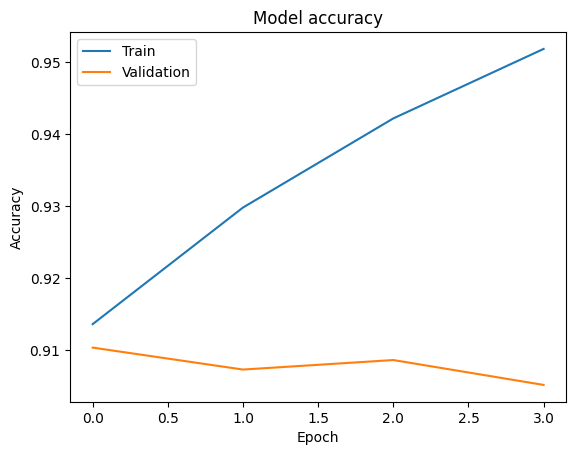

In [19]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()

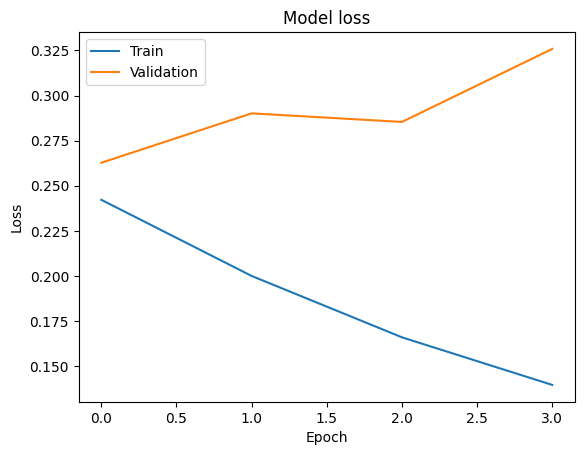

In [20]:
# Plotting loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png')
plt.show()

In [21]:

def check_similarity(sentence1, sentence2):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    proba = model.predict(test_data[0])[0]
    idx = np.argmax(proba)
    proba = f"{proba[idx]: .2f}%"
    pred = labels[idx]
    return pred, proba


In [22]:
sentence1 = "Two women are observing something together."
sentence2 = "Two women are standing with their eyes closed."
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/users/nfs/Enseignants/piwowarski/venv/deepdac/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 2s 2s/step


('contradiction', ' 1.00%')

In [23]:
sentence1 = "A smiling costumed woman is holding an umbrella"
sentence2 = "A happy woman in a fairy costume holds an umbrella"
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


1/1 [==============================] - 0s 53ms/step


('neutral', ' 1.00%')

In [24]:
sentence1 = "A soccer game with multiple males playing"
sentence2 = "Some men are playing a sport"
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


1/1 [==============================] - 0s 47ms/step


('entailment', ' 0.92%')

In [25]:
model.save('bert.h5')